#### Pong from Pixels using policy-gradient method. 
This is the Udacity notebook exercise. 

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



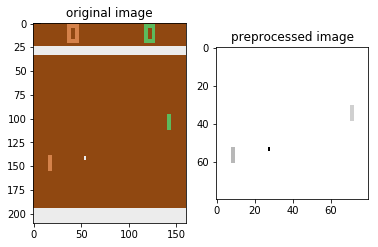

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)
        self.conv1 = nn.Conv2d(2, 6, kernel_size=6, stride = 2) # 38 38 
        self.conv2 = nn.Conv2d(6, 3, kernel_size=3, stride = 2) # 19
        # output = 20x20 here
        self.conv3 = nn.Conv2d(3, 1, kernel_size=3, stride=2) # # 9
        self.size=1*8*8 # I calculated 9*9 but it is 8*8
        self.hidden = 3*9
        # 1 fully connected layer
        self.fc1 = nn.Linear(self.size, self.hidden)
        self.fc2 = nn.Linear(self.hidden, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # flatten the tensor
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

# use your own policy!
policy=Policy().to(device)


# policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


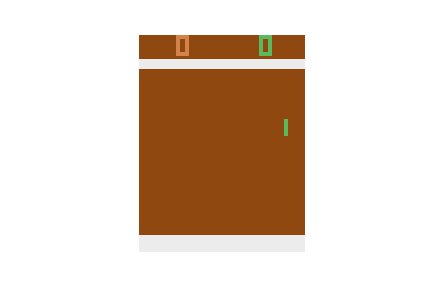
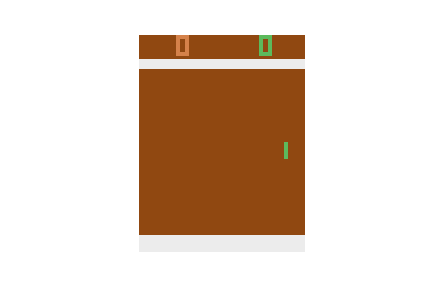
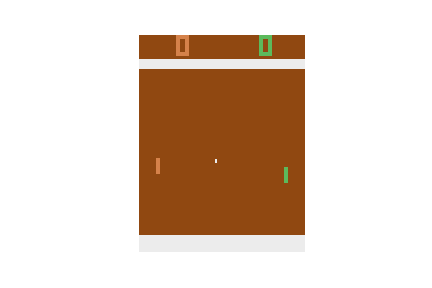
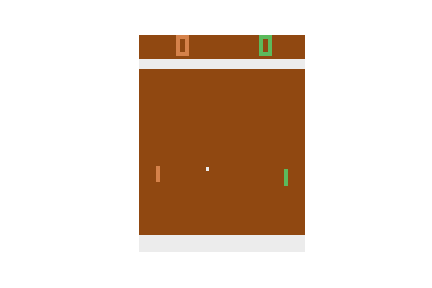
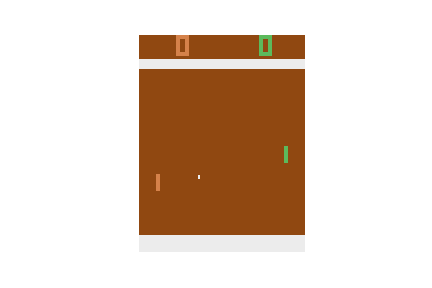
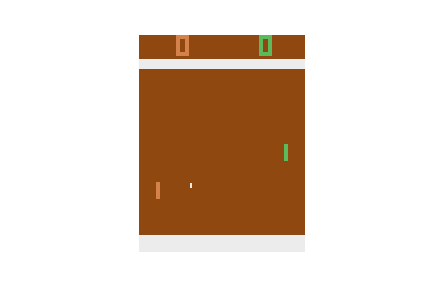
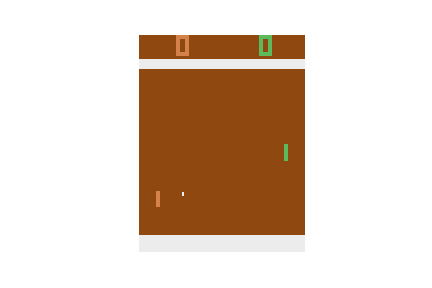
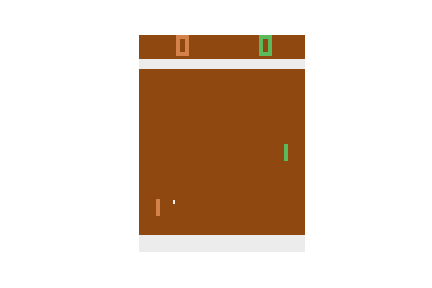
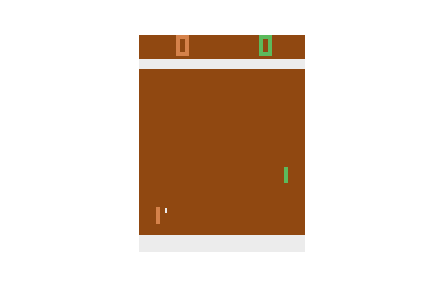
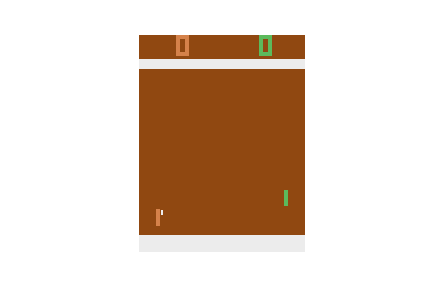
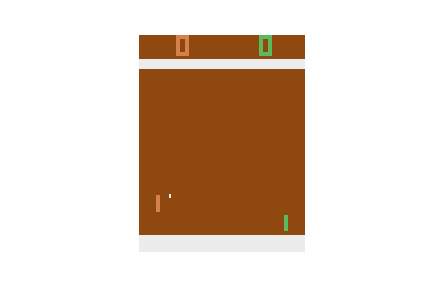
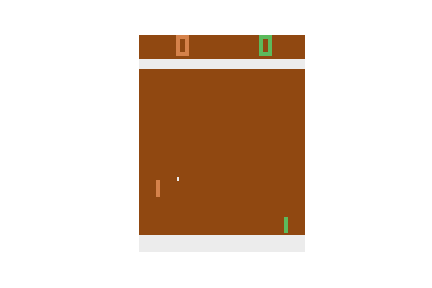
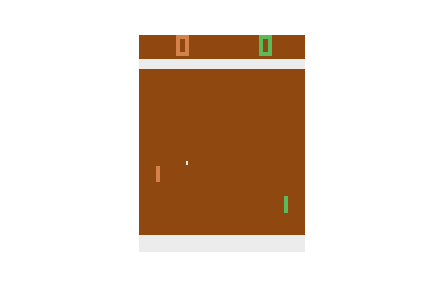
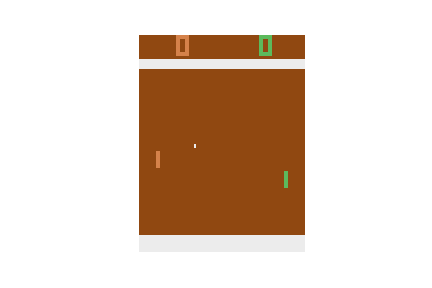
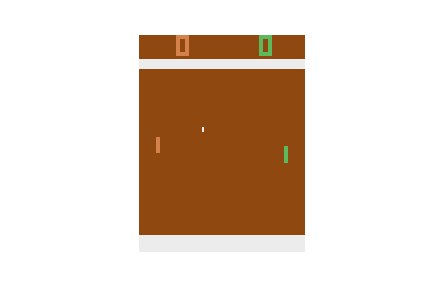
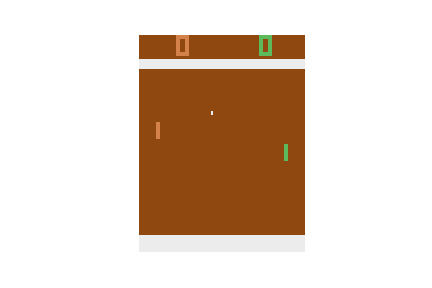
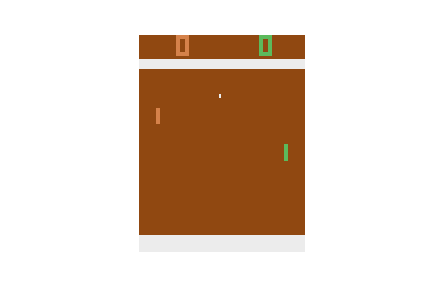
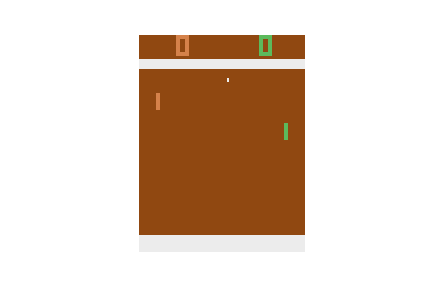
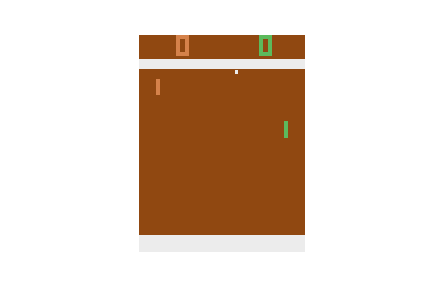
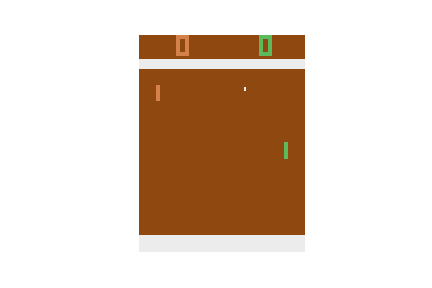
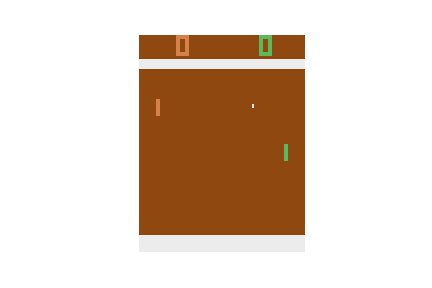
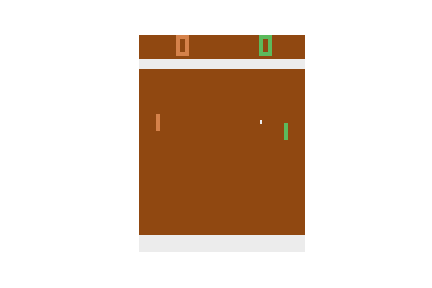
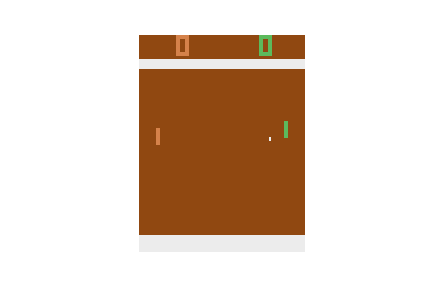
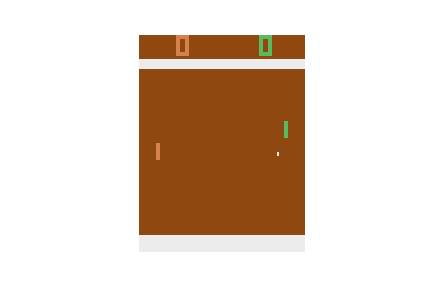
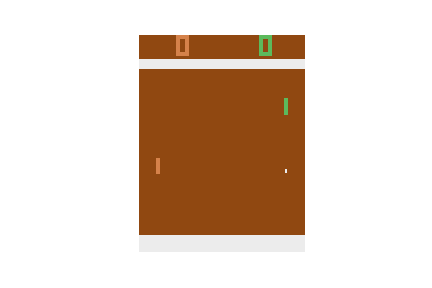
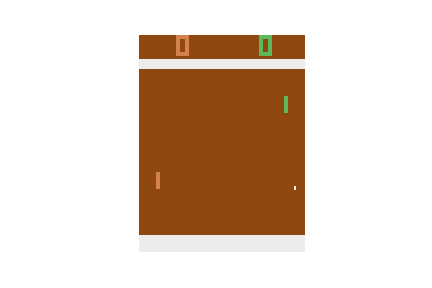
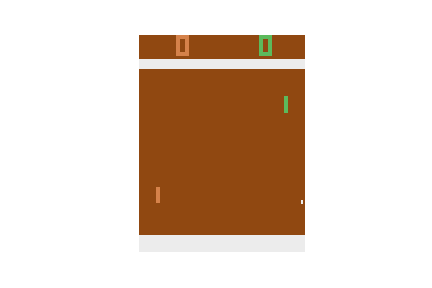
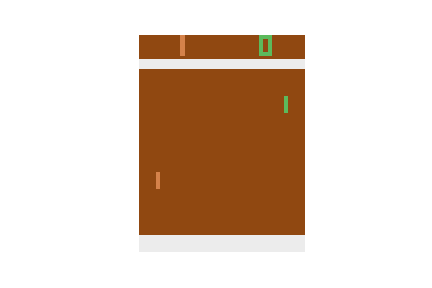
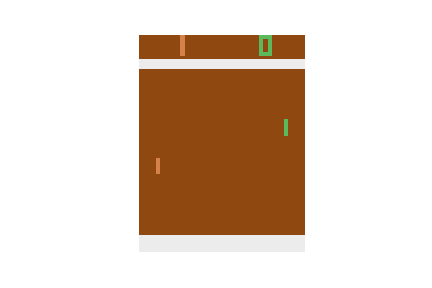
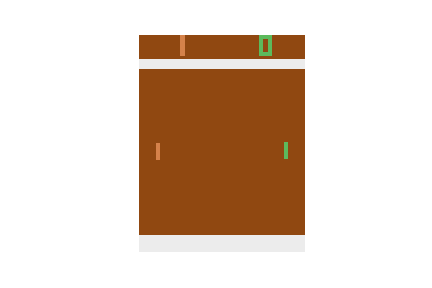
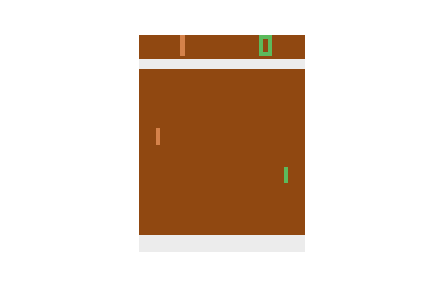
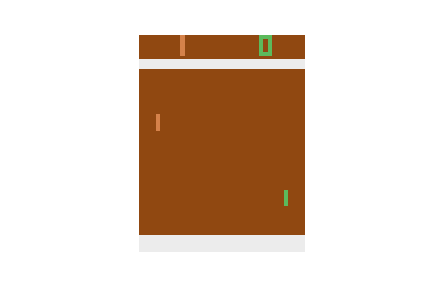
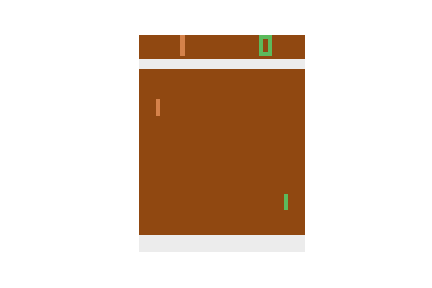
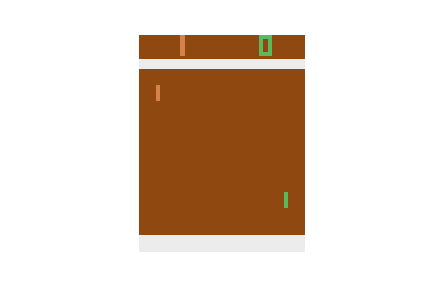
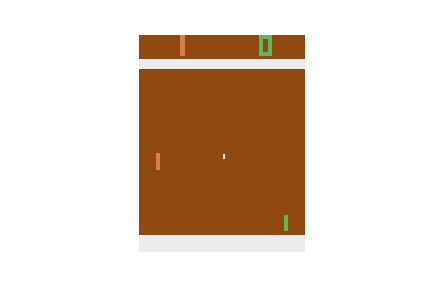
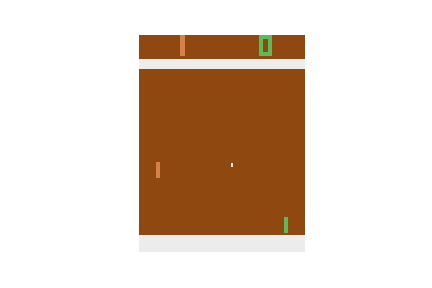
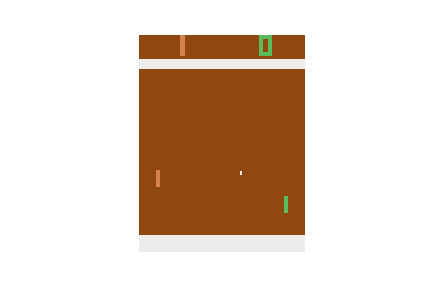
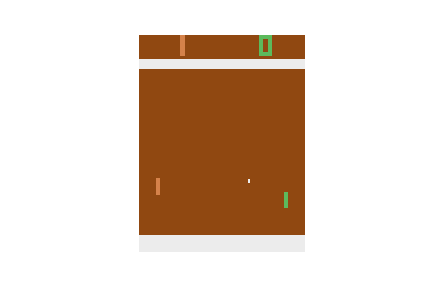
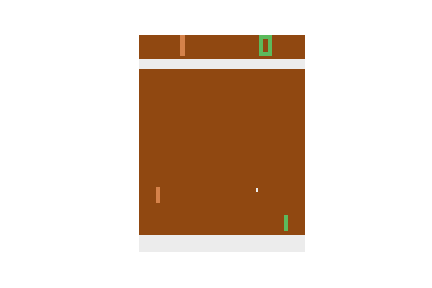
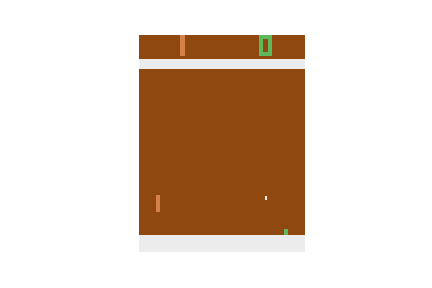
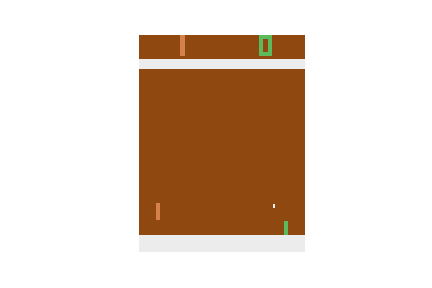
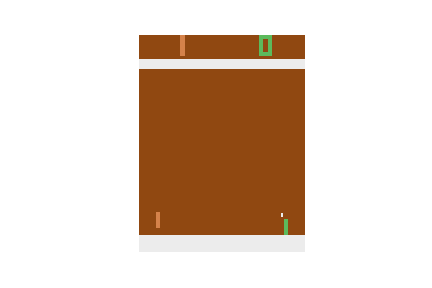
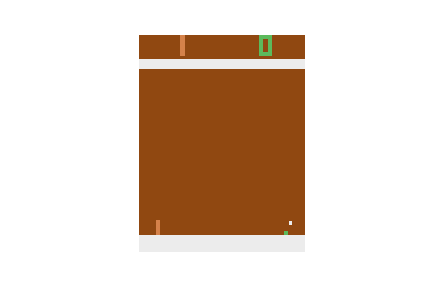
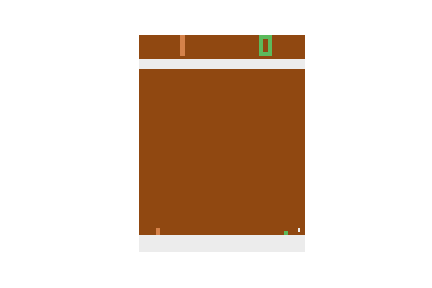
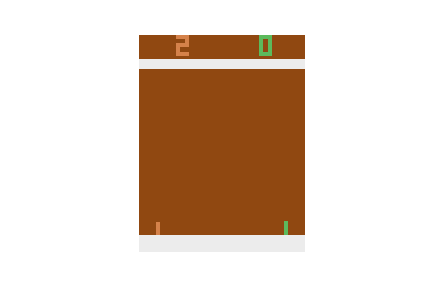
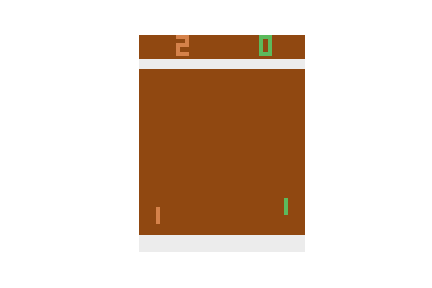
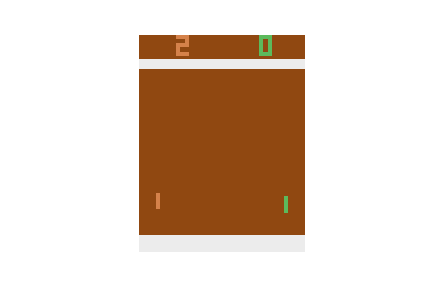
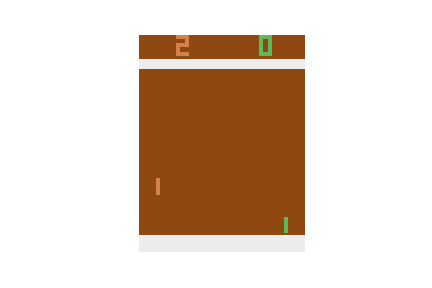
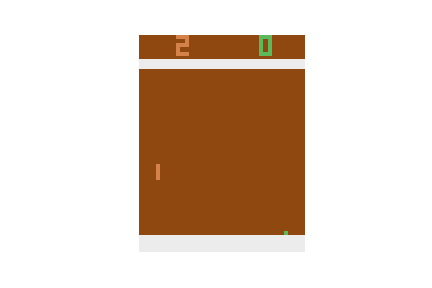
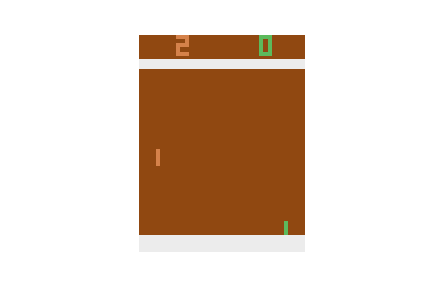
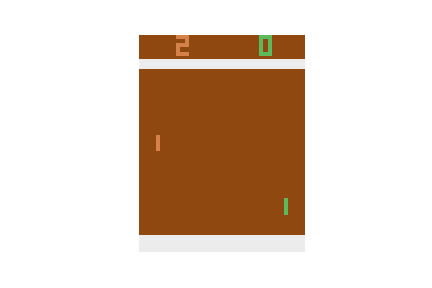
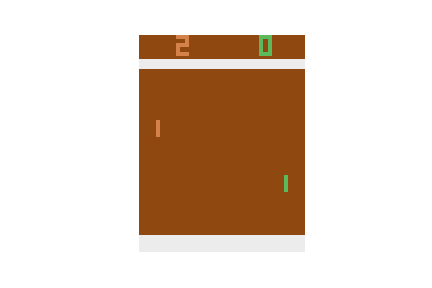
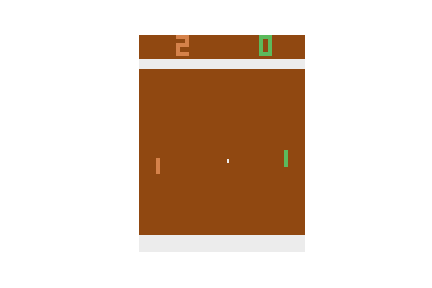
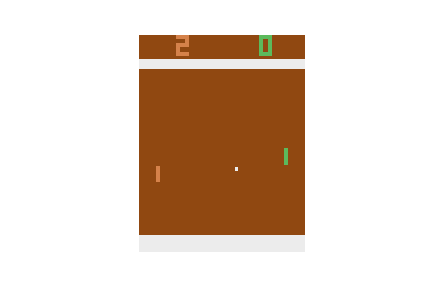
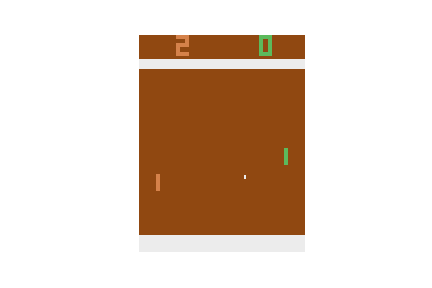
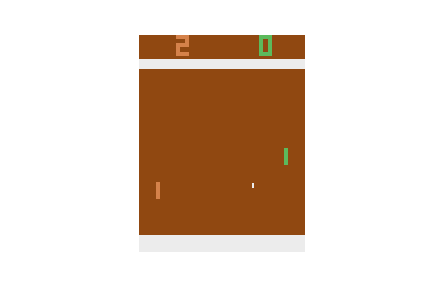
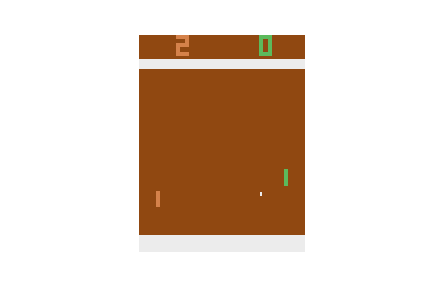
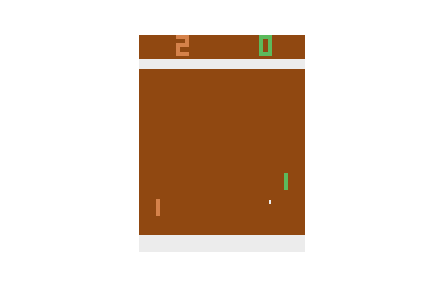
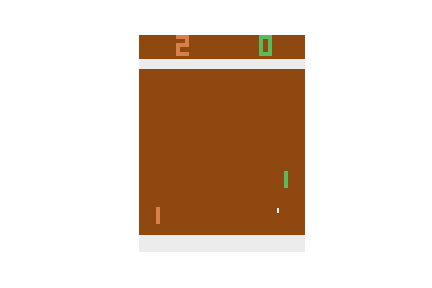
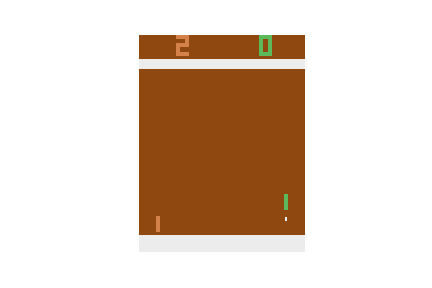
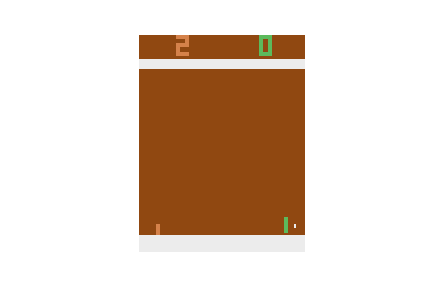
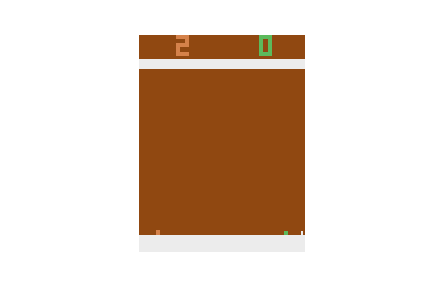
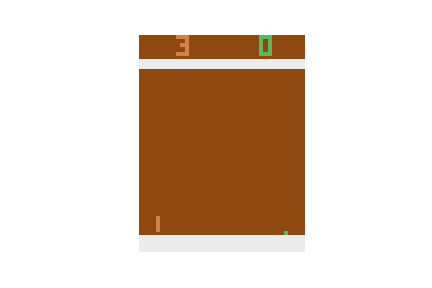
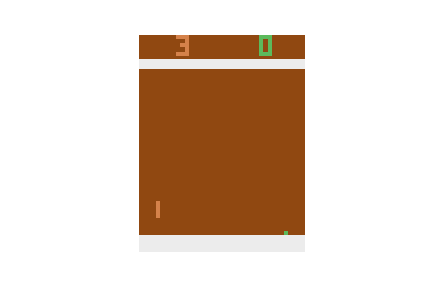
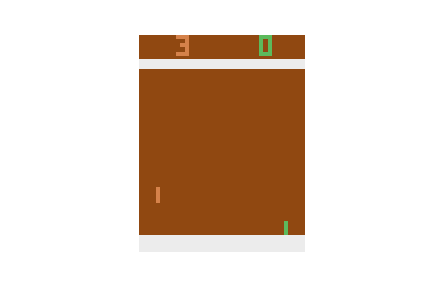
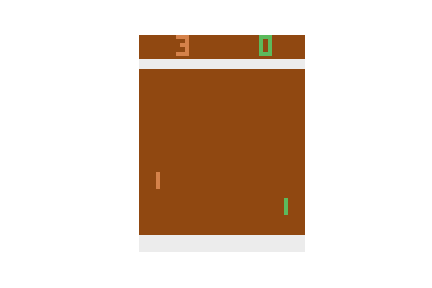
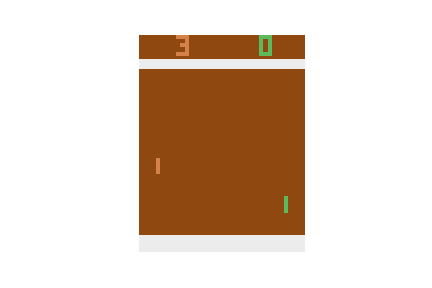
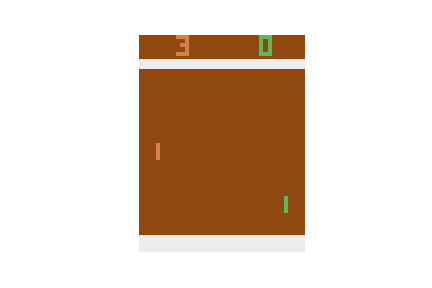
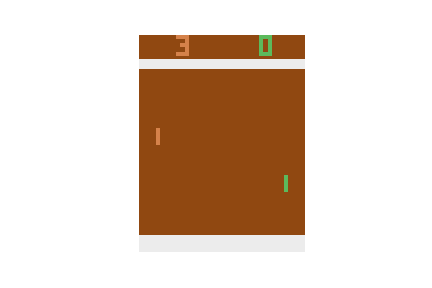
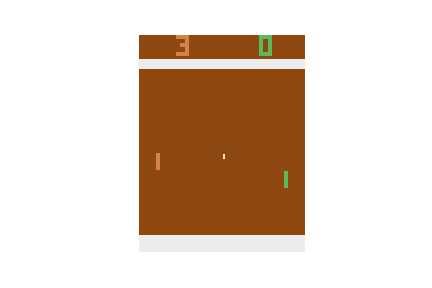
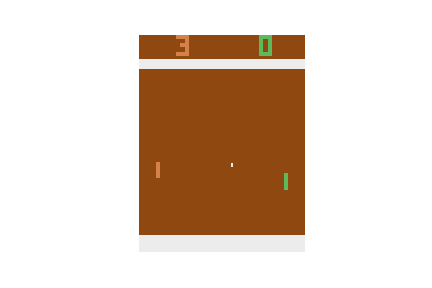
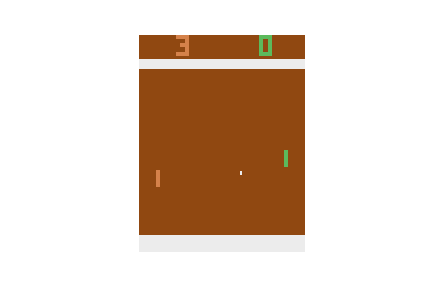
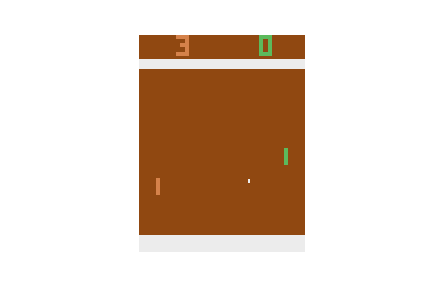
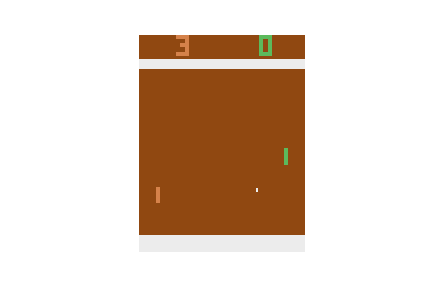
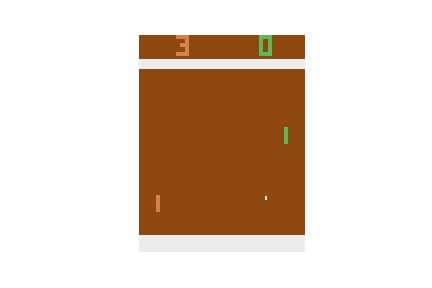
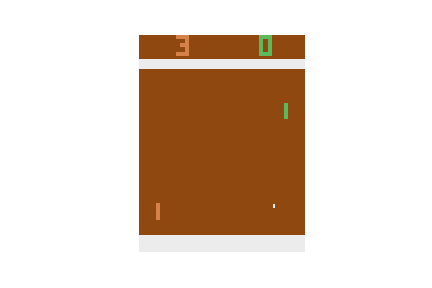
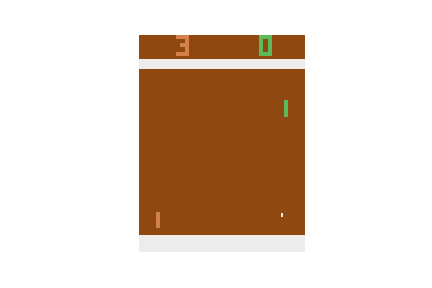
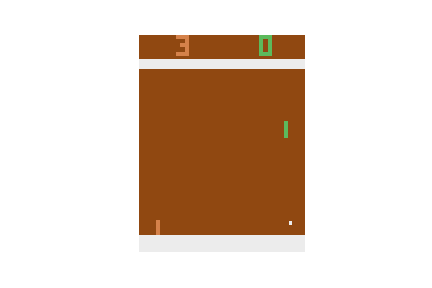
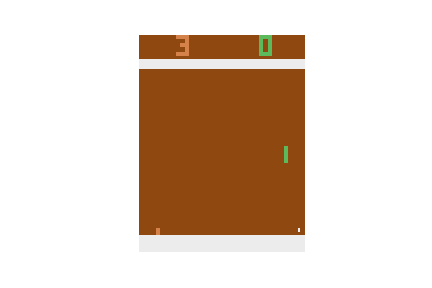
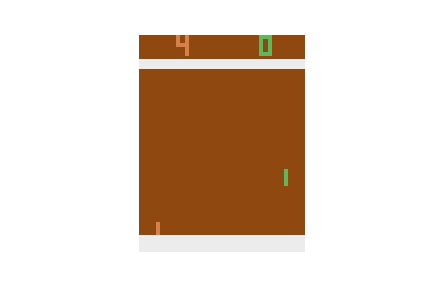
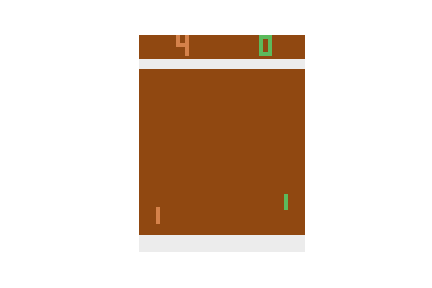
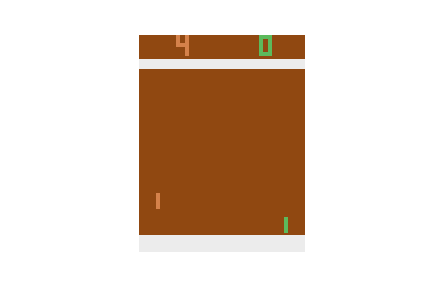
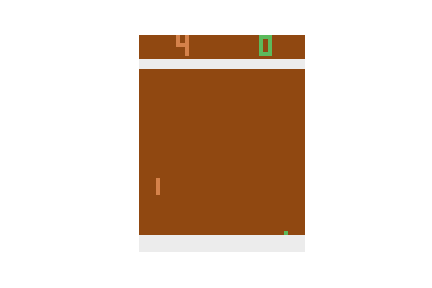
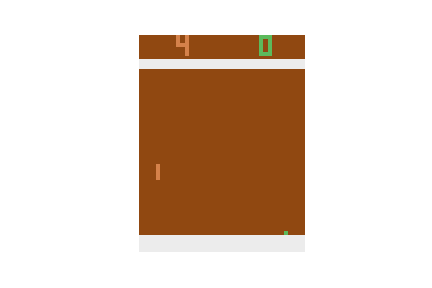
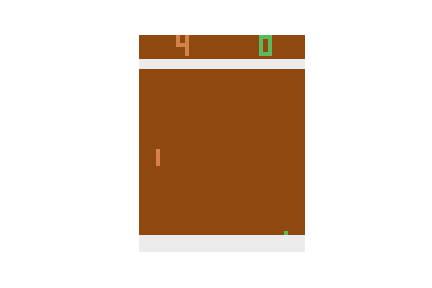
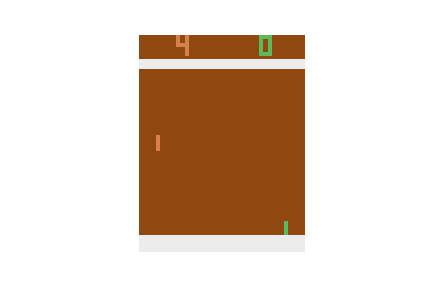
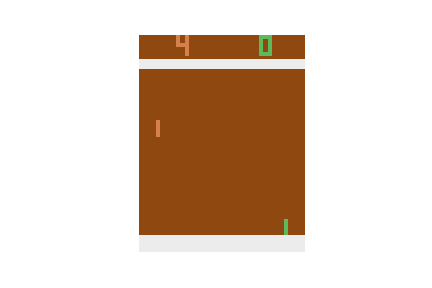
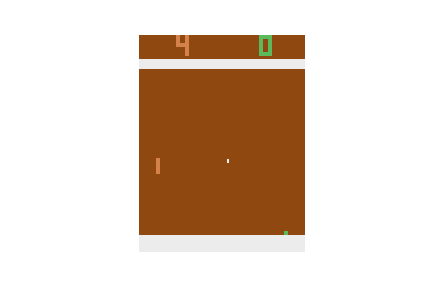
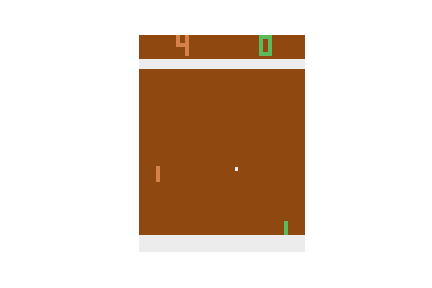
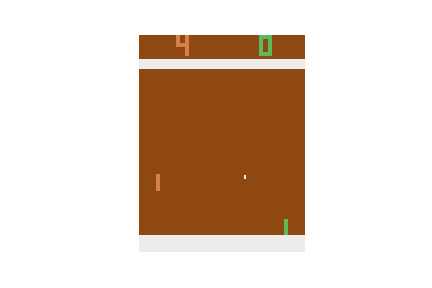
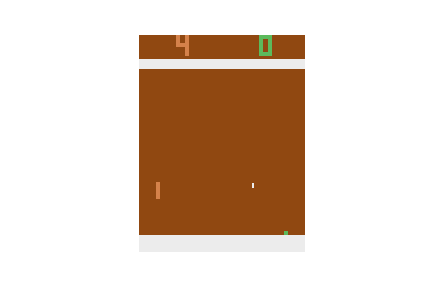
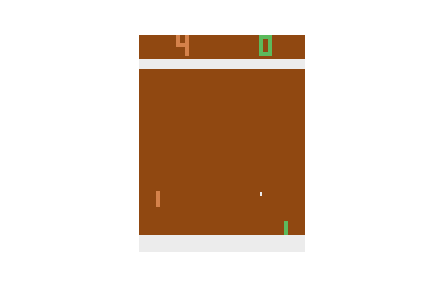
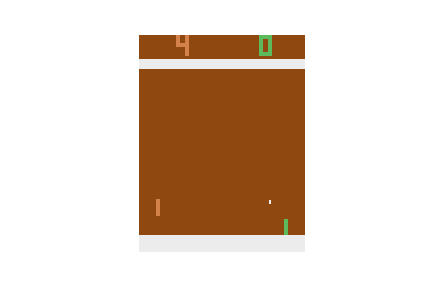
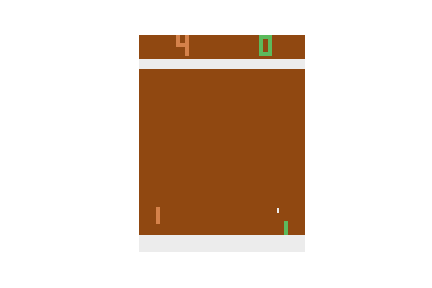
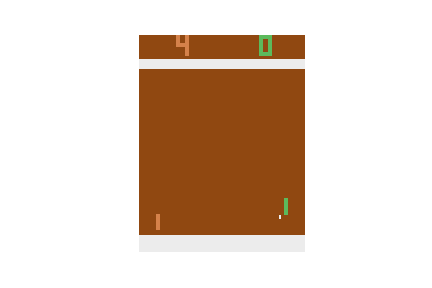
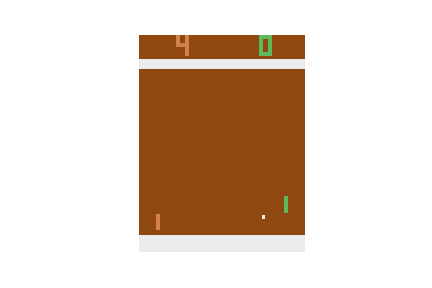
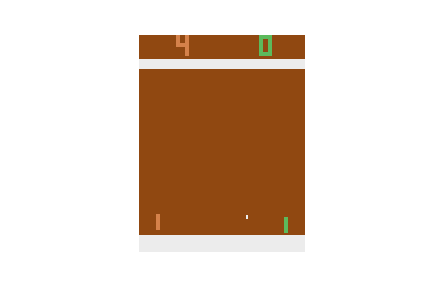
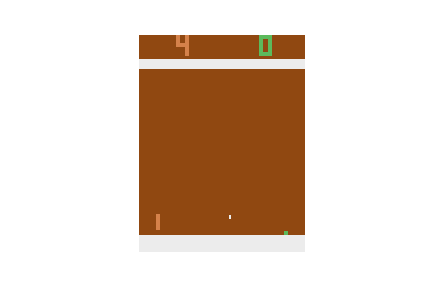
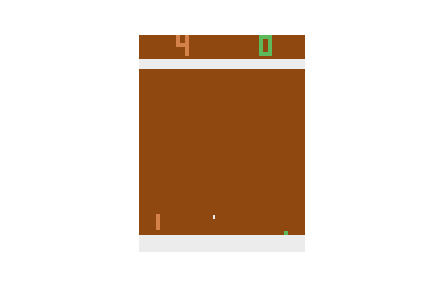
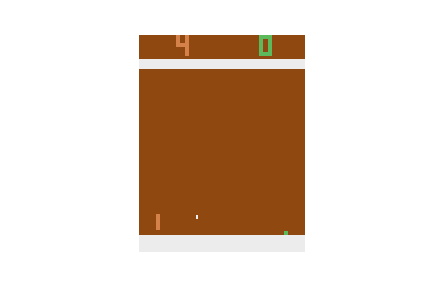

In [5]:
pong_utils.play(env, policy, time=100) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [6]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

Process Process-4:
Process Process-2:
Process Process-3:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/workspace/parallelEnv.py", line 104, in worker
    cmd, data = remote.recv()
  File "/opt/conda/lib/python3.6/multipro

In [7]:
# print(prob)

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

In [8]:
import numpy as np
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):
    ########
    discounts = [discount**i for i in range(len(rewards))]
    T = len(rewards)
    rew = torch.tensor(discounts).unsqueeze(1).repeat(1, len(rewards[0]))* torch.tensor(rewards).float()
    R = torch.sum(rew, dim = 0).float()

    ########
    
    actions = torch.tensor(actions, dtype=torch.int8, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs) # selects a row from x or 1-x depending on condition truth
#     loss = (1/T) * torch.log(new_probs* 1.e-10) * torch.from_numpy(R).to(device)
    loss = (1/T) * torch.log(new_probs* 1.e-10) 
    loss = torch.mean(loss, dim=0) * R.to(device)

    old_probs = torch.tensor(old_probs).to(device)
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return (torch.mean( (-loss))) + torch.mean(beta*entropy)

Lsur= surrogate(policy, prob, state, action, reward)

print(Lsur)

tensor(-0.7424, device='cuda:0')


In [9]:
######## This is a debugging cell...
# rewards = reward
# actions = action
# states = state
# discount = 0.995
# beta=0.01

# discounts = [discount**i for i in range(len(rewards))]

# discounts_log = np.logspace(start=0, stop=len(rewards),num=len(rewards), base=discount)
# #     import ipdb; ipdb.set_trace()
# print(len(rewards))
# # print(discounts.shape)
# #     discounted_rewards = discounts*rewards

# T = len(rewards)
# #     for t in range(T):
# #         future_R = #np.cumsum(discounted_rewards[::-1])[::-1]  # reverse cummlative sum in numpy
# R =  np.sum(rewards, 0)

# ########

# actions = torch.tensor(actions, dtype=torch.int8, device=device)


# # convert states to policy (or probability)
# new_probs = pong_utils.states_to_prob(policy, states)
# new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs) # selects a row from x or 1-x depending on condition truth
# loss = (1/T) * torch.log(new_probs* 1.e-10) 
# loss = torch.mean(loss, dim=0) * torch.from_numpy(R.astype('float32')).to(device)
# print('loss shape:'+ str(loss.shape))

100
loss shape:torch.Size([4])


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [15]:
from parallelEnv import parallelEnv
import numpy as np
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500
# episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
#     L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
    

Episode: 20, score: -15.500000
[-16. -16. -16. -15. -16. -13. -16. -16.]


Episode: 40, score: -14.000000
[-11. -15. -16. -15. -11. -16. -14. -14.]


Episode: 60, score: -13.625000
[-15. -16. -12. -15. -14. -14. -15.  -8.]


Episode: 80, score: -14.125000
[-15. -10. -16. -14. -16. -16. -10. -16.]


Episode: 100, score: -15.750000
[-16. -17. -14. -16. -15. -17. -16. -15.]


Episode: 120, score: -14.625000
[-15. -16. -16. -16. -14. -12. -14. -14.]


Episode: 140, score: -12.875000
[-16. -16. -13. -15. -15.  -6.  -8. -14.]


Episode: 160, score: -12.375000
[-15. -15. -11. -13. -11. -11. -10. -13.]


Episode: 180, score: -14.375000
[-12. -13. -15. -14. -15. -13. -16. -17.]


Episode: 200, score: -13.125000
[-10. -16. -12. -16. -13. -15. -14.  -9.]


Episode: 220, score: -15.250000
[-16. -16. -16. -11. -15. -16. -16. -16.]


Episode: 240, score: -14.125000
[-13. -16. -13. -16. -16. -16. -14.  -9.]


Episode: 260, score: -14.500000
[-16. -14. -17. -15. -15. -11. -14. -14.]


Episode: 280, score: -13.750000
[-13. -14. -16. -15. -12. -13. -13. -14.]


Episode: 300, score: -14.375000
[ -9. -17. -13. -17. -16. -15. -16. -12.]


Process Process-9:% |##########################                 | ETA:  0:15:35
Process Process-6:
Process Process-5:
Process Process-11:
Process Process-12:
Process Process-10:
Process Process-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-8:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **se

KeyboardInterrupt: 


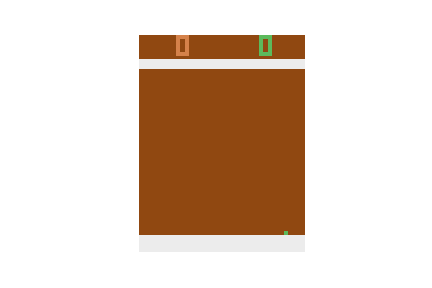
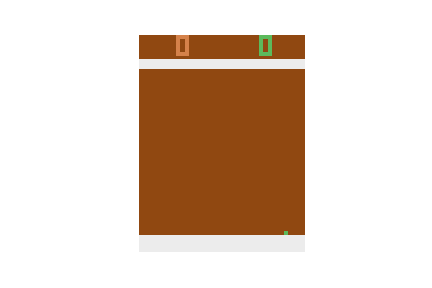
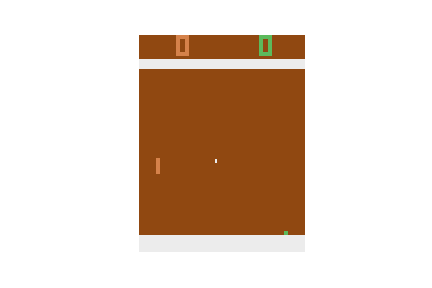
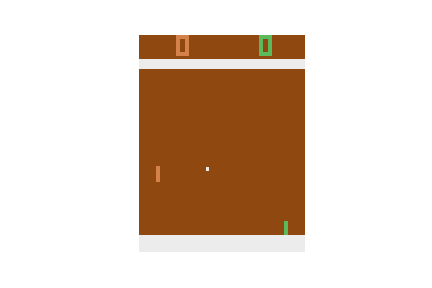
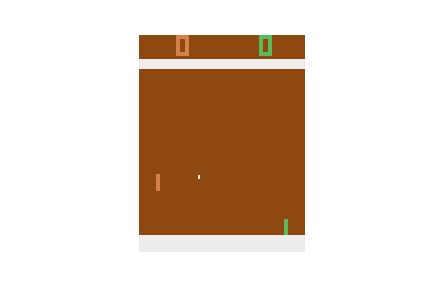
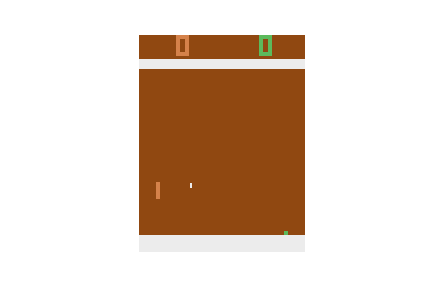
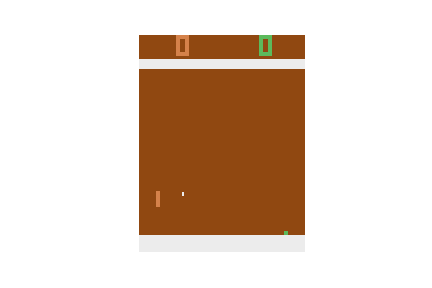
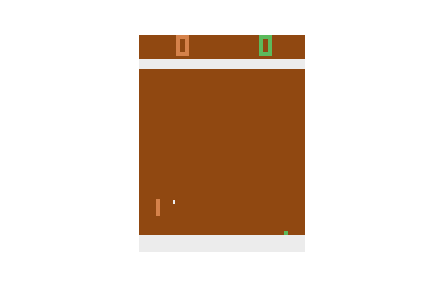
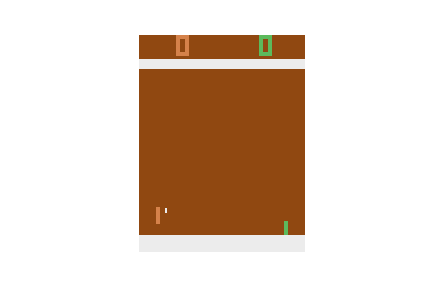
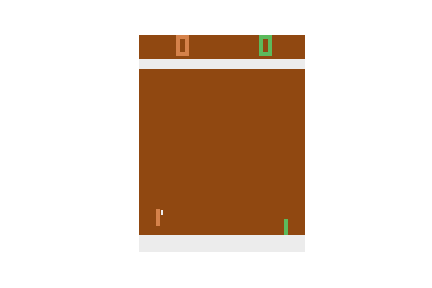
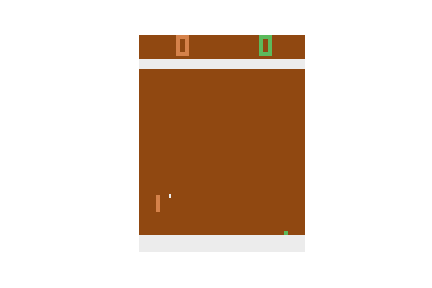
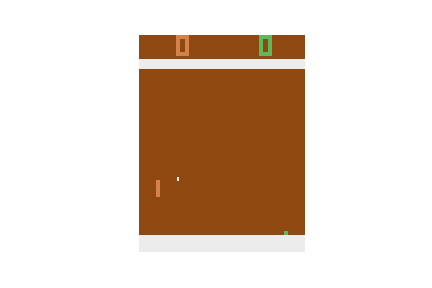
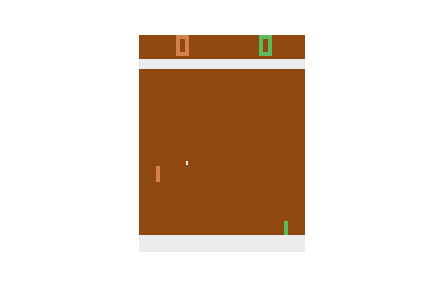
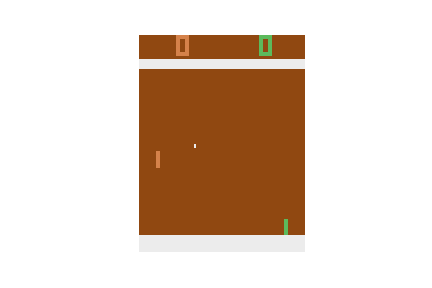
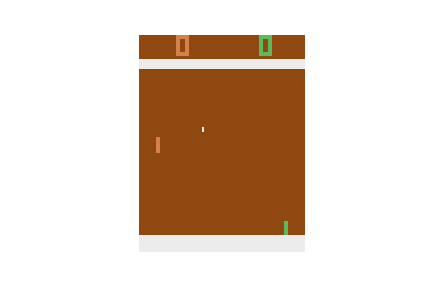
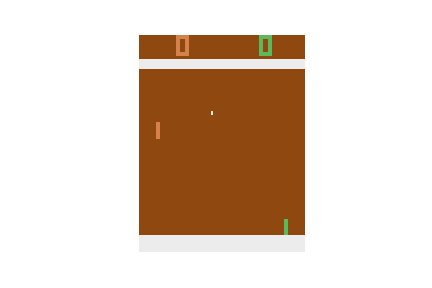
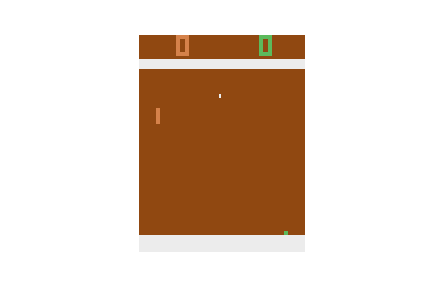
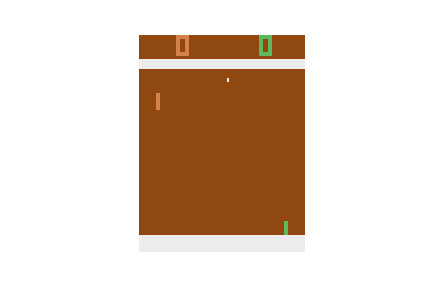
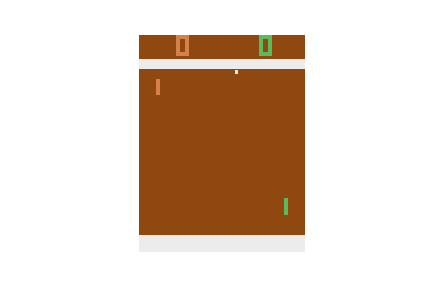
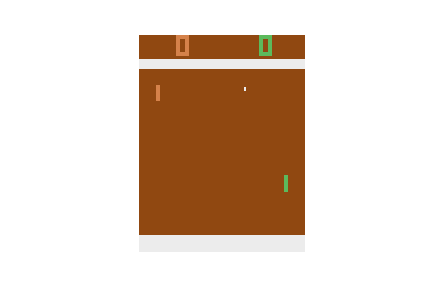
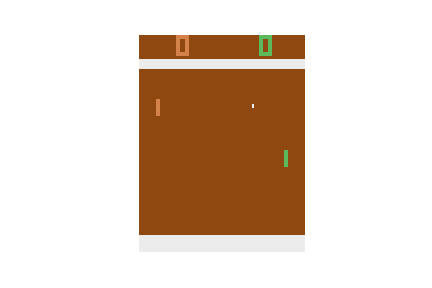
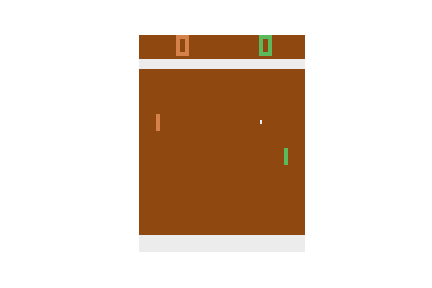
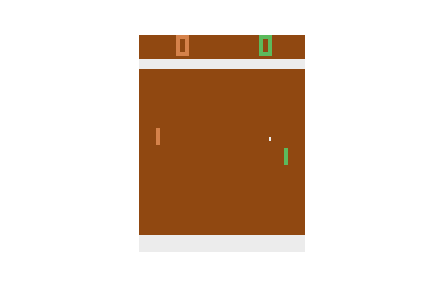
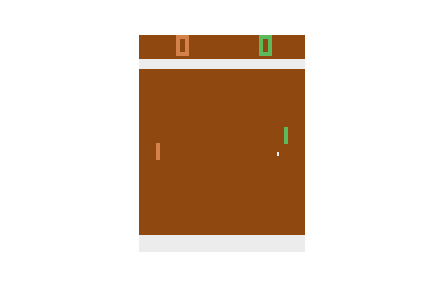
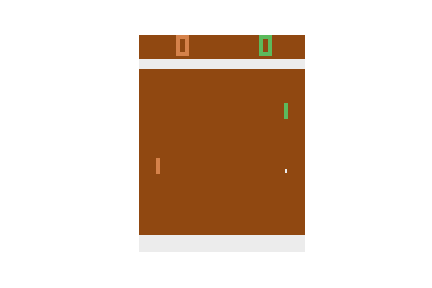
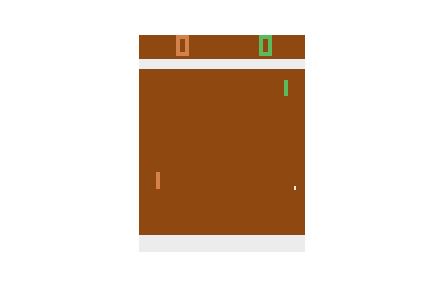
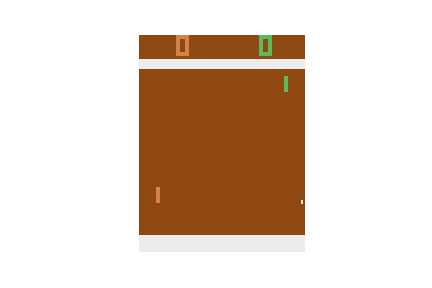
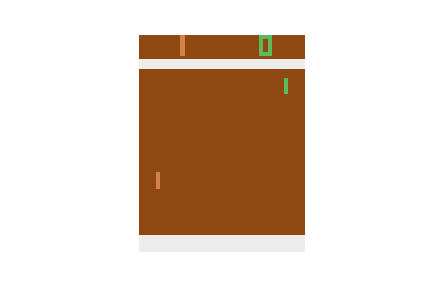
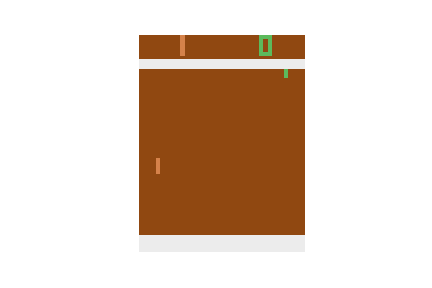
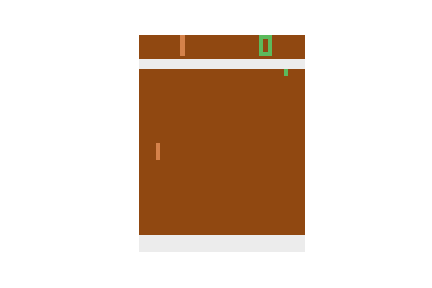
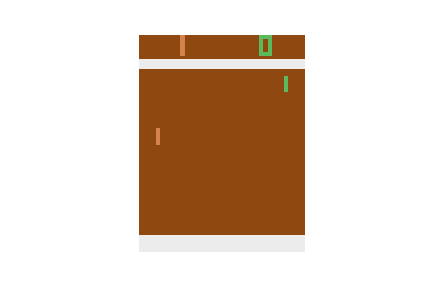
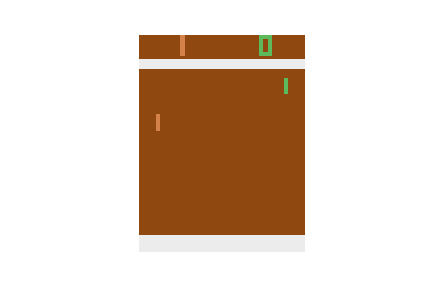
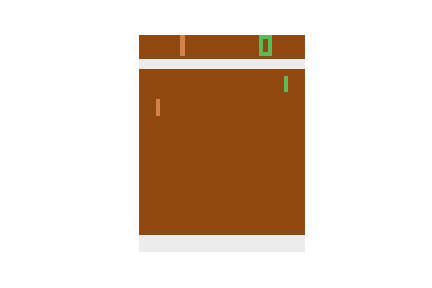
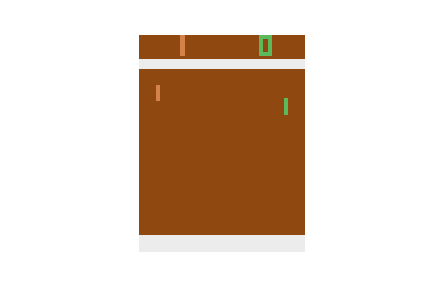
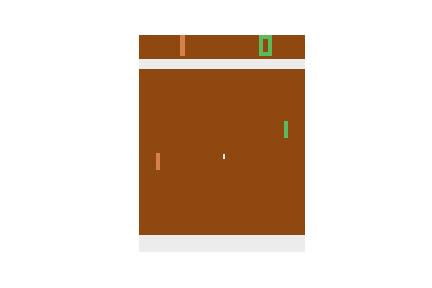
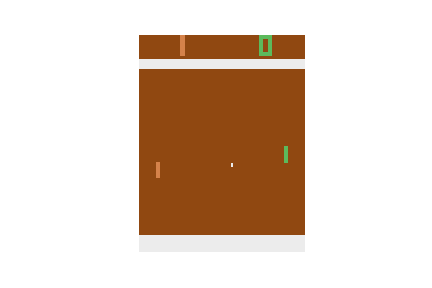
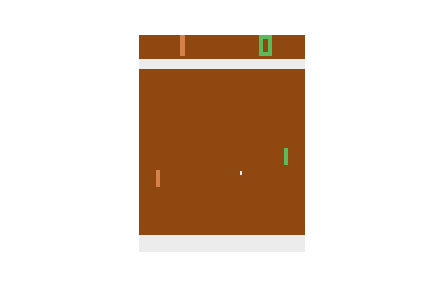
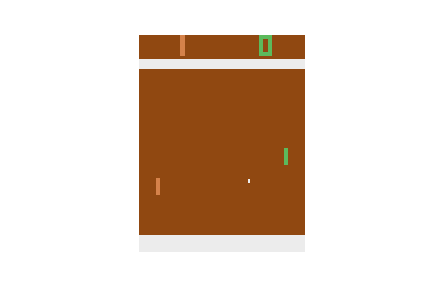
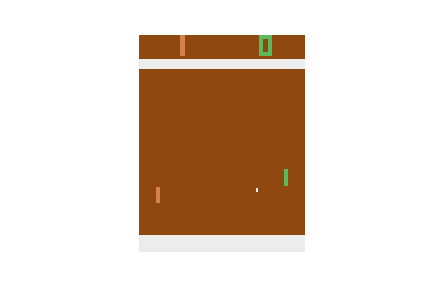
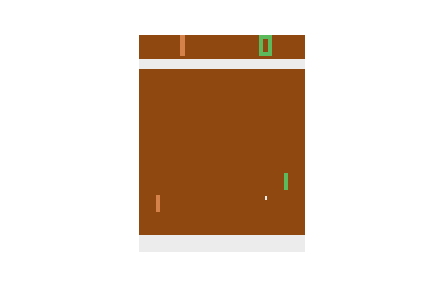
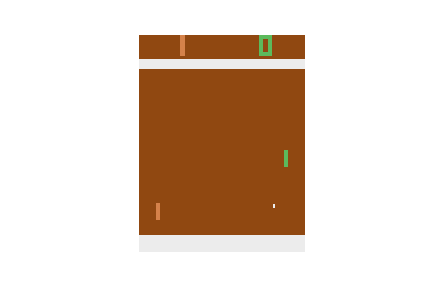
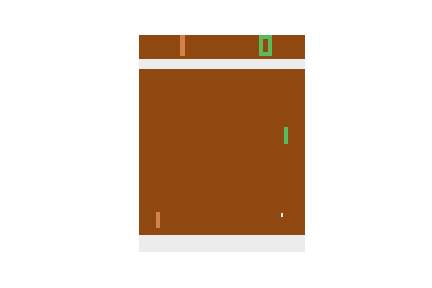
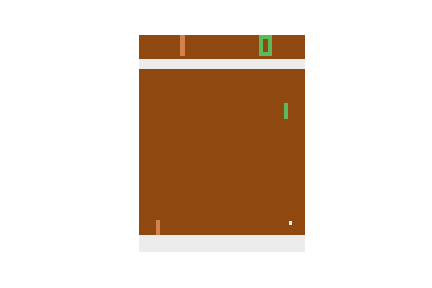
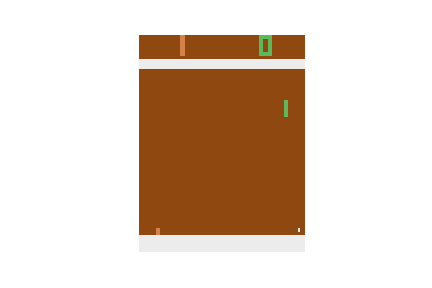
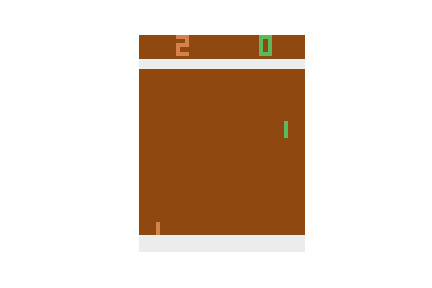
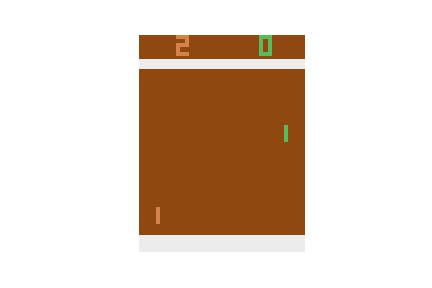
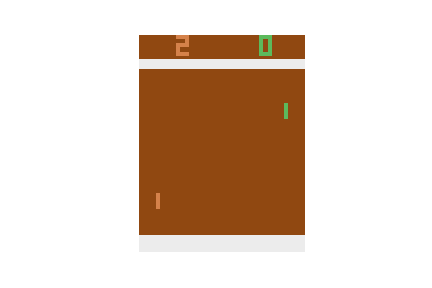
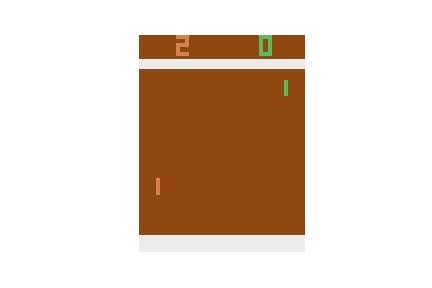
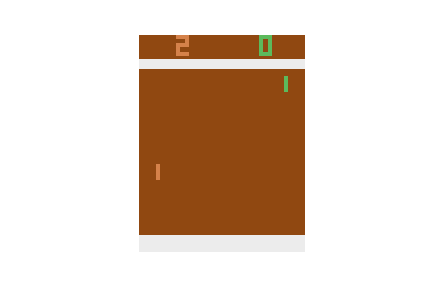
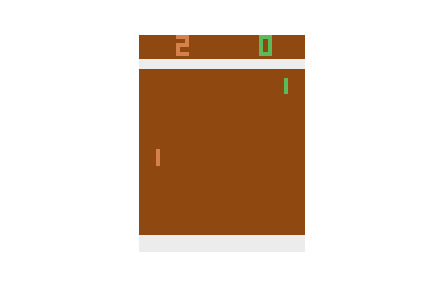
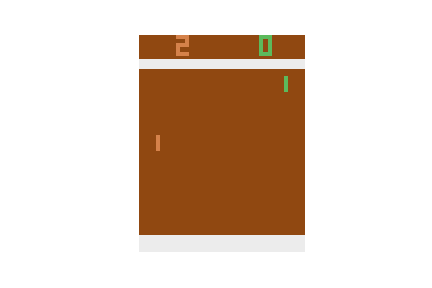
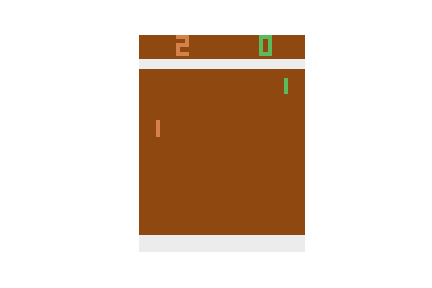
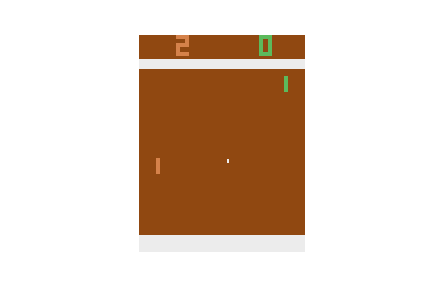
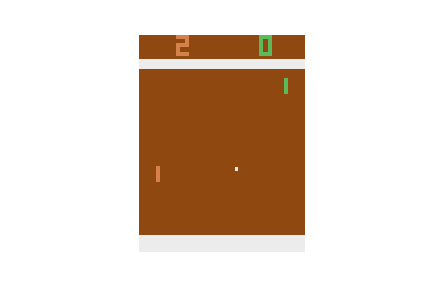
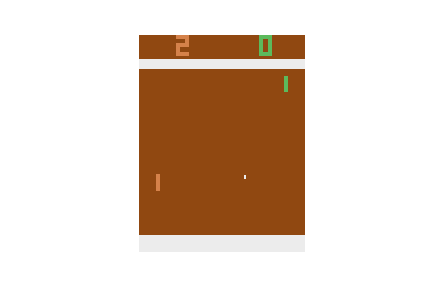
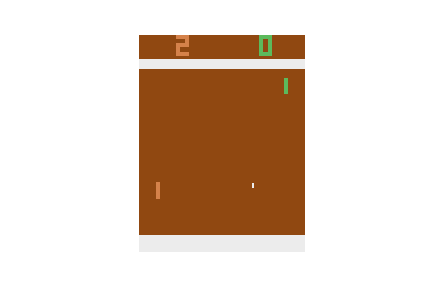
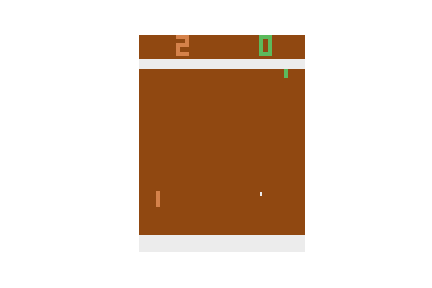
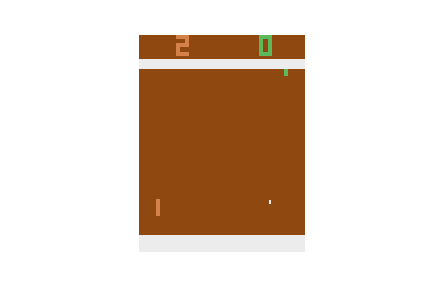
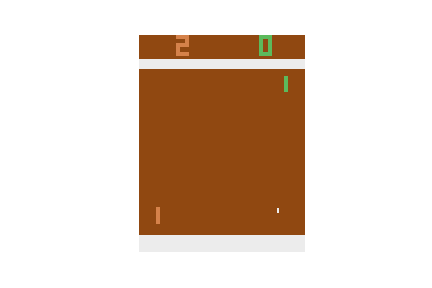
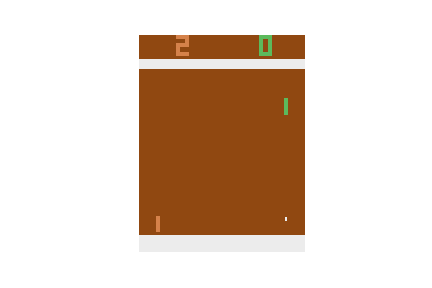
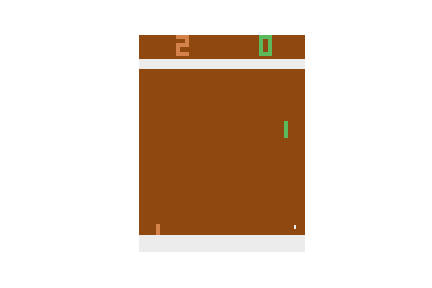
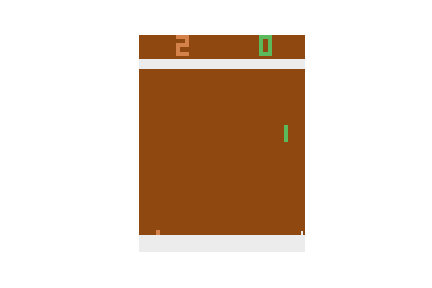
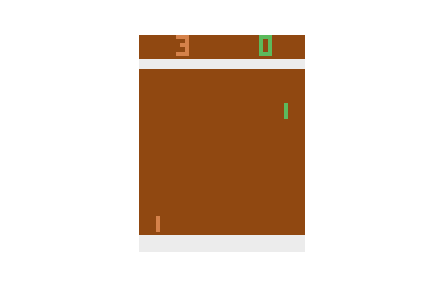
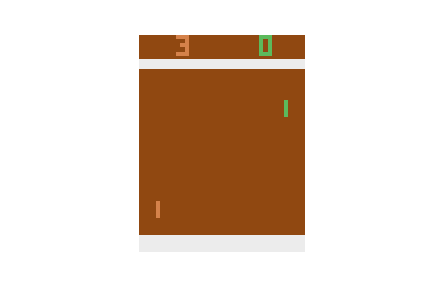
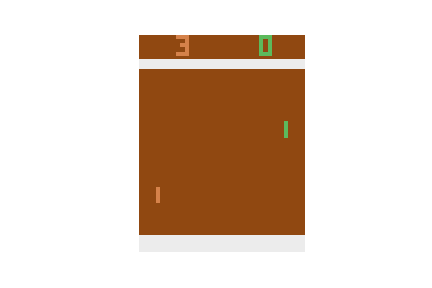
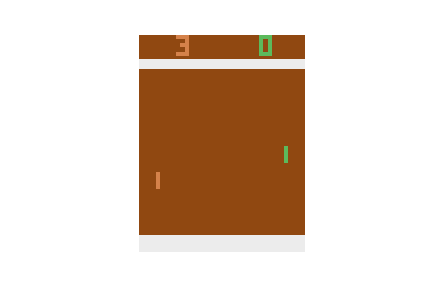
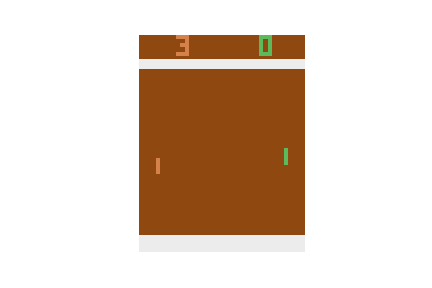
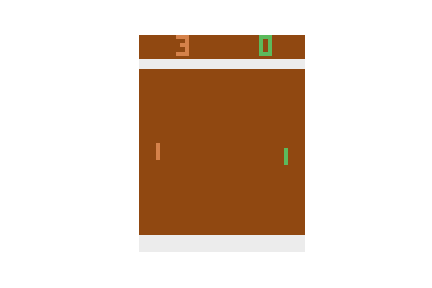
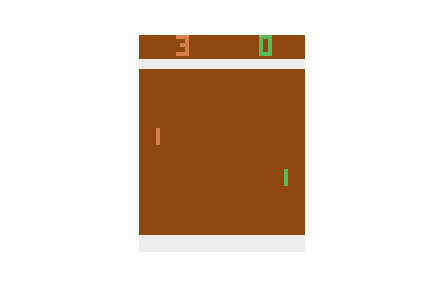
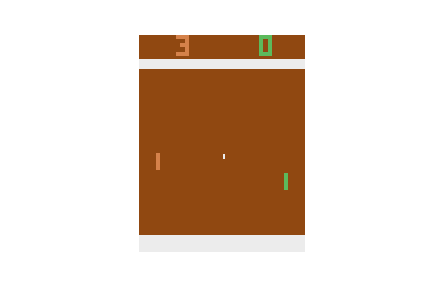
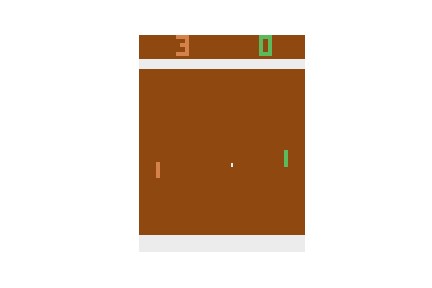
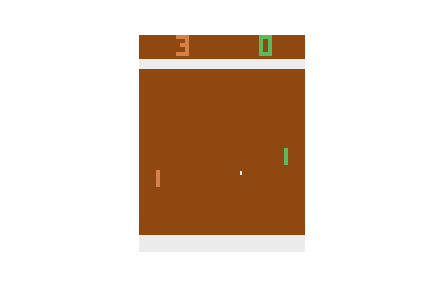
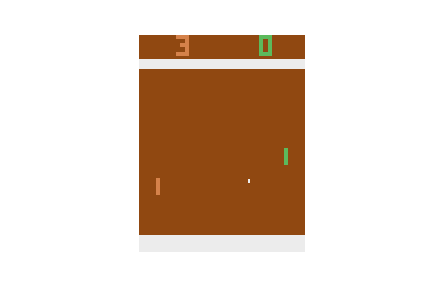
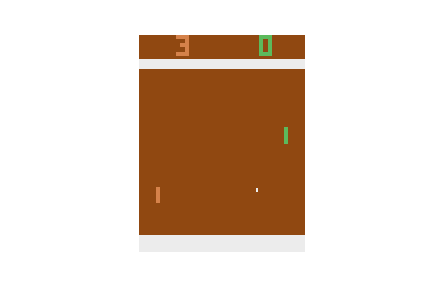
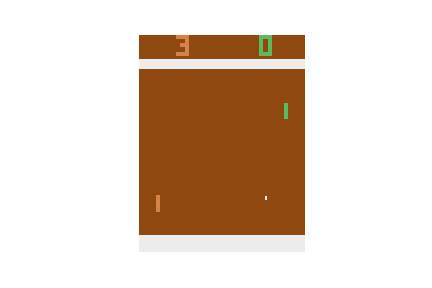
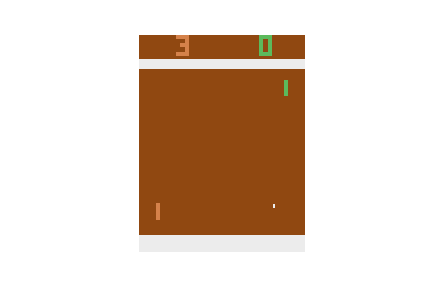
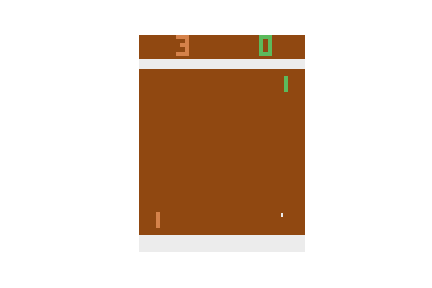
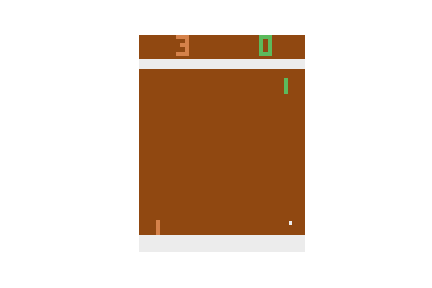
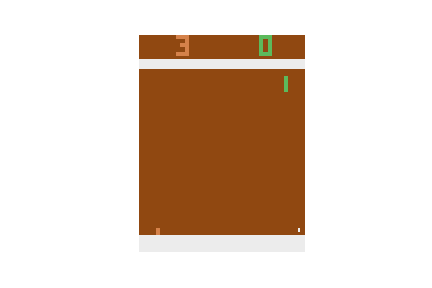
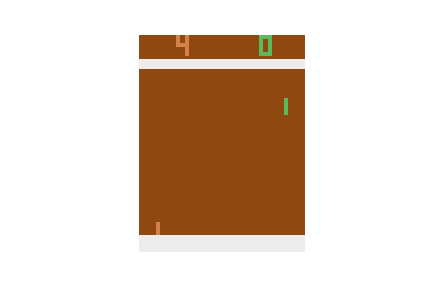
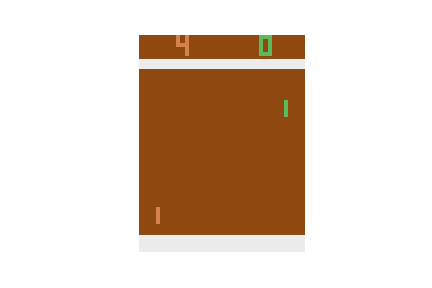
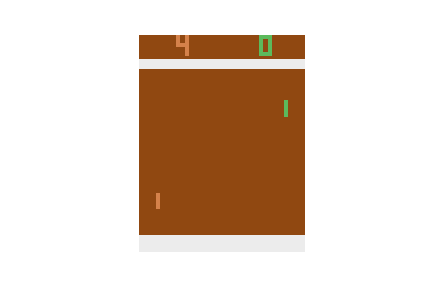
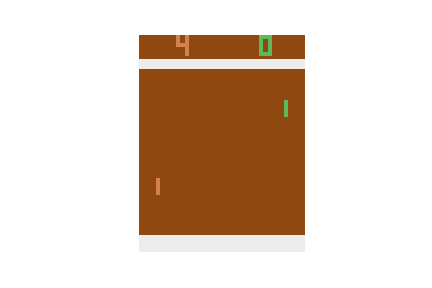
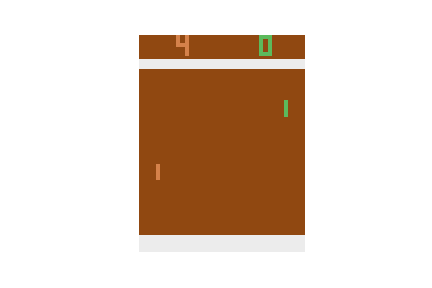
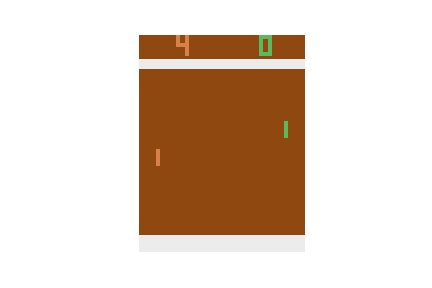
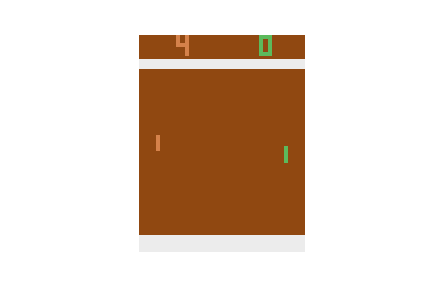
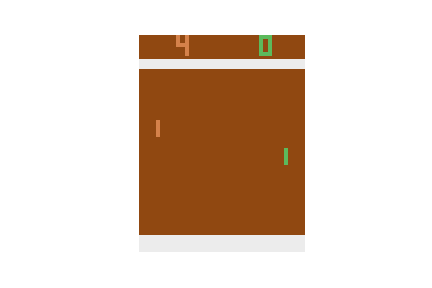
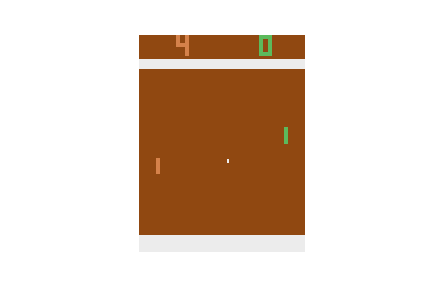
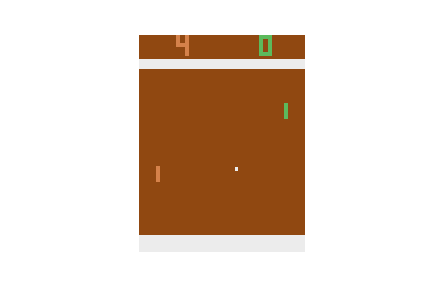
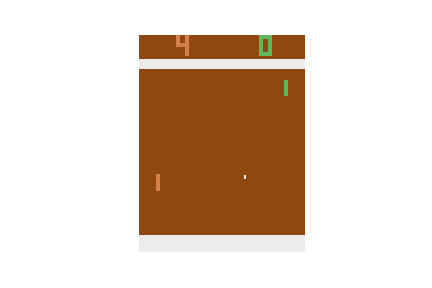
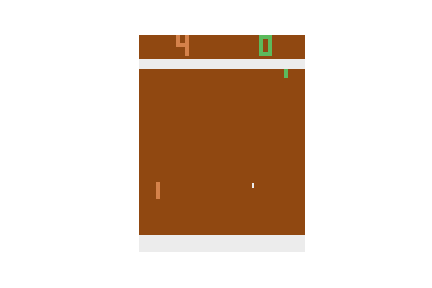
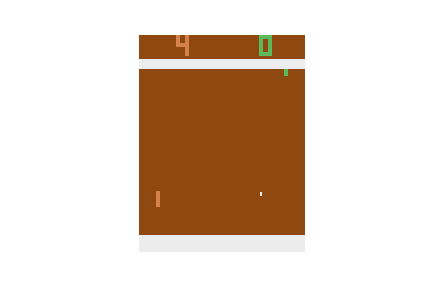
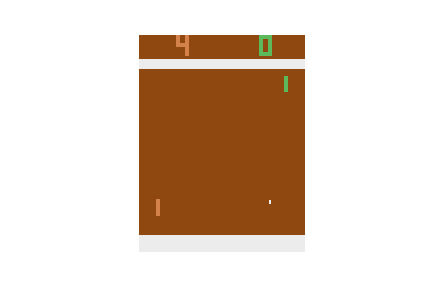
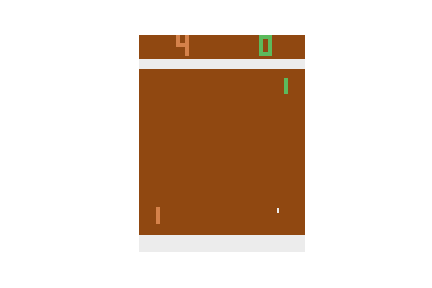
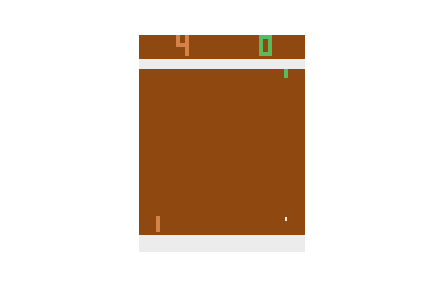
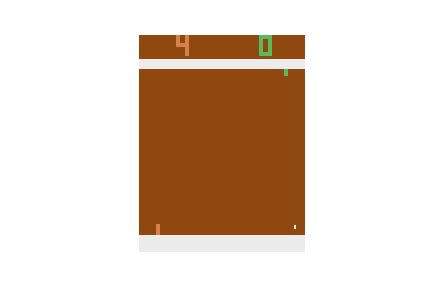
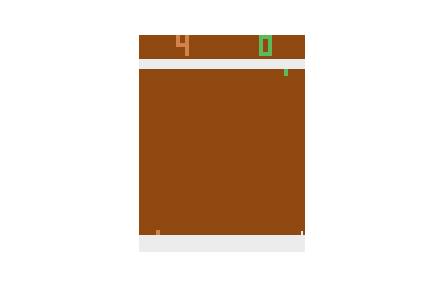
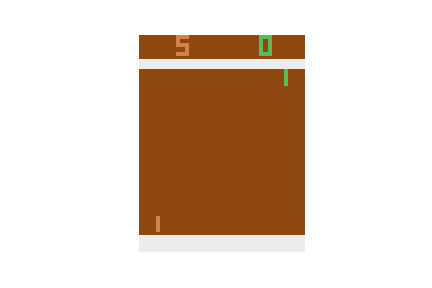
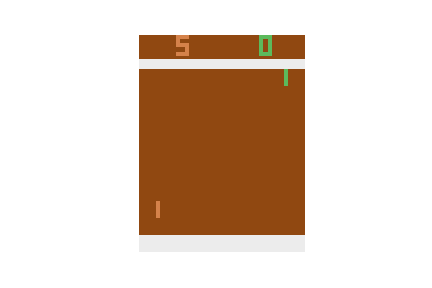
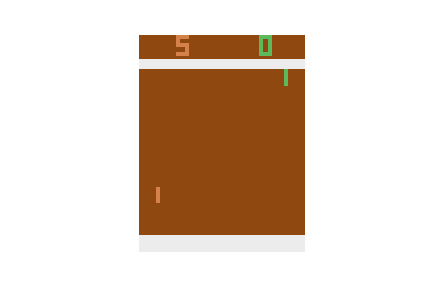
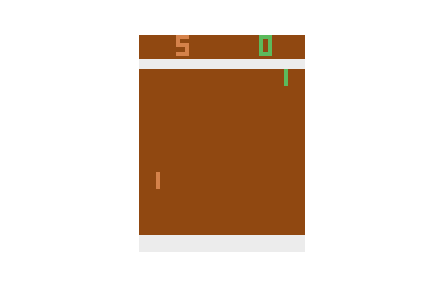
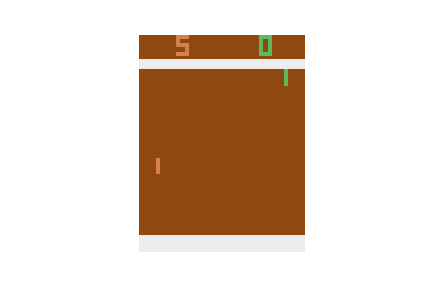
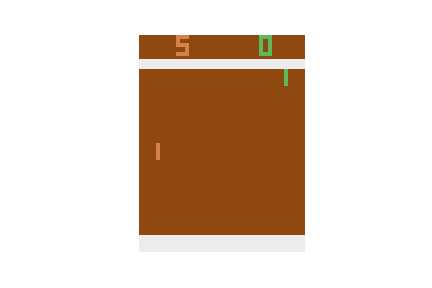
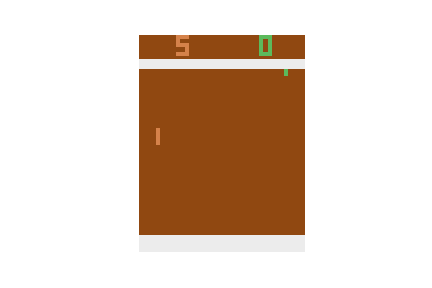
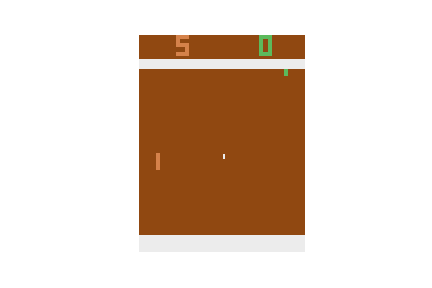
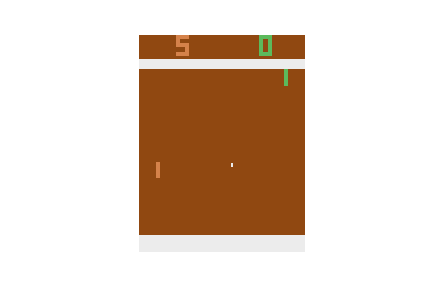
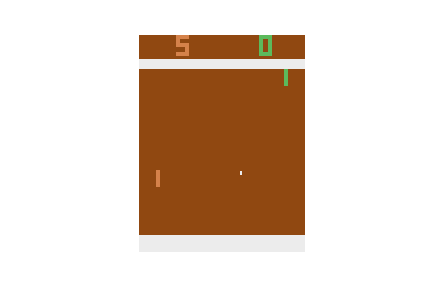
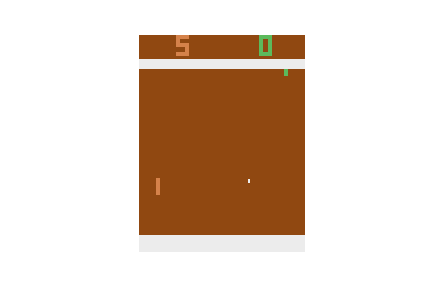
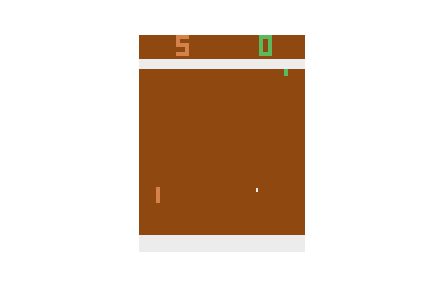
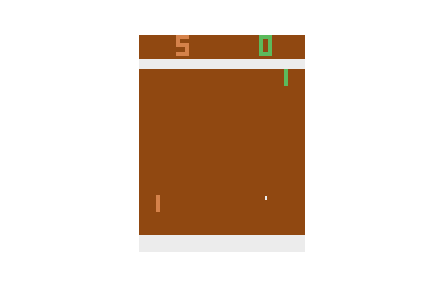
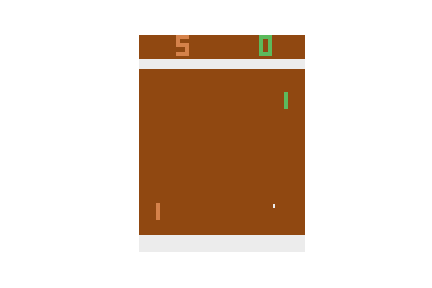
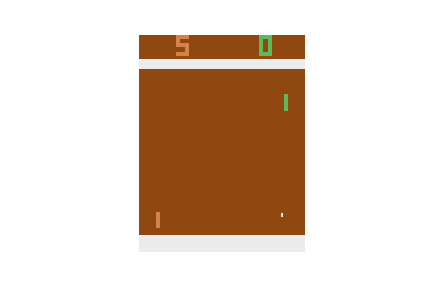
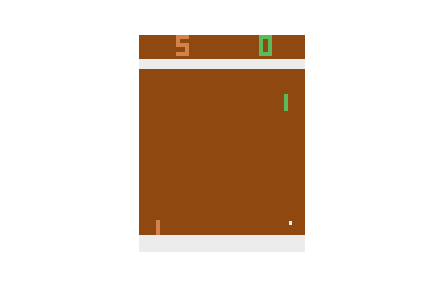
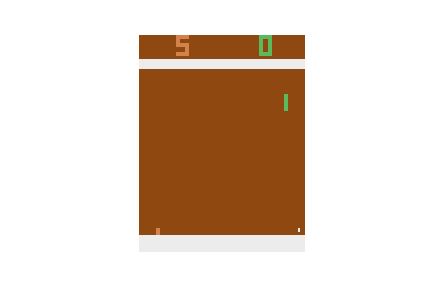
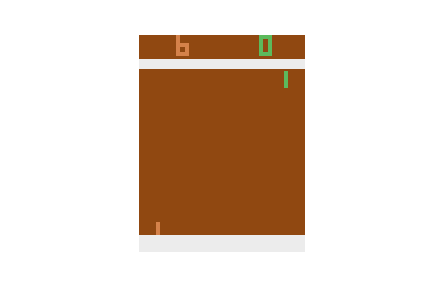
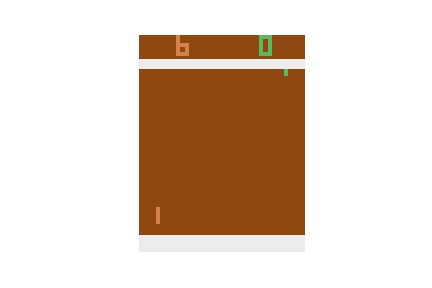
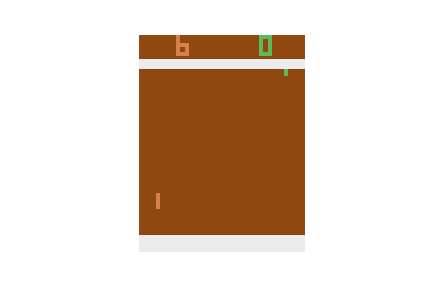
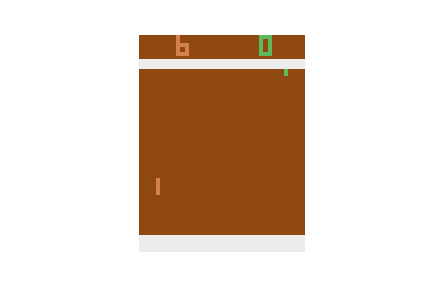
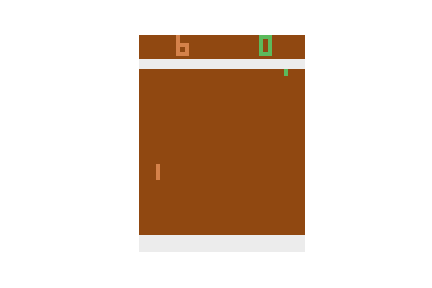
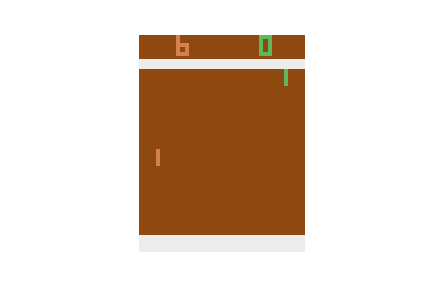
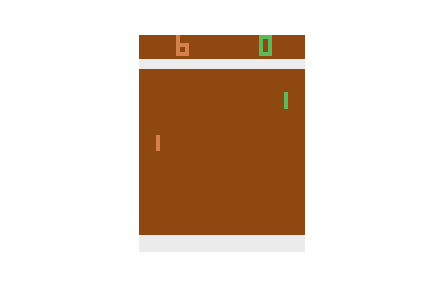
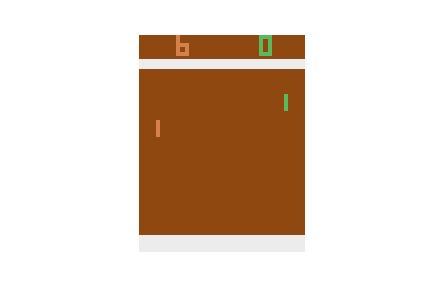
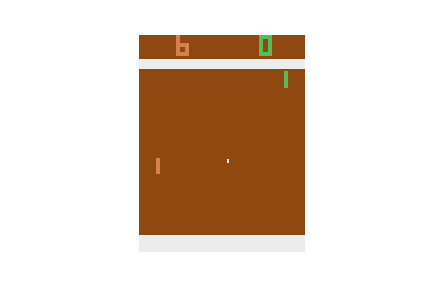
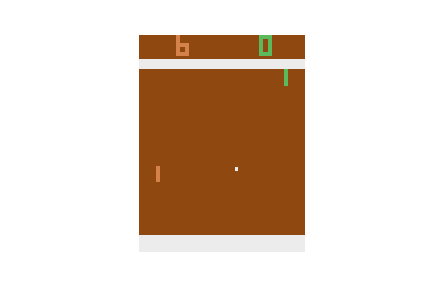
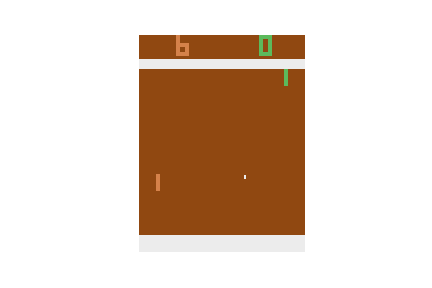
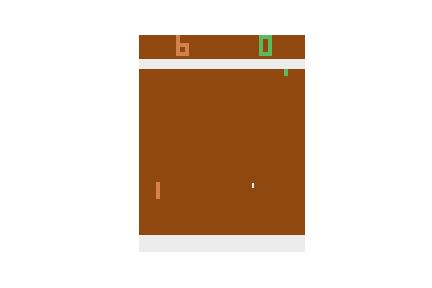
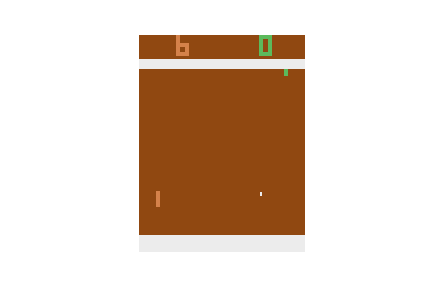
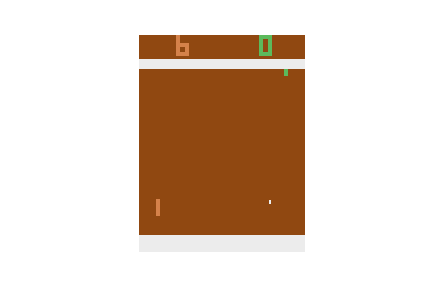
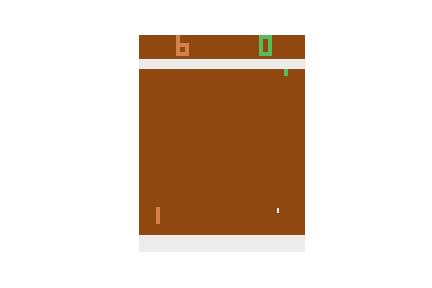
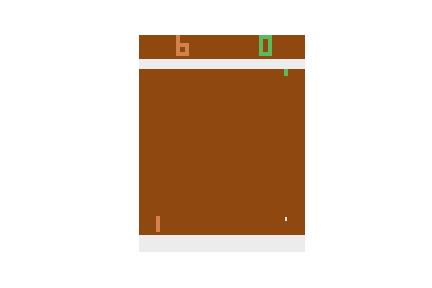
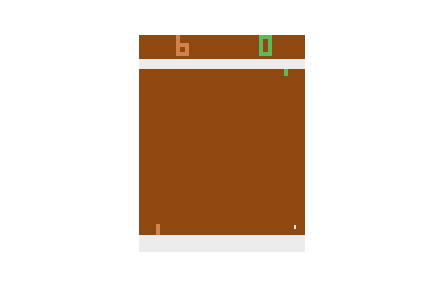
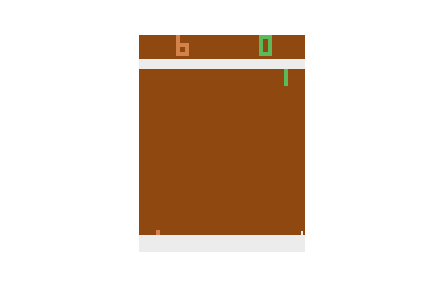
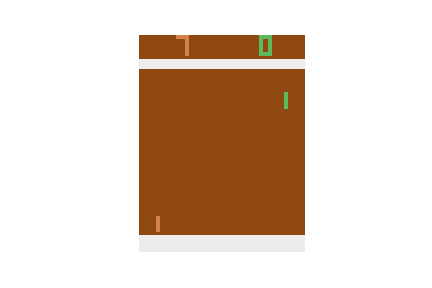
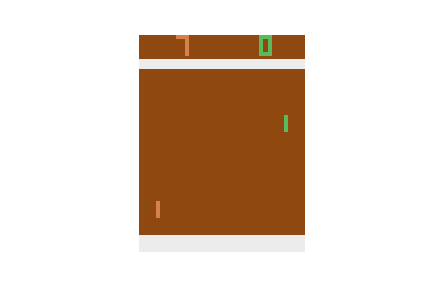
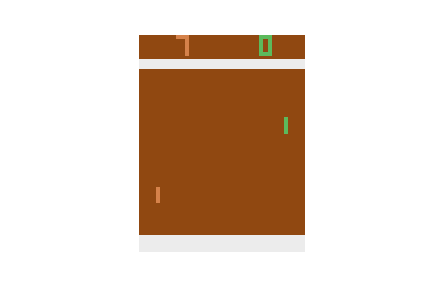
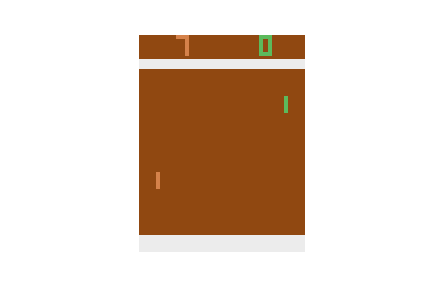
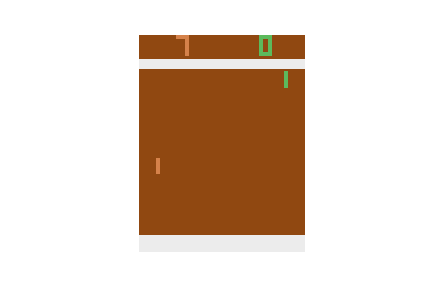
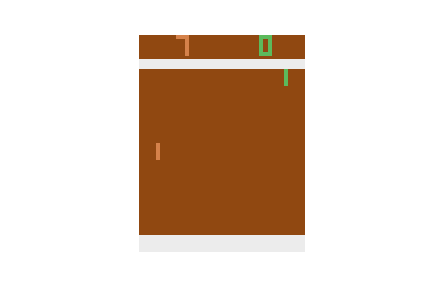
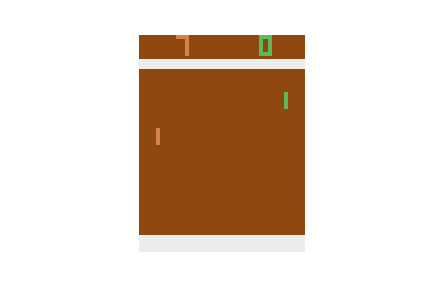
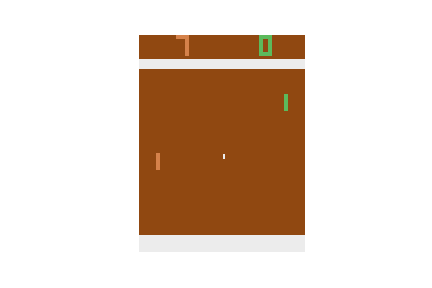
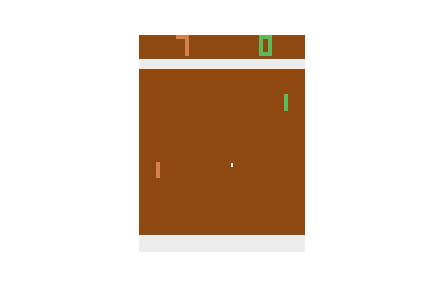
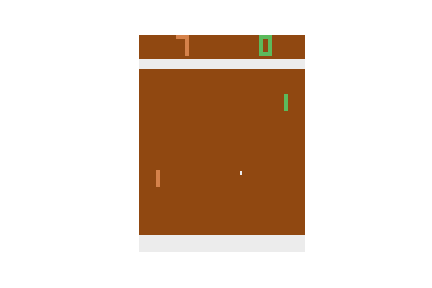
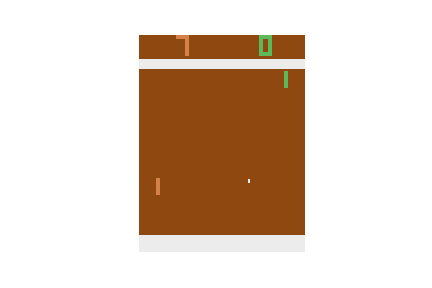
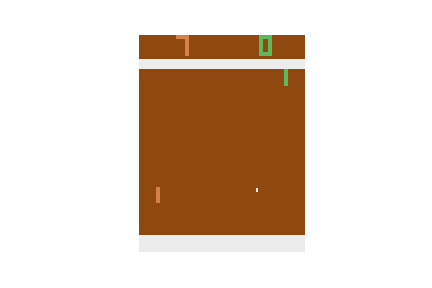
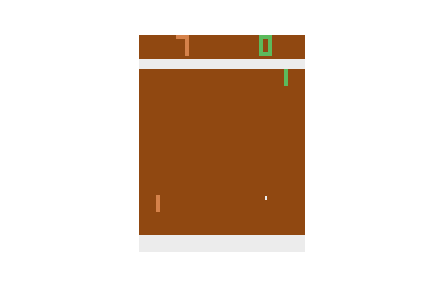
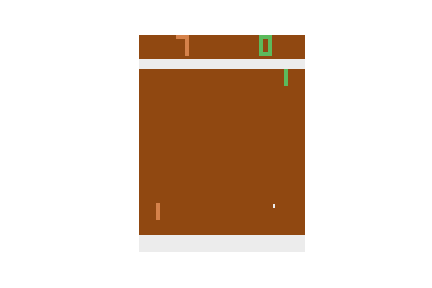
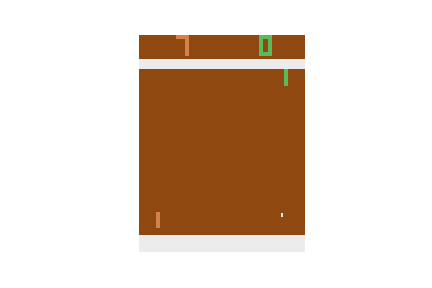
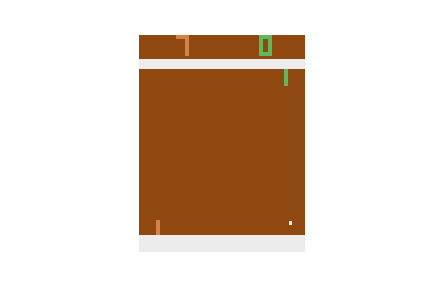
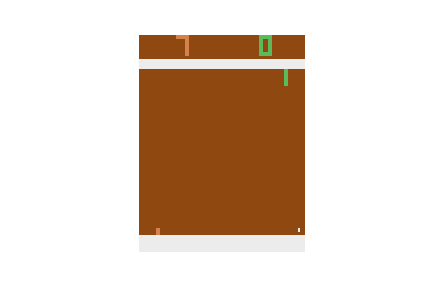
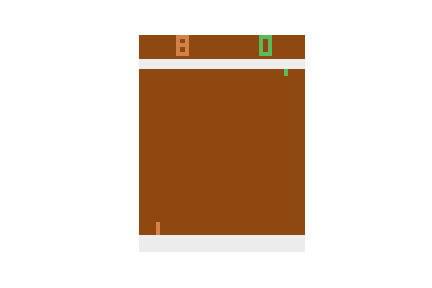
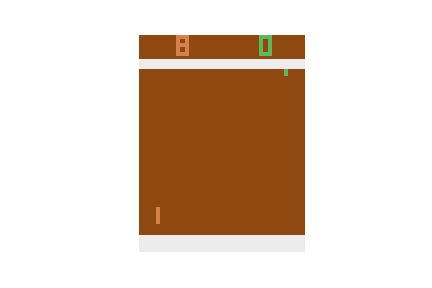
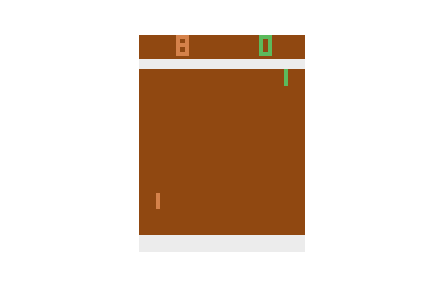
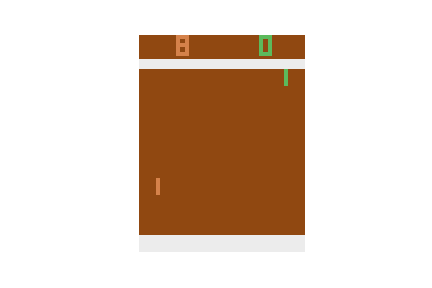
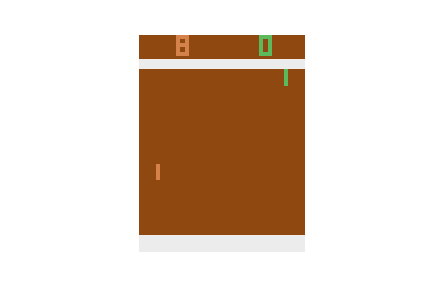
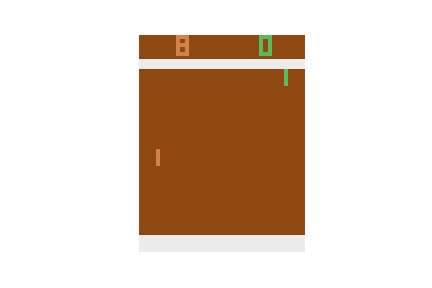
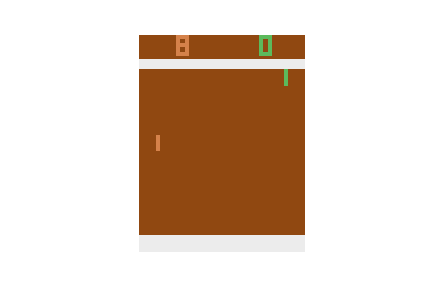
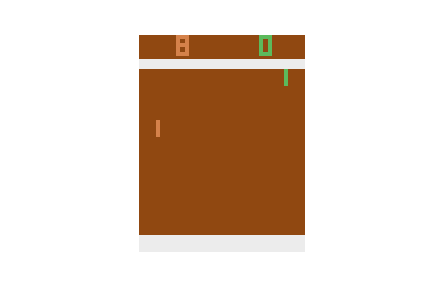
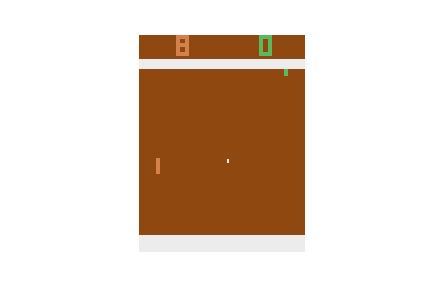
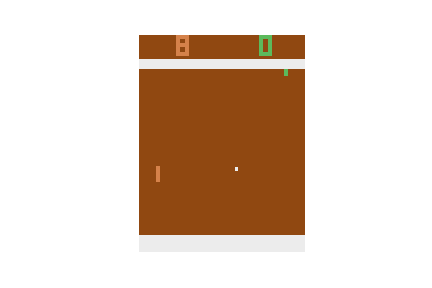
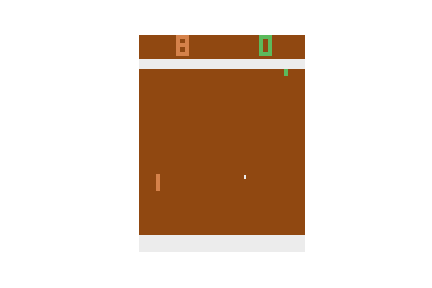
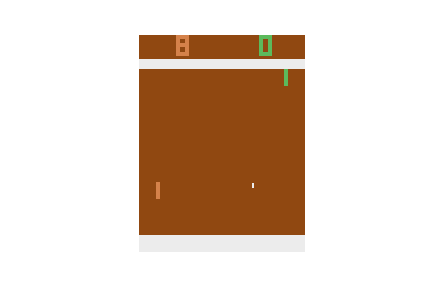
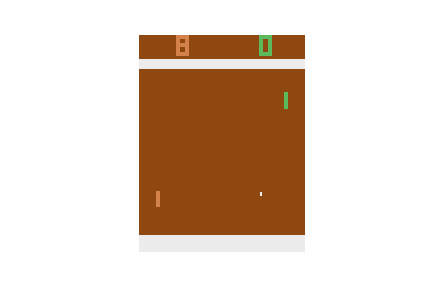
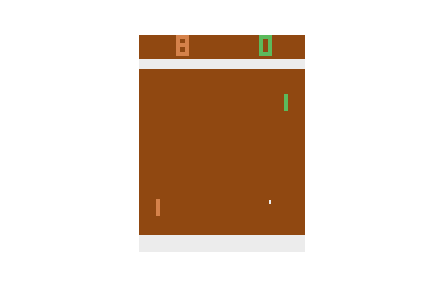
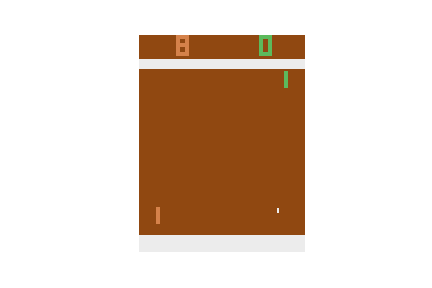
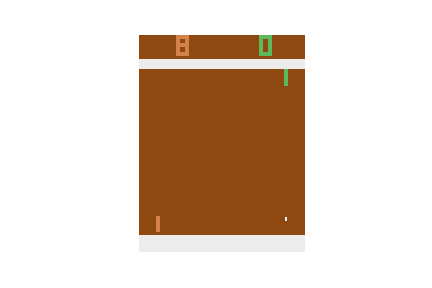
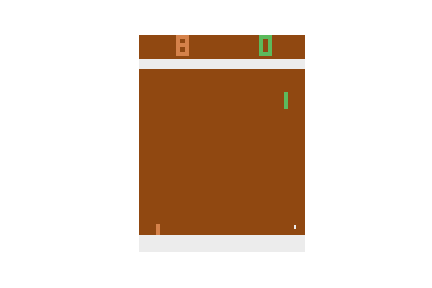
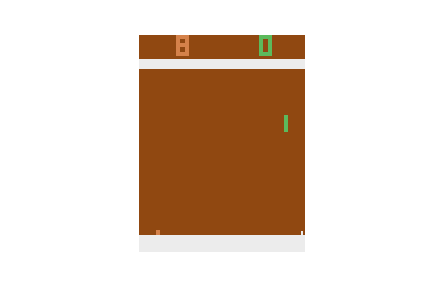
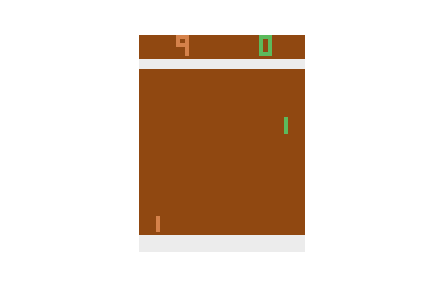
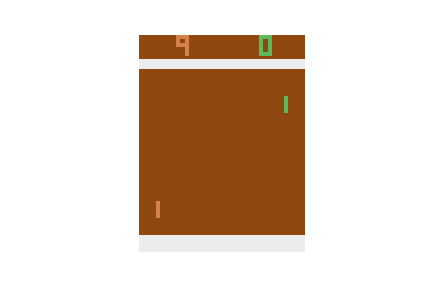
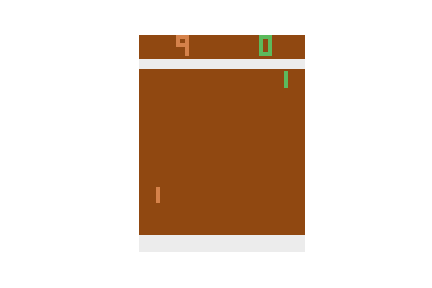
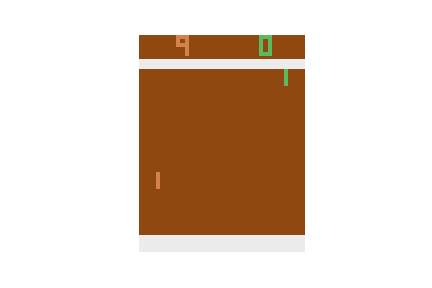
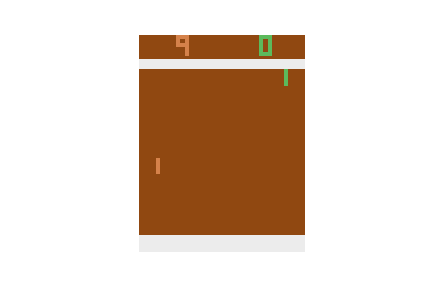
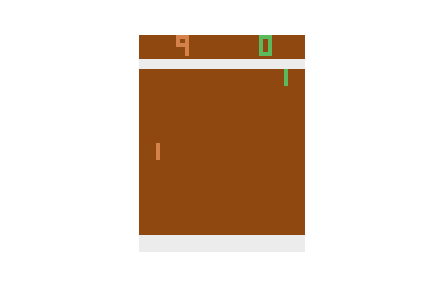
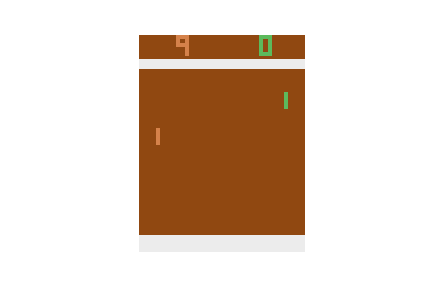
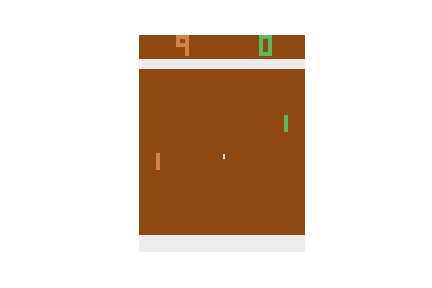
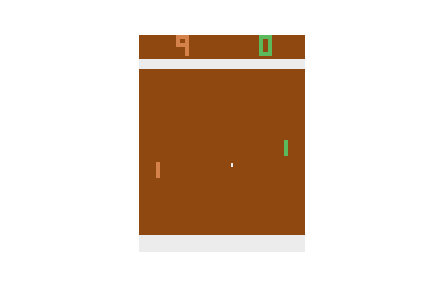
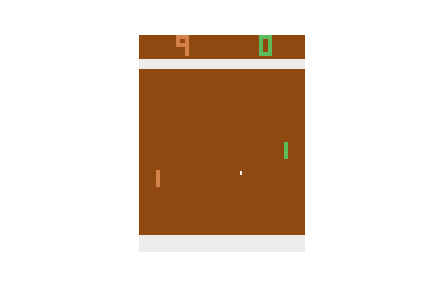
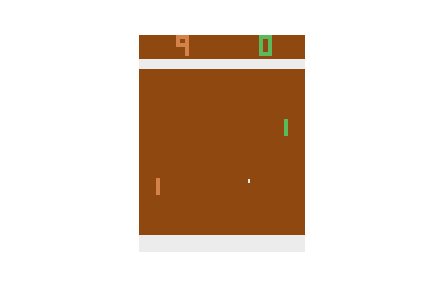
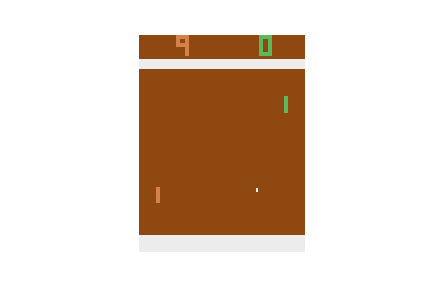
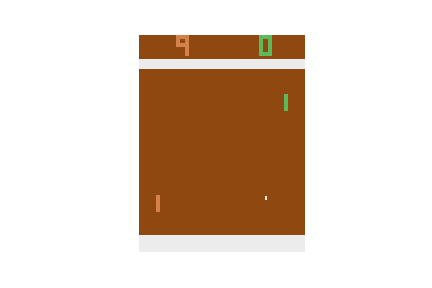
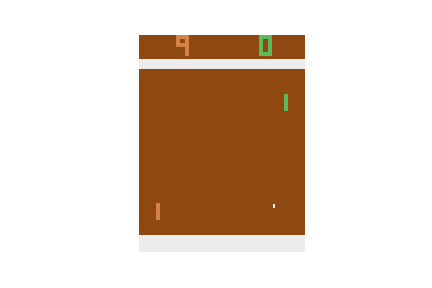
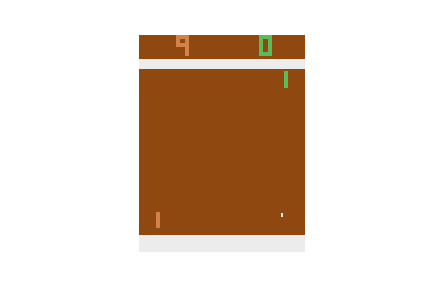
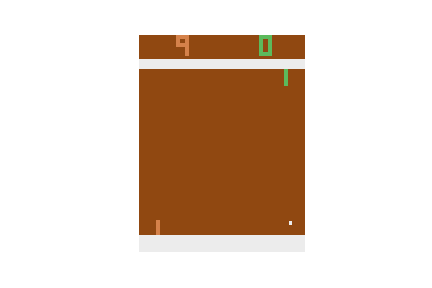
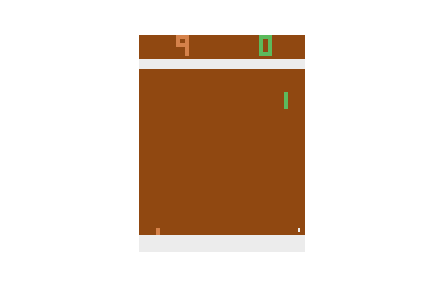
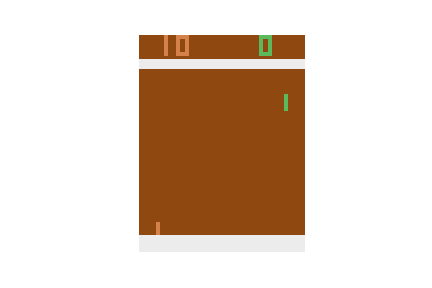
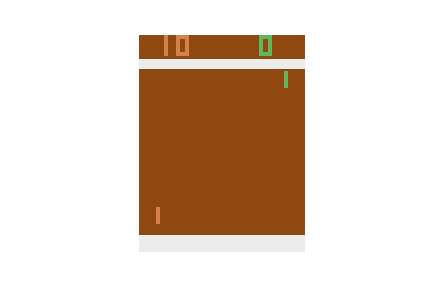
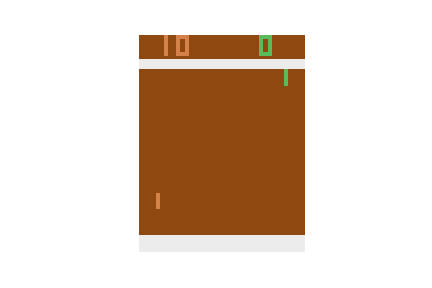
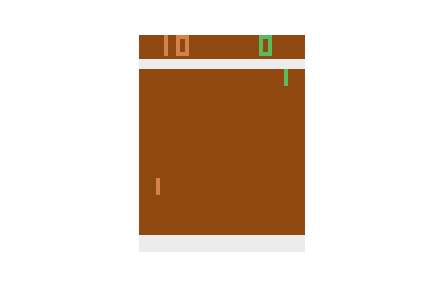
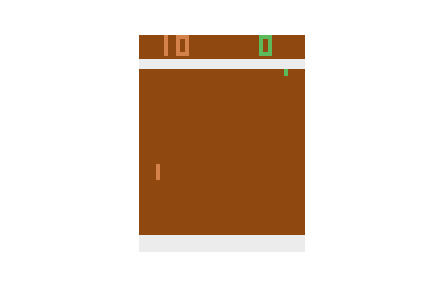
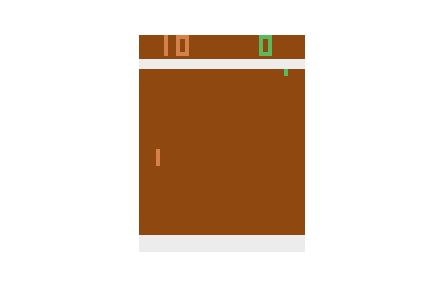
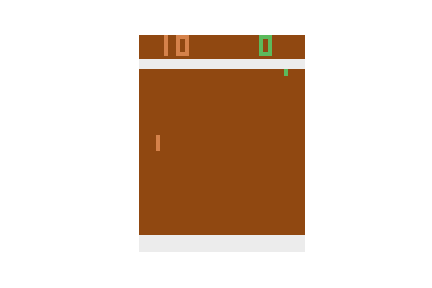
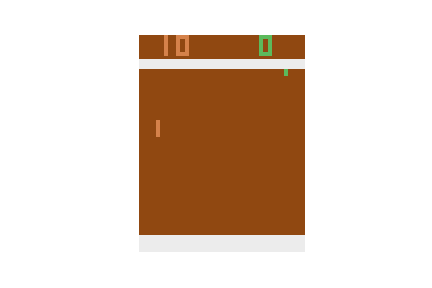
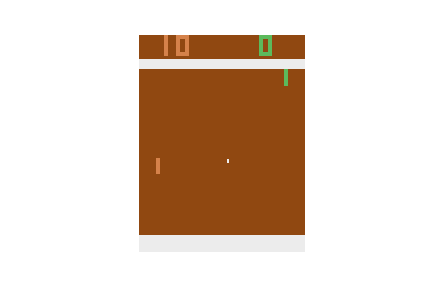
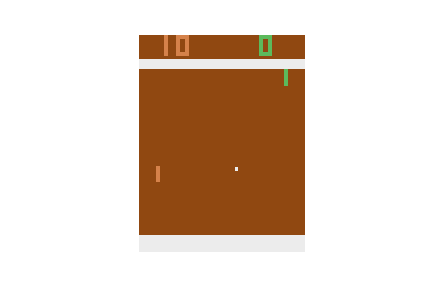
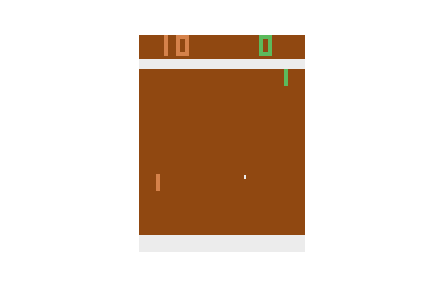
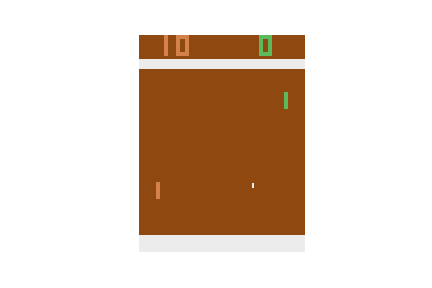
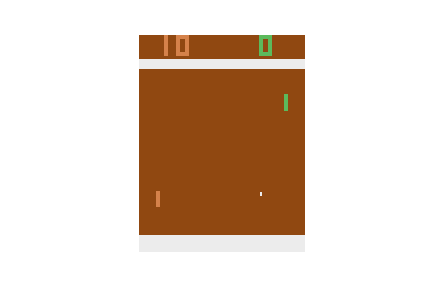
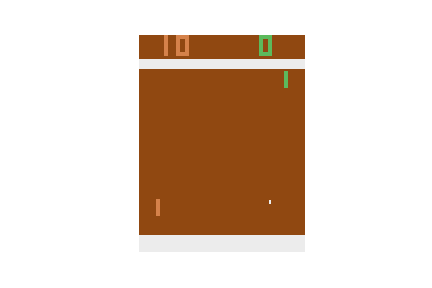
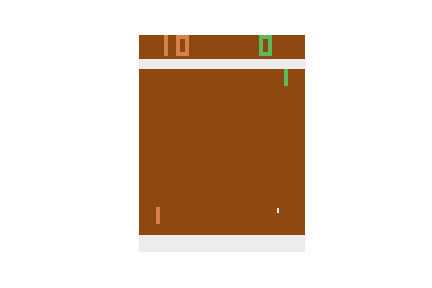
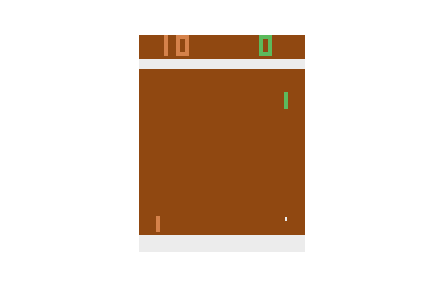
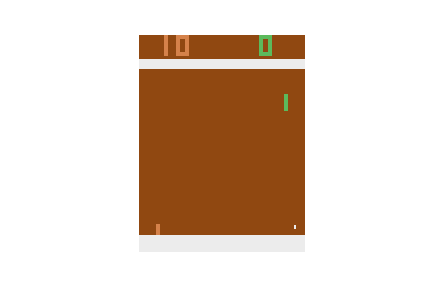
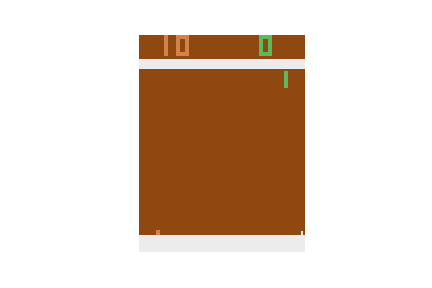
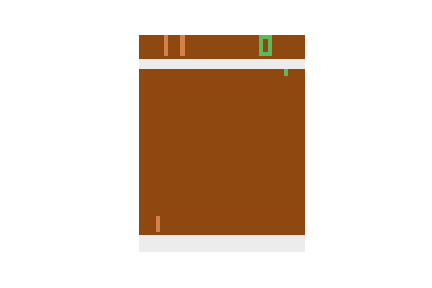
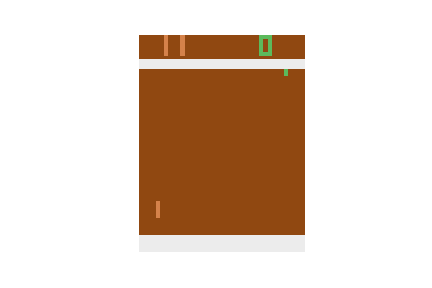
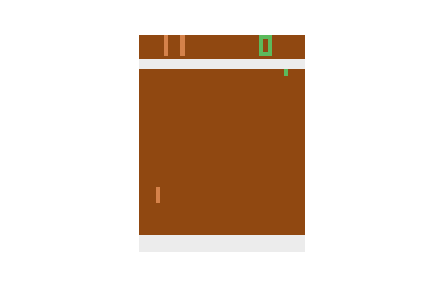
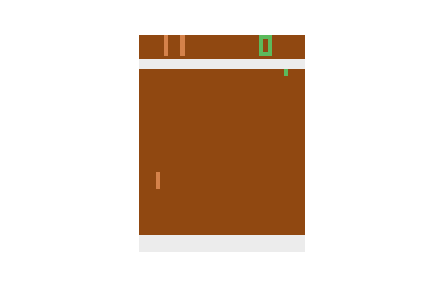
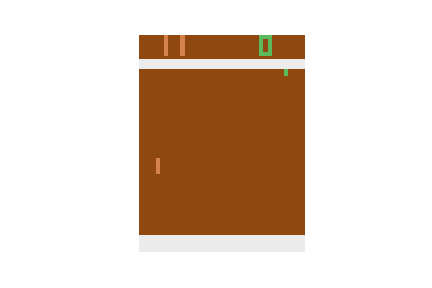
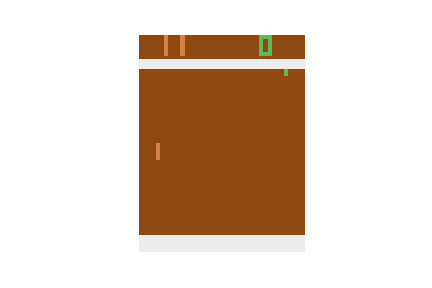
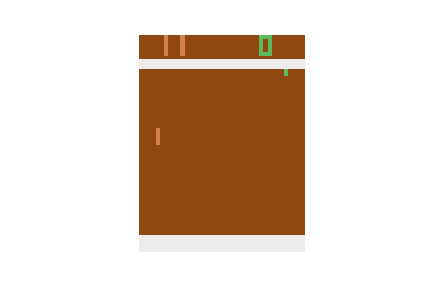
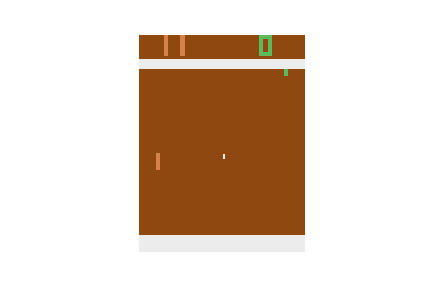
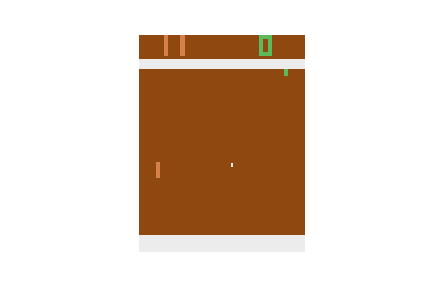
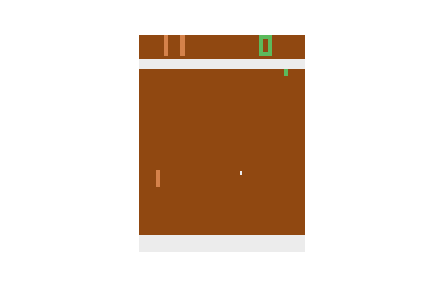
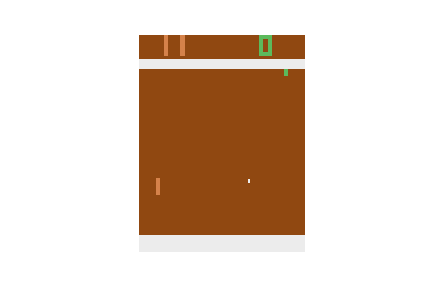
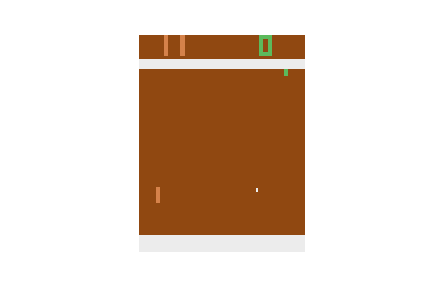
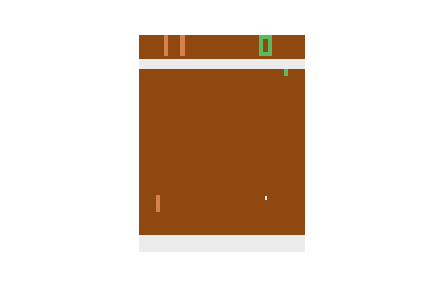
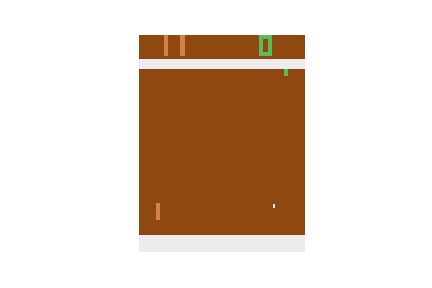
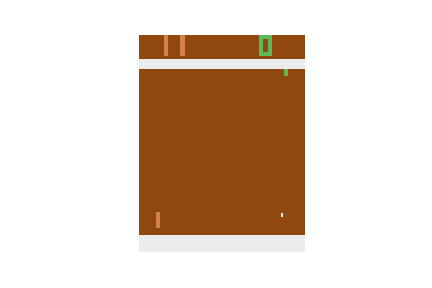
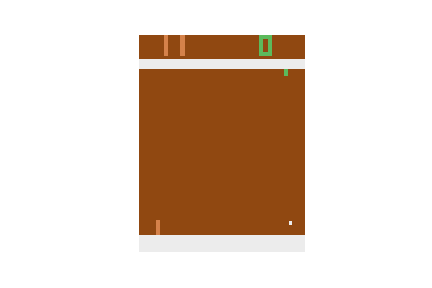
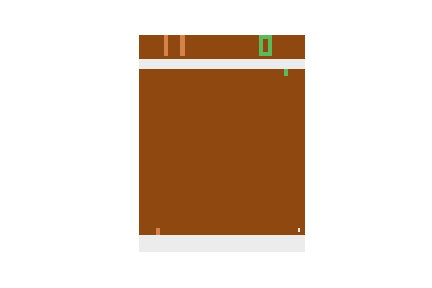
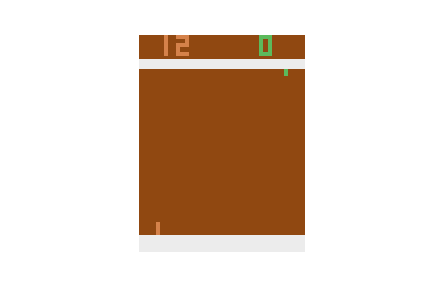
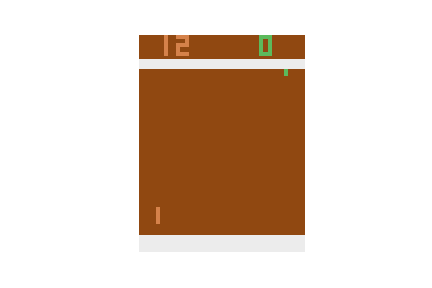
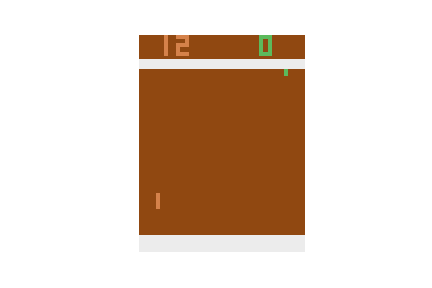
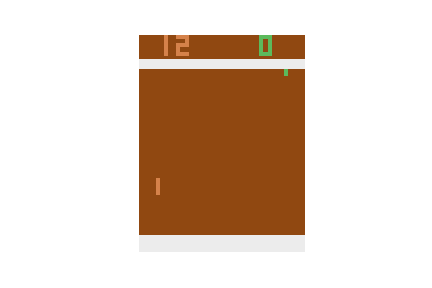
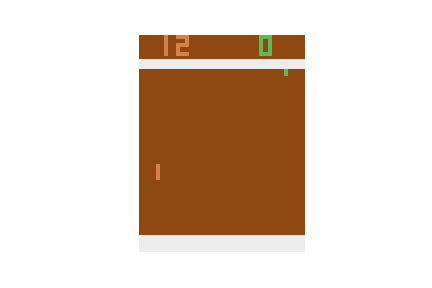
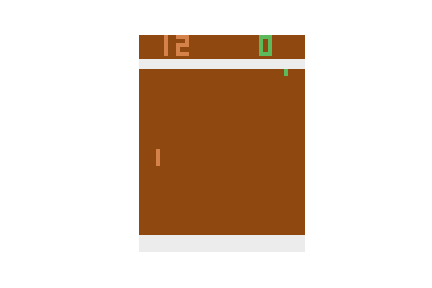
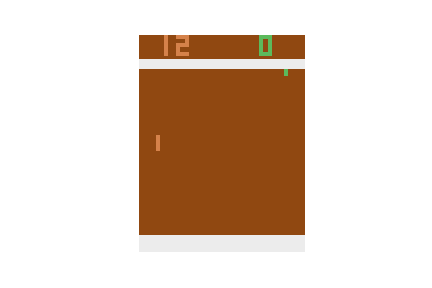
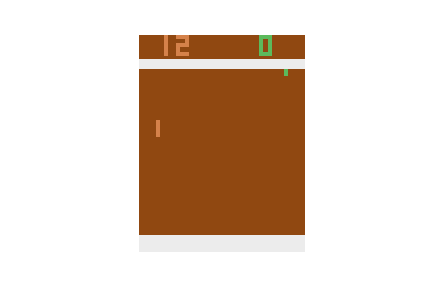
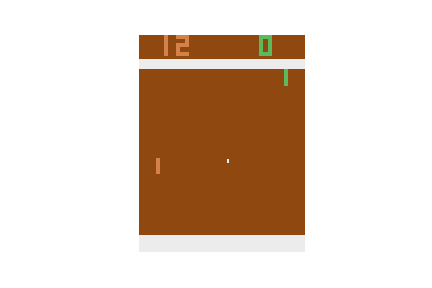
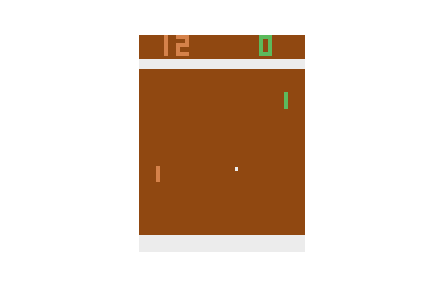
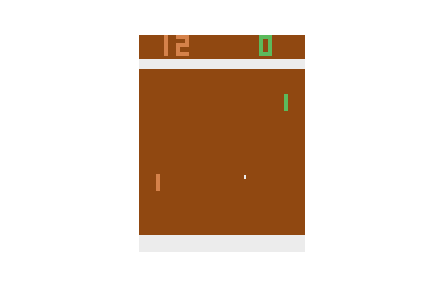
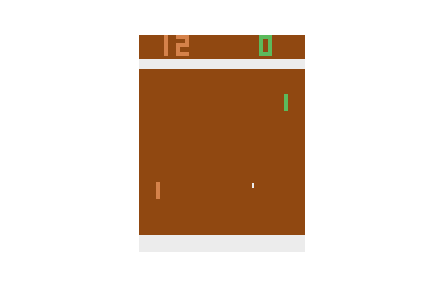
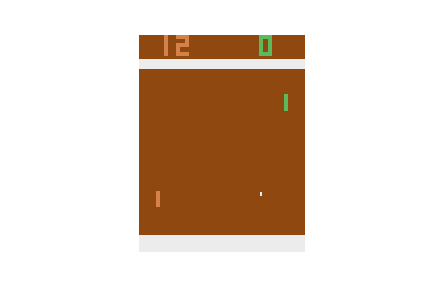
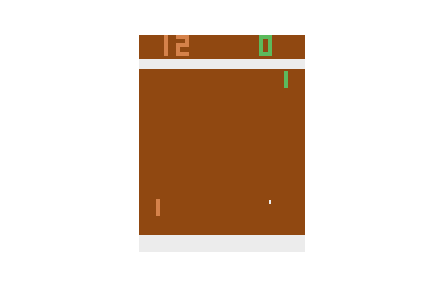
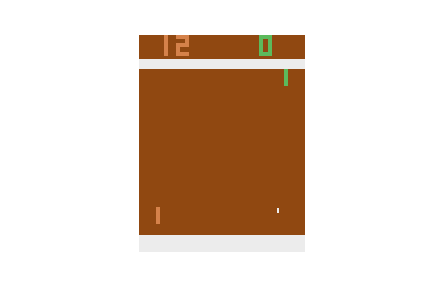
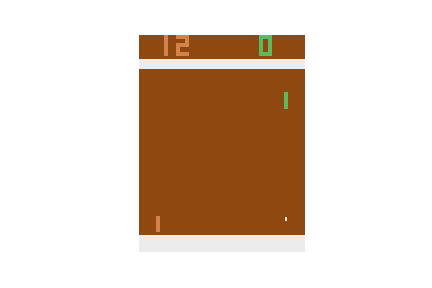
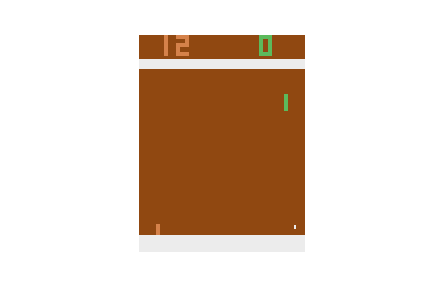
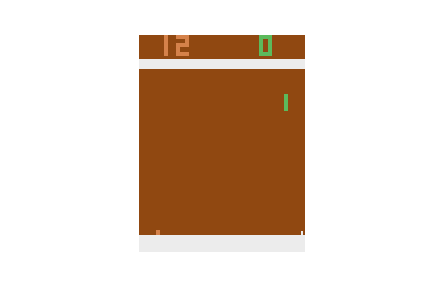
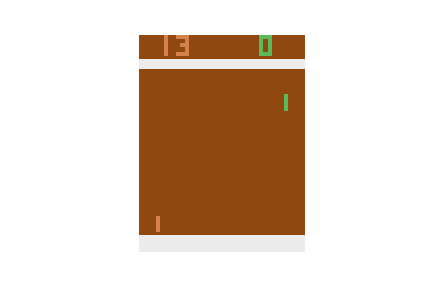
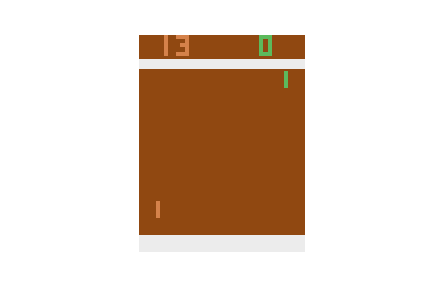
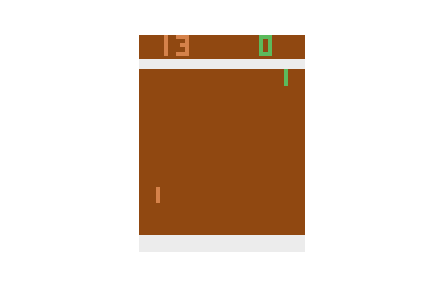
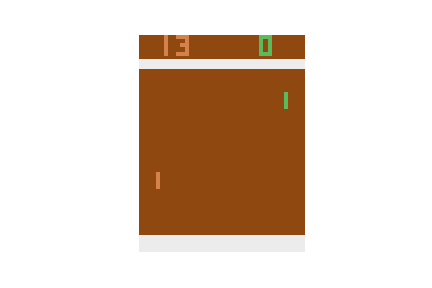
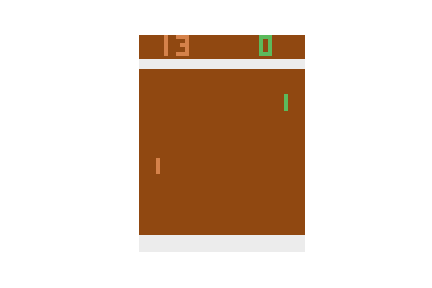
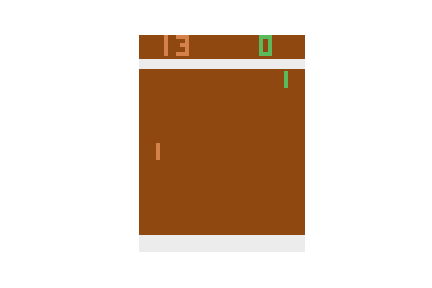
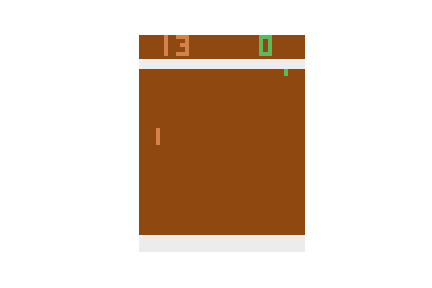
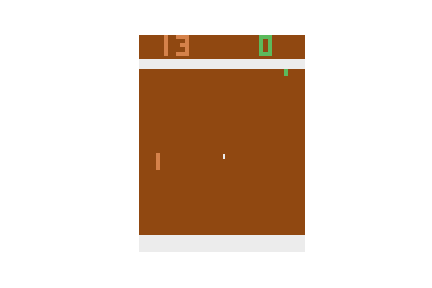
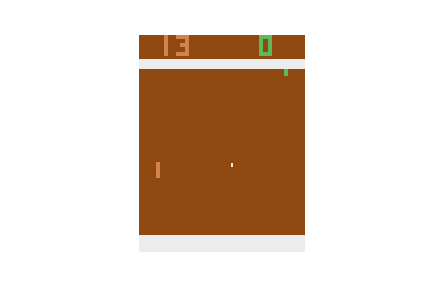
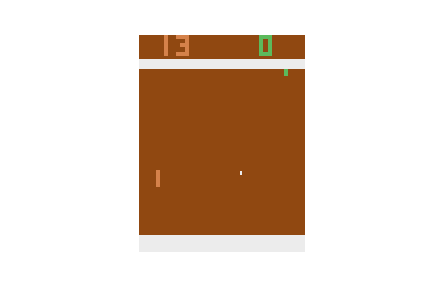
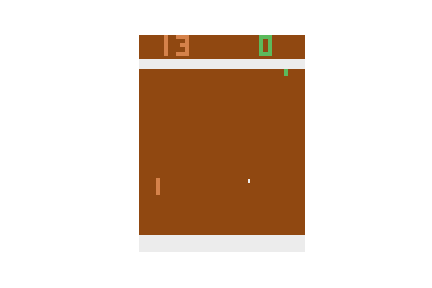
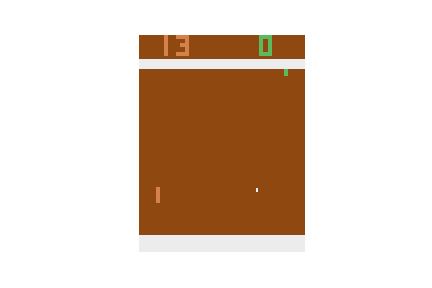
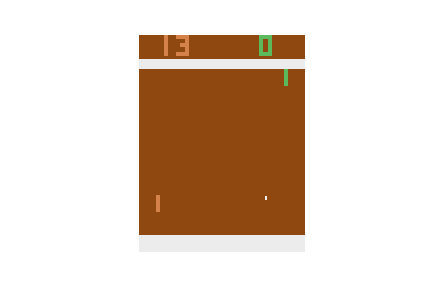
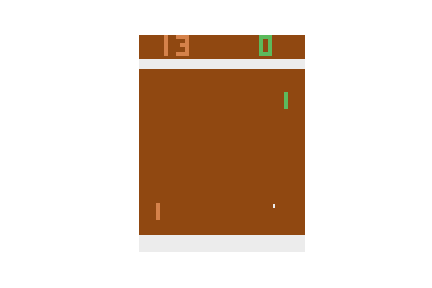
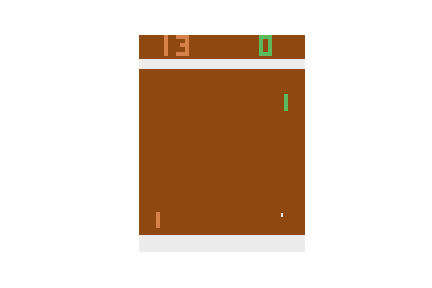
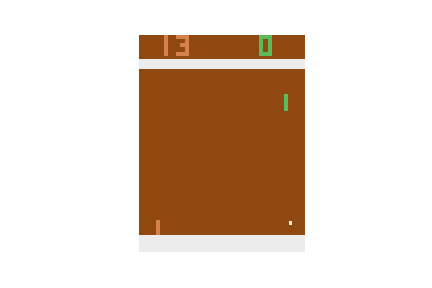
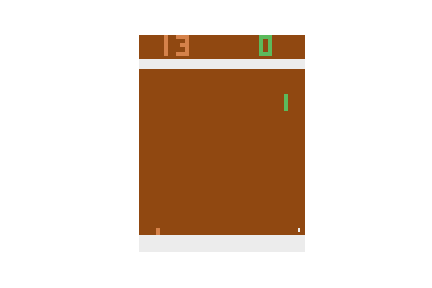
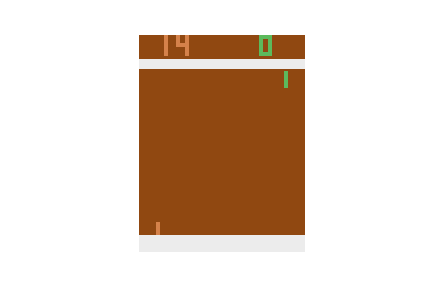
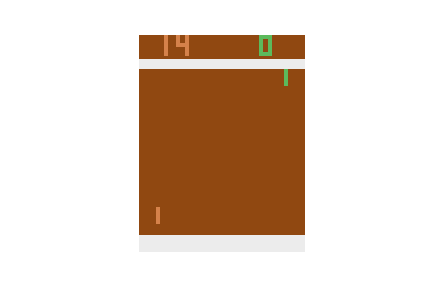
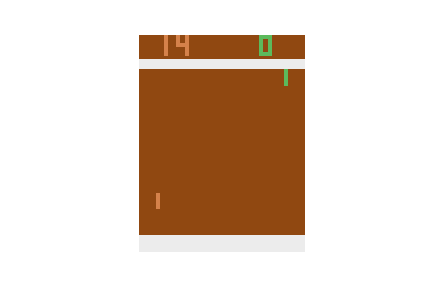
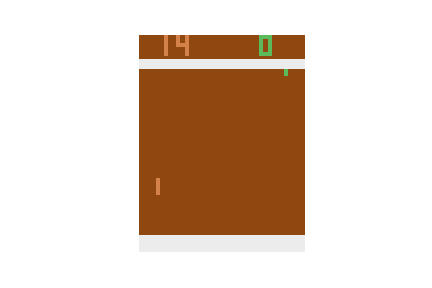
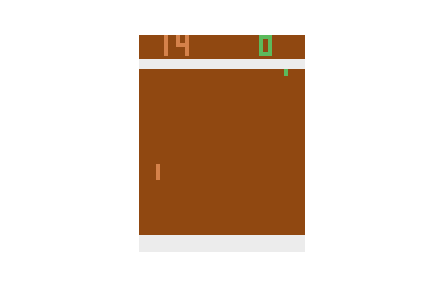
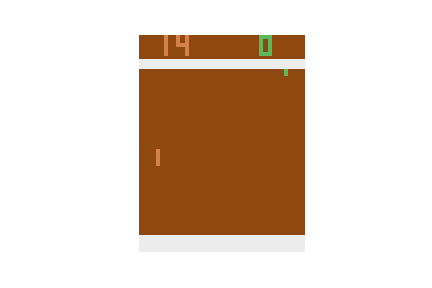
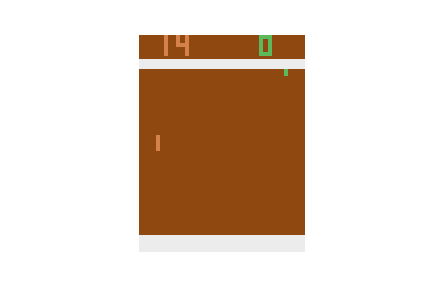
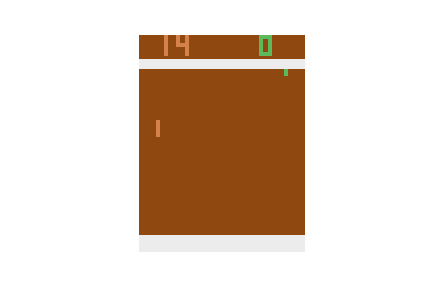
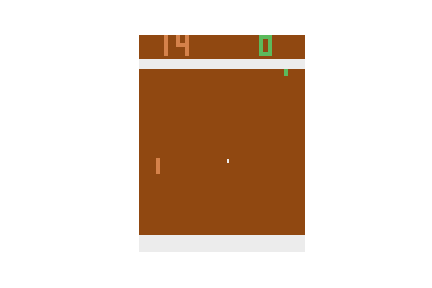
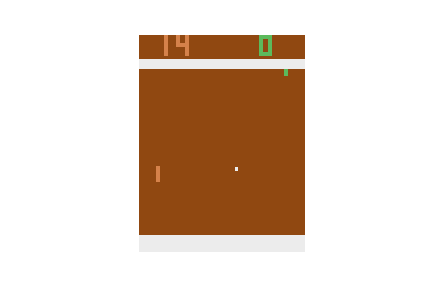
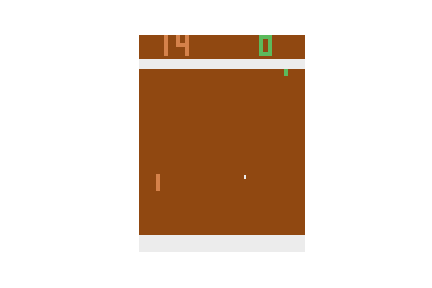
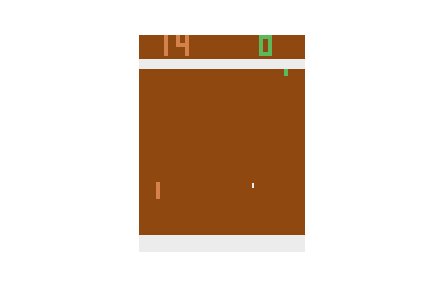
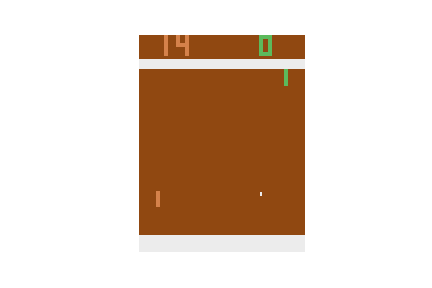
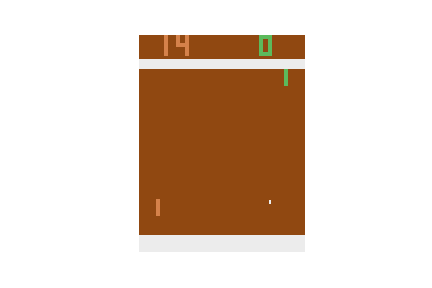
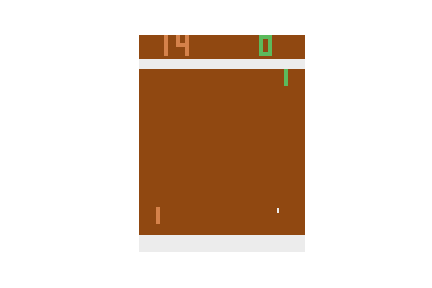
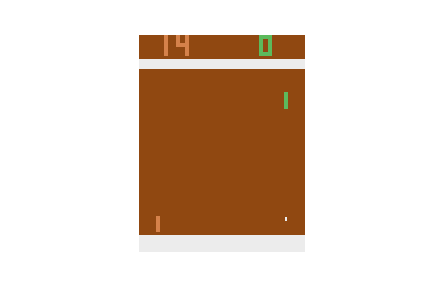
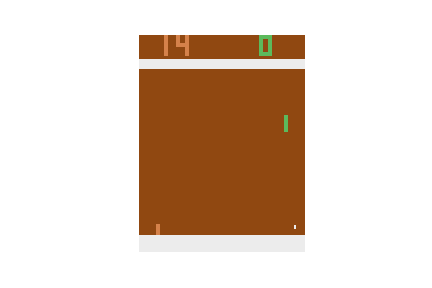
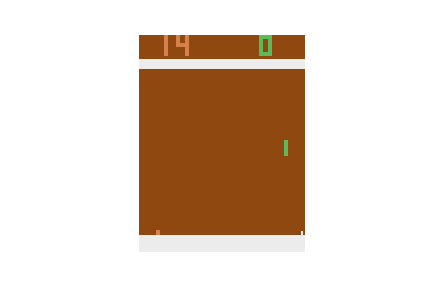
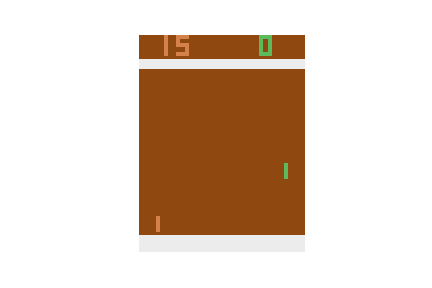
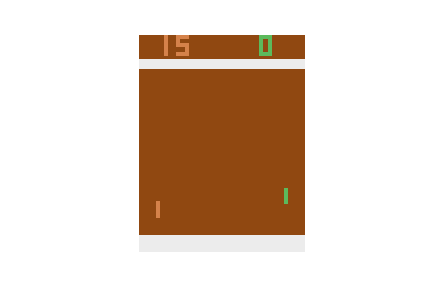
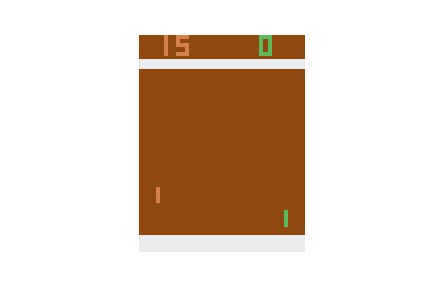
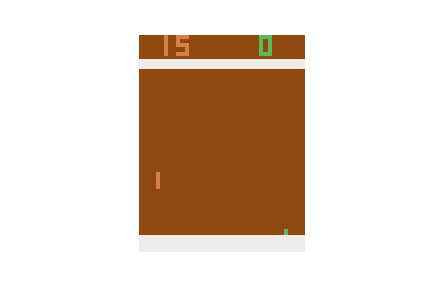
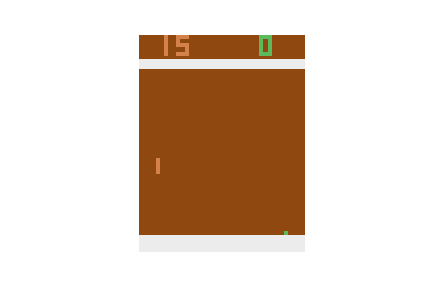
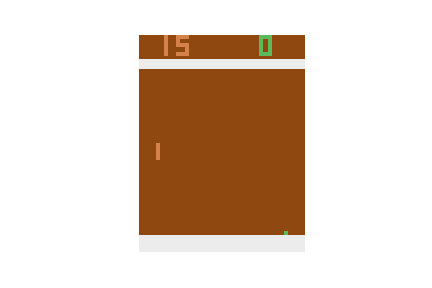
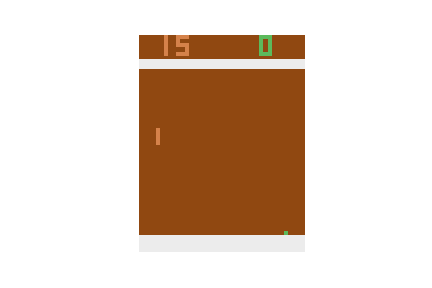
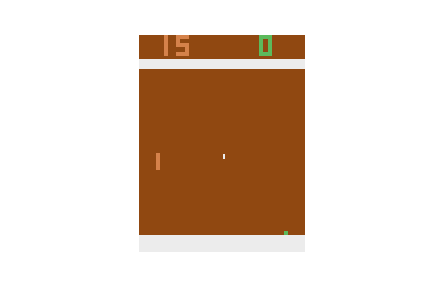
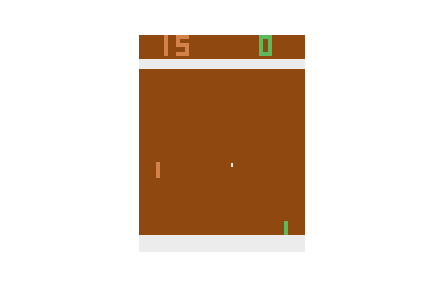
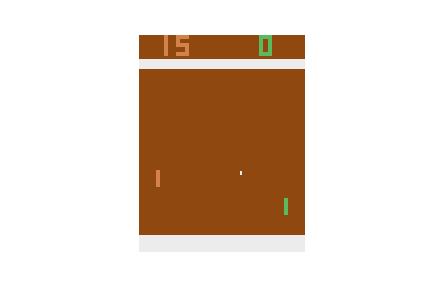
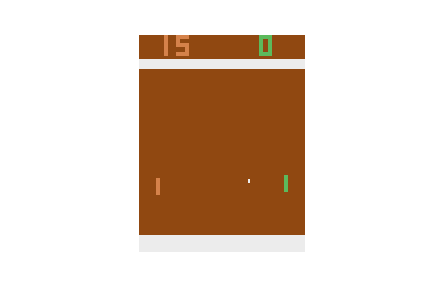
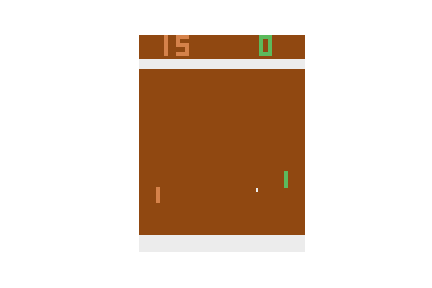
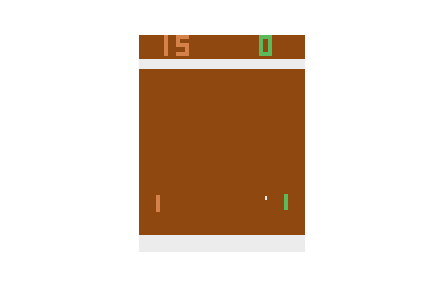
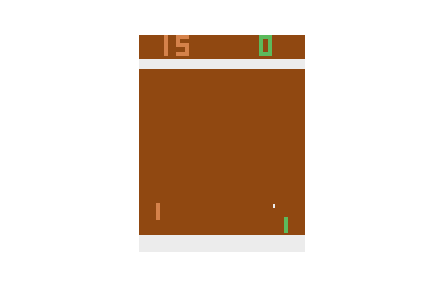
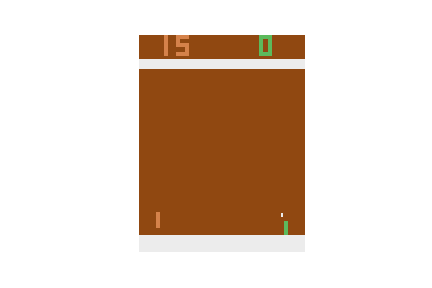
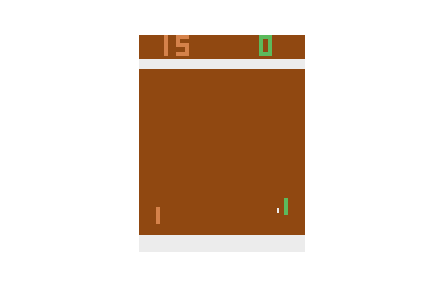
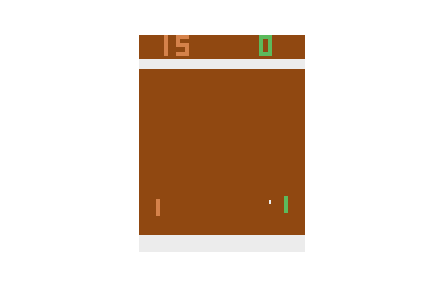
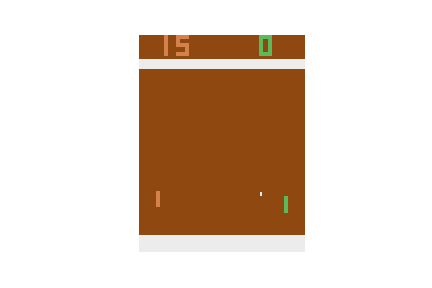
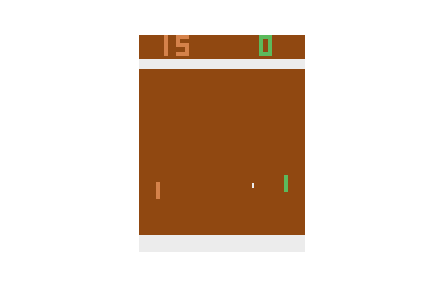
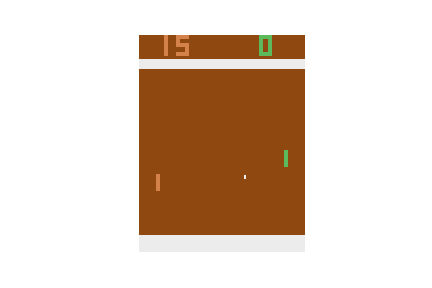
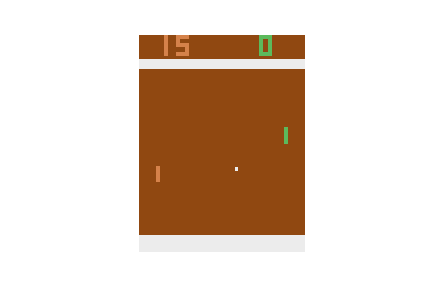
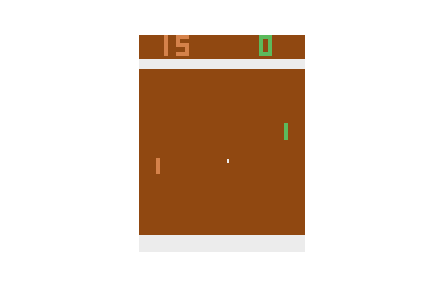
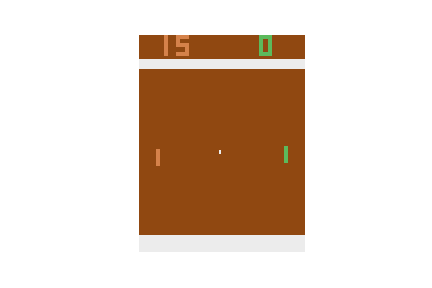
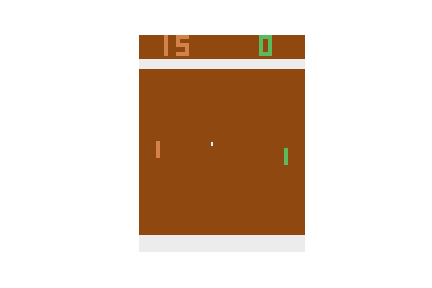
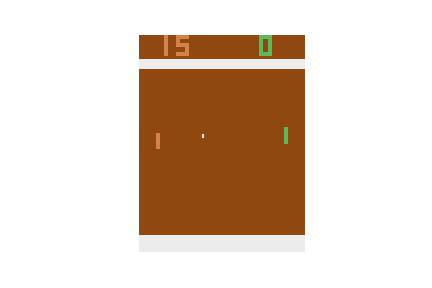
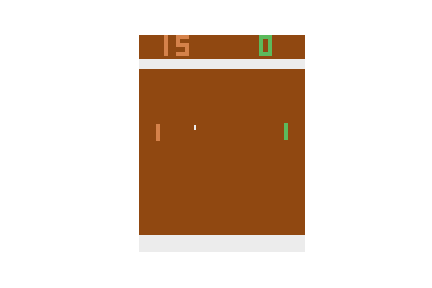
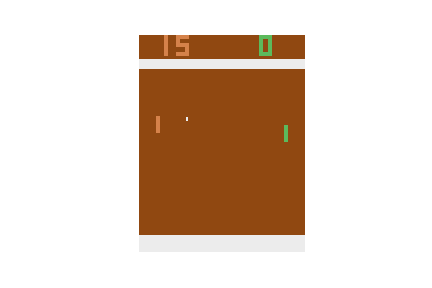
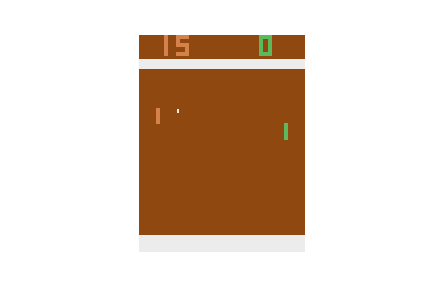
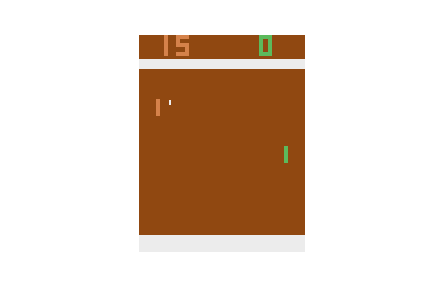
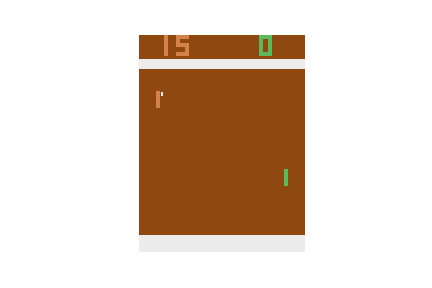
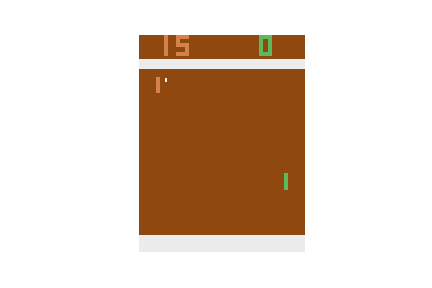
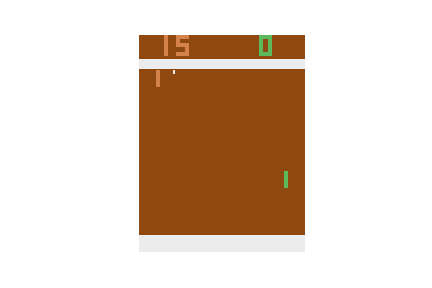
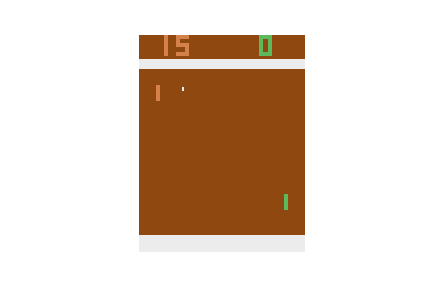
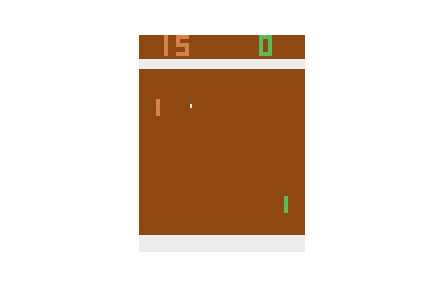
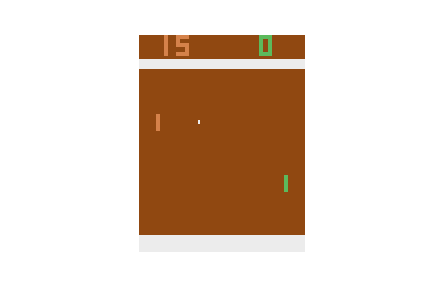
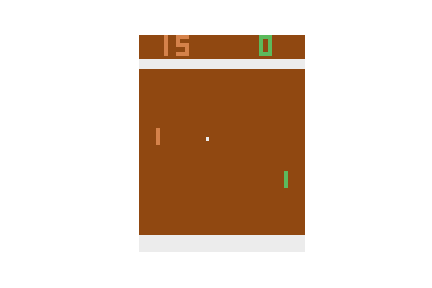
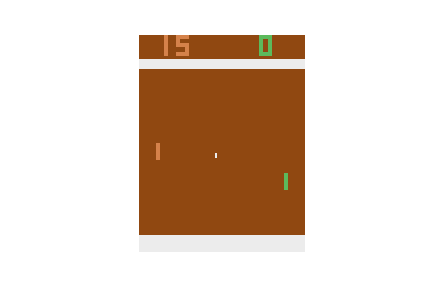
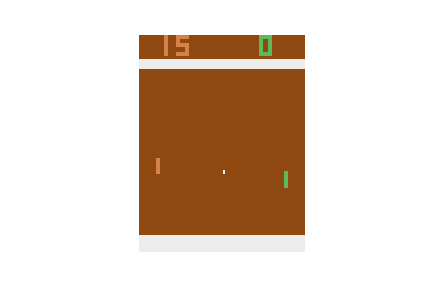
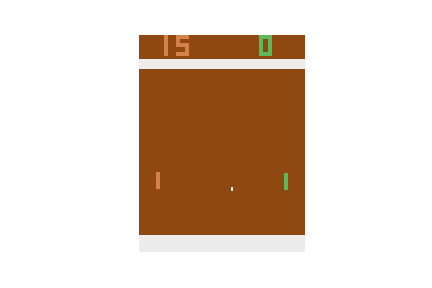
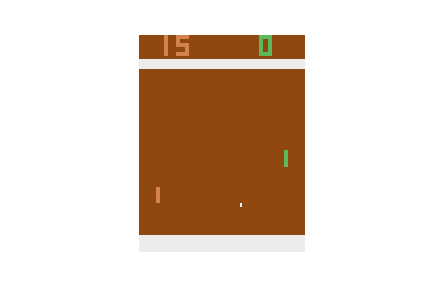
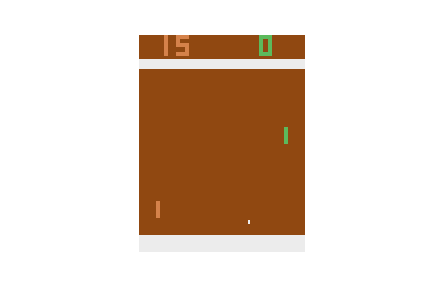
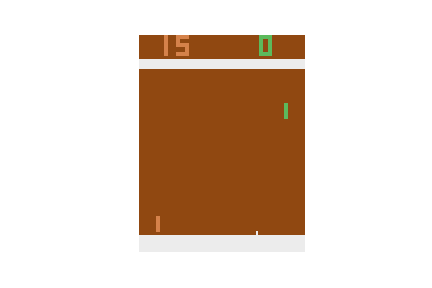
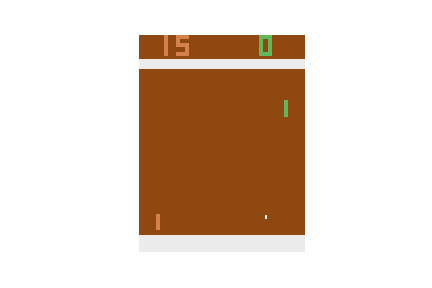
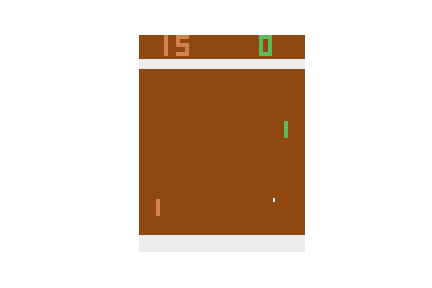
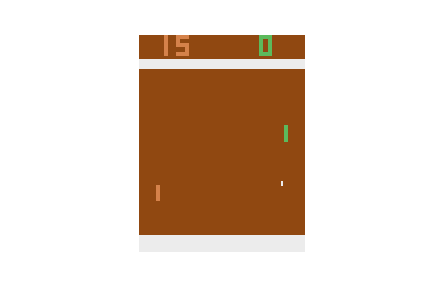
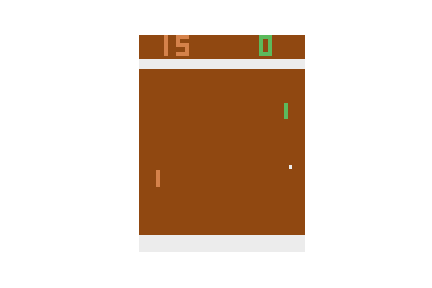
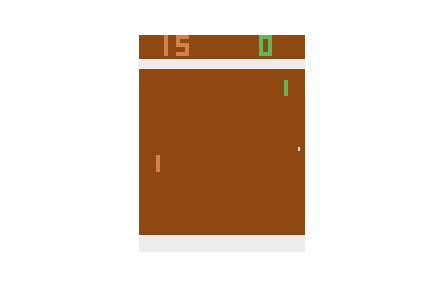
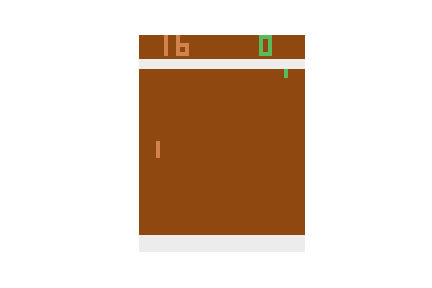
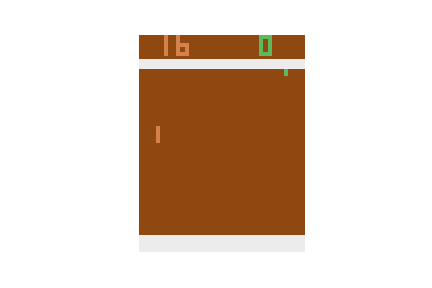
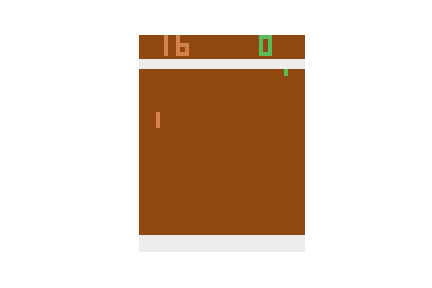
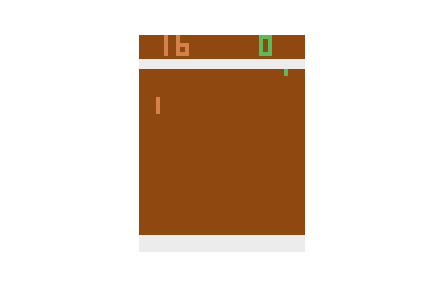
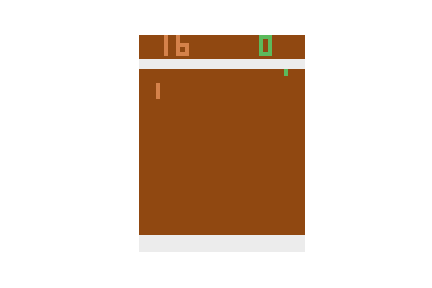
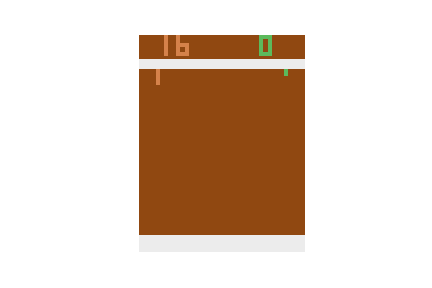
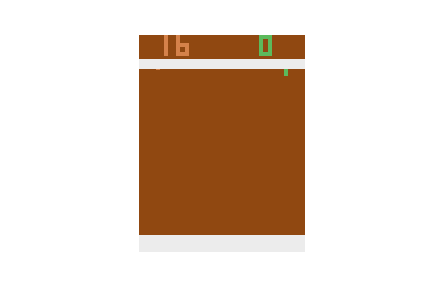
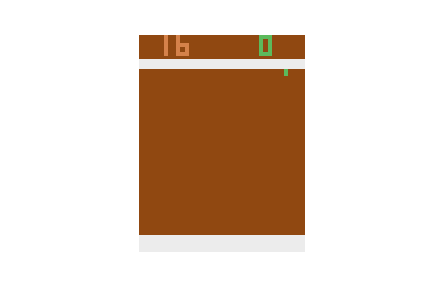
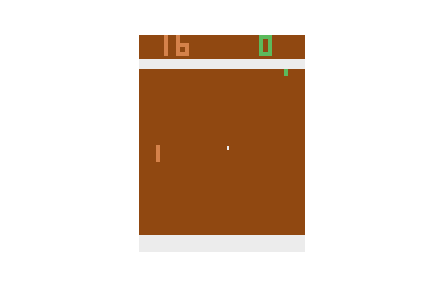
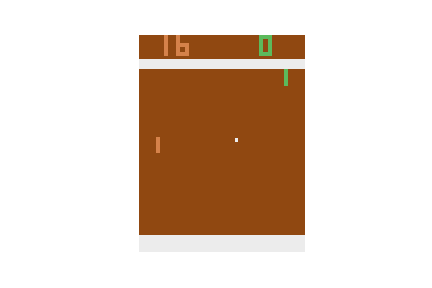
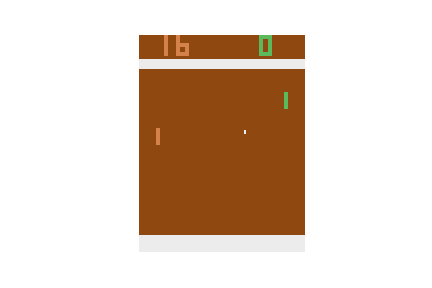
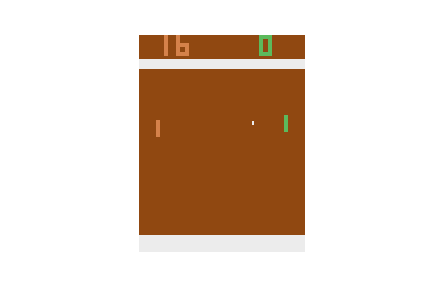
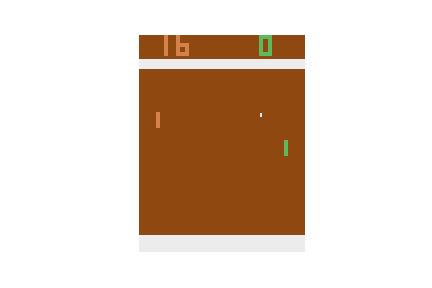
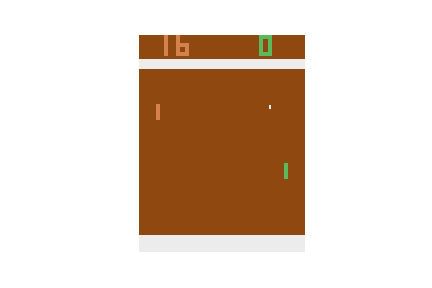
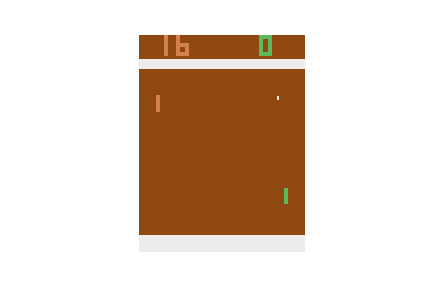
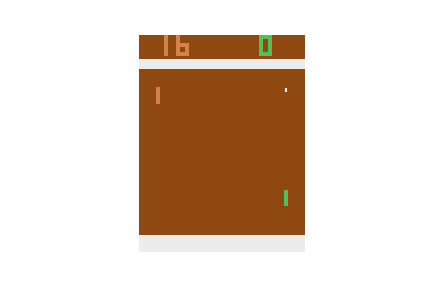
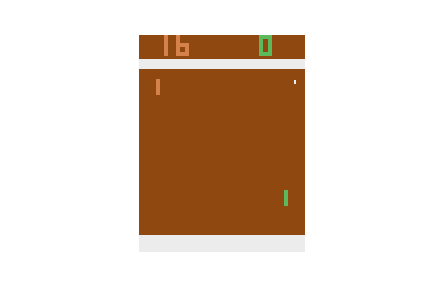
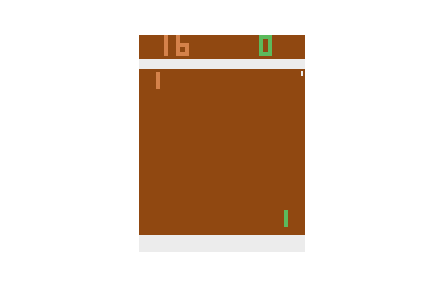
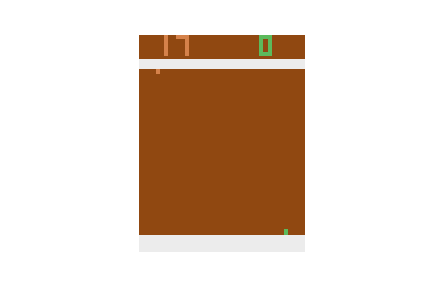
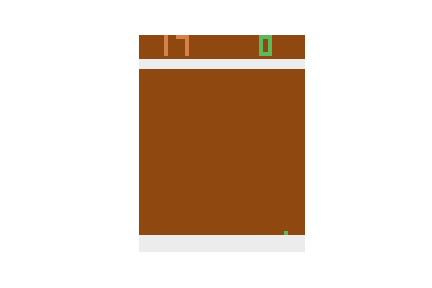
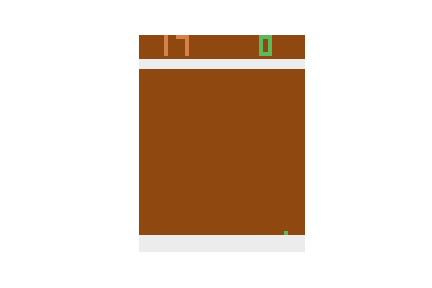
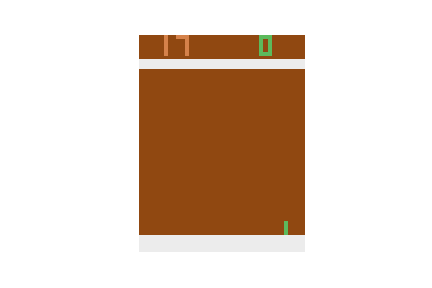
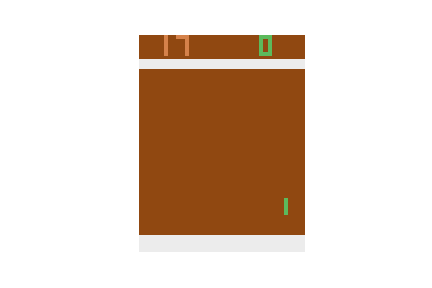
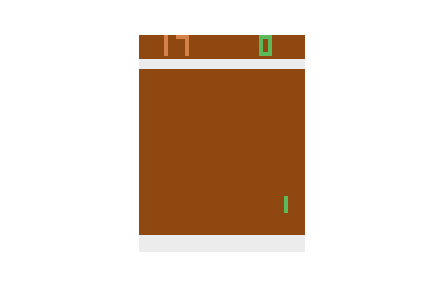
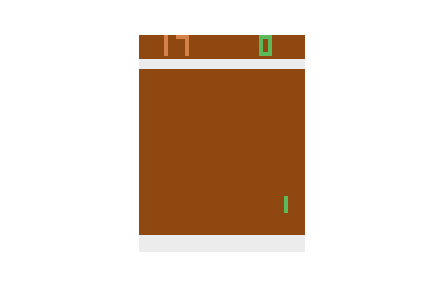
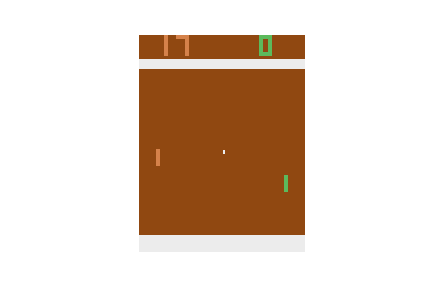
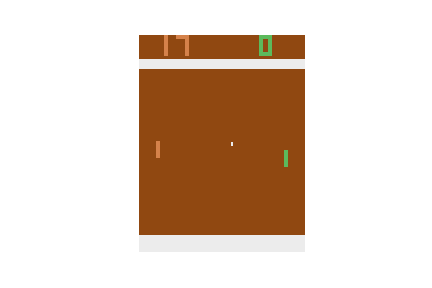
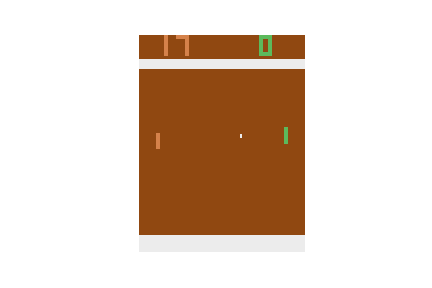
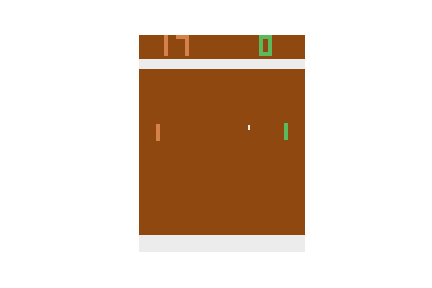
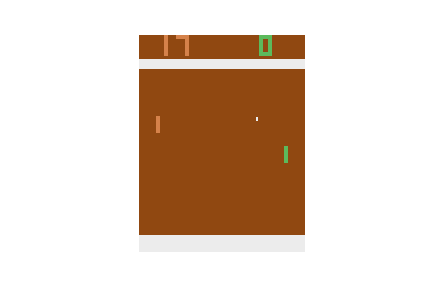
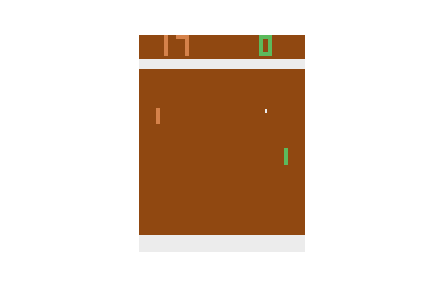
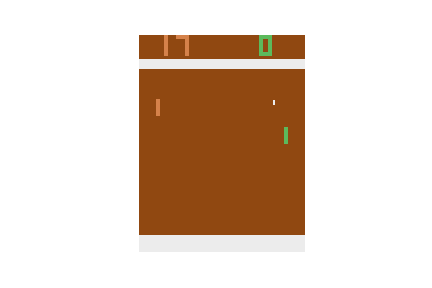
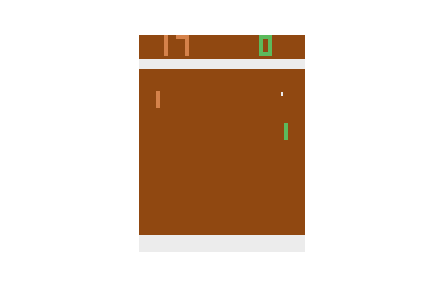
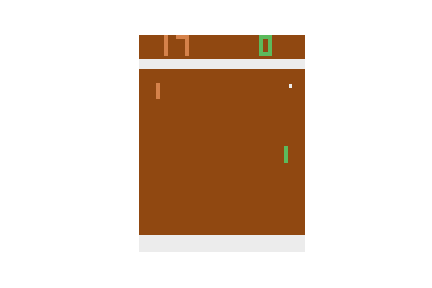
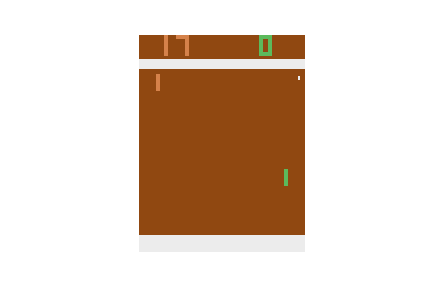
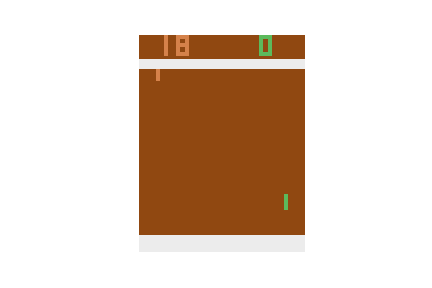
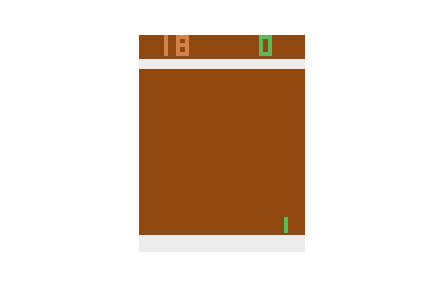
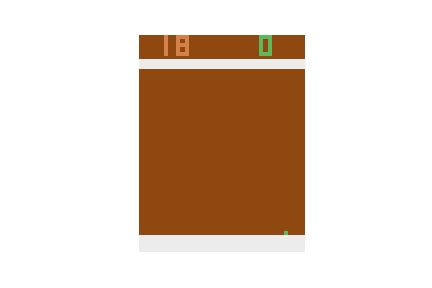
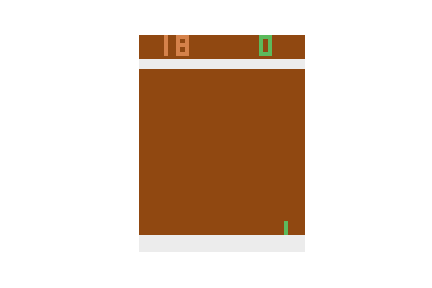
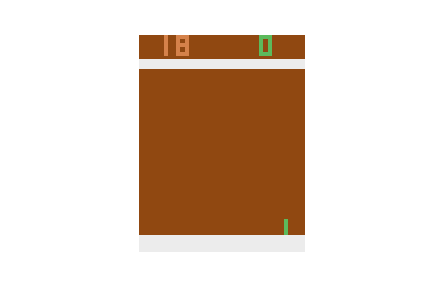
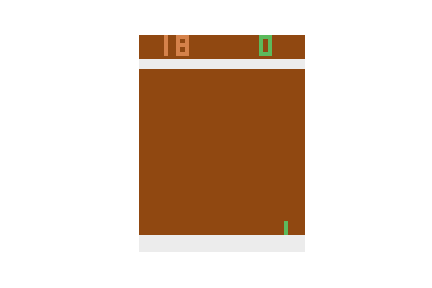
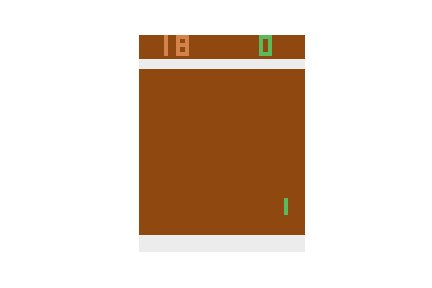
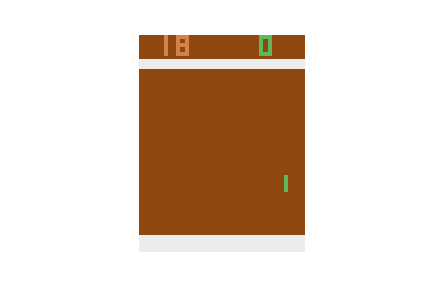
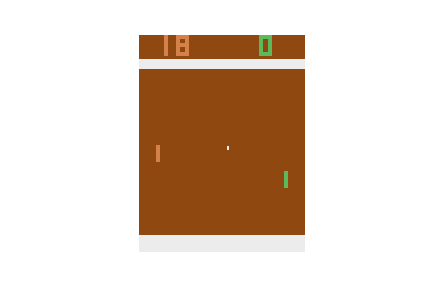
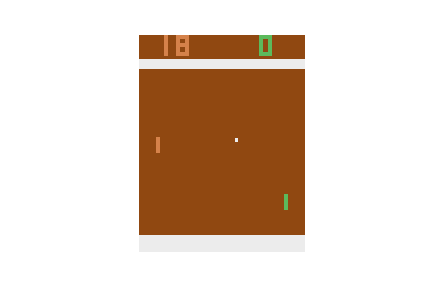
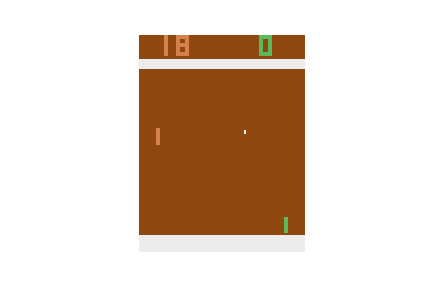
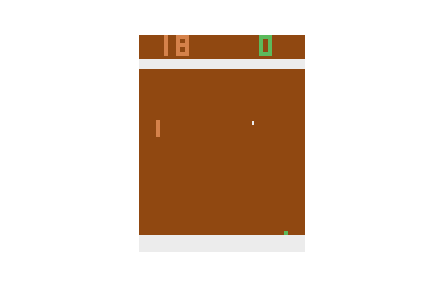
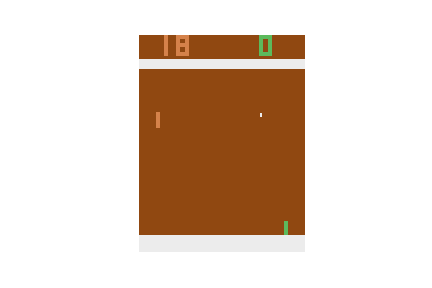
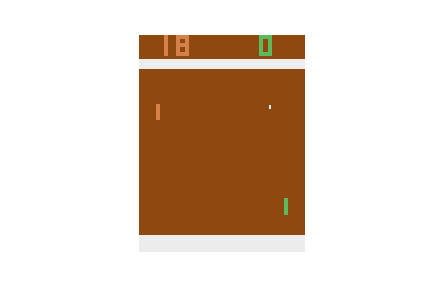
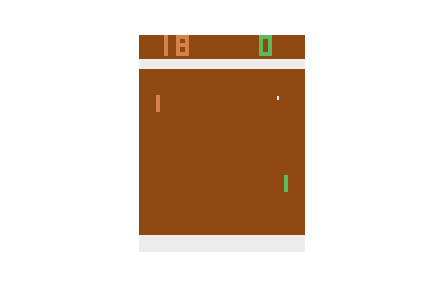
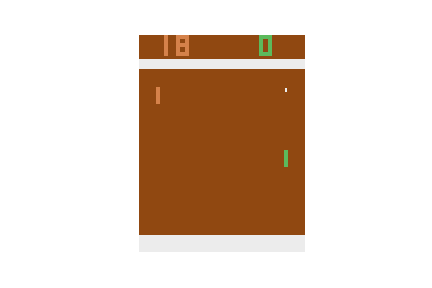
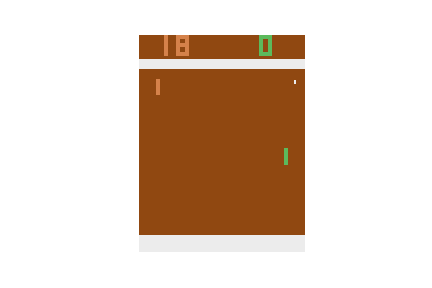
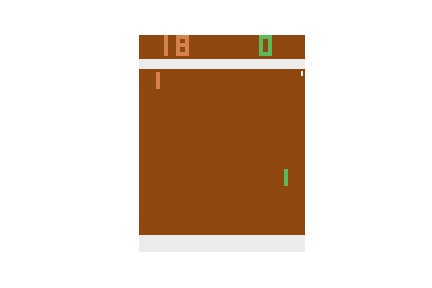
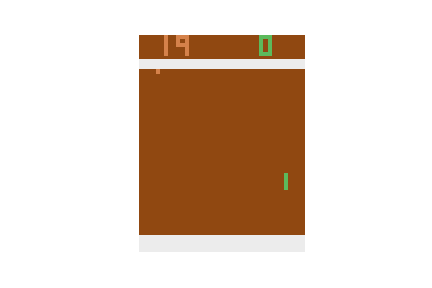
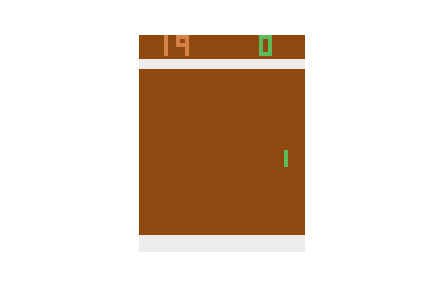
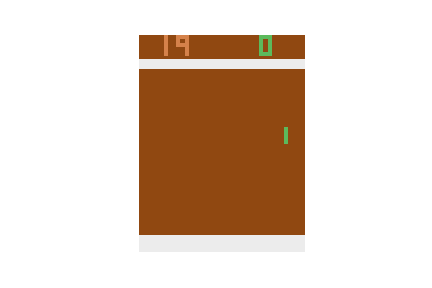
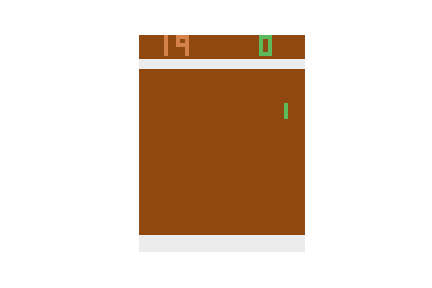
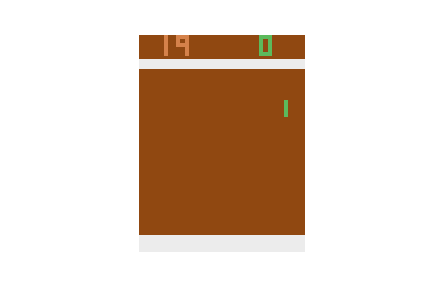
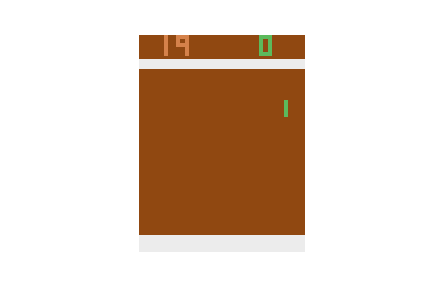
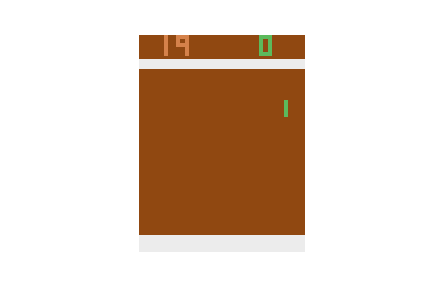
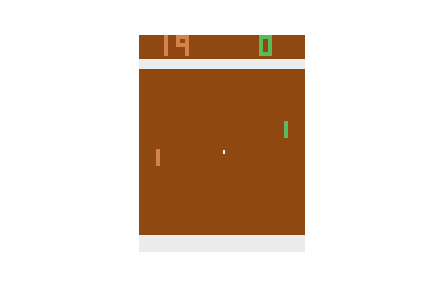
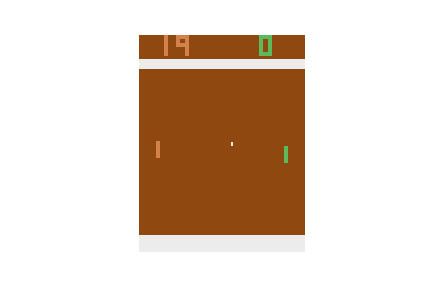
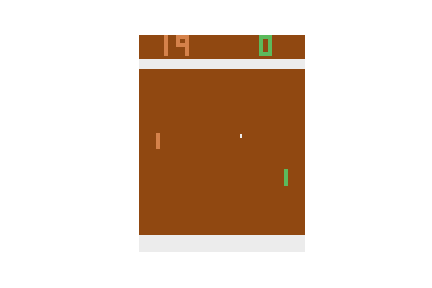
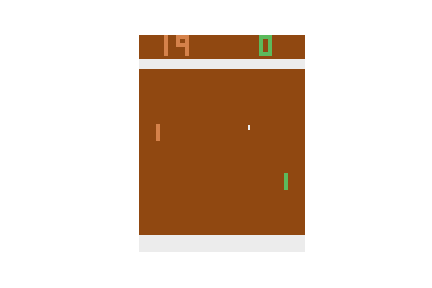
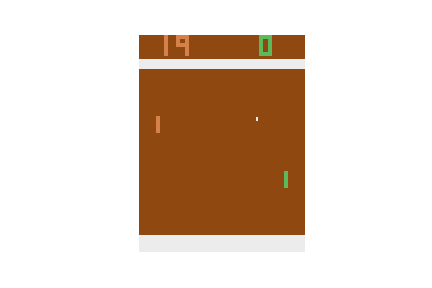
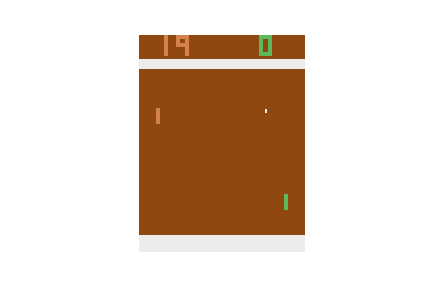
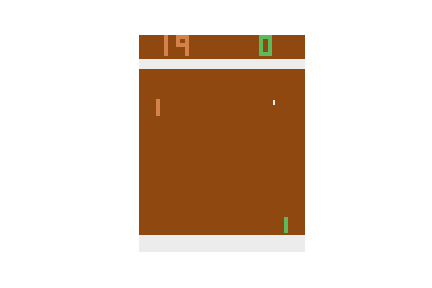
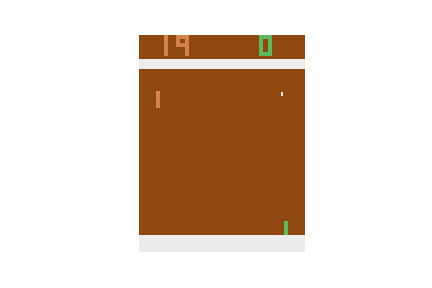
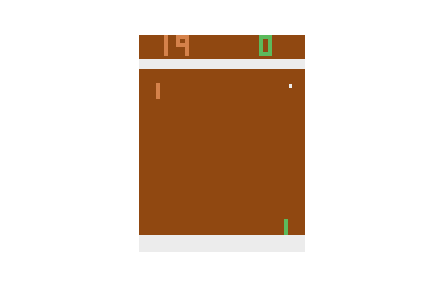
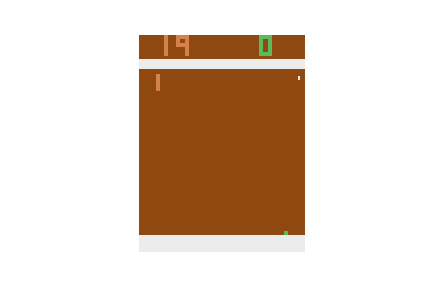
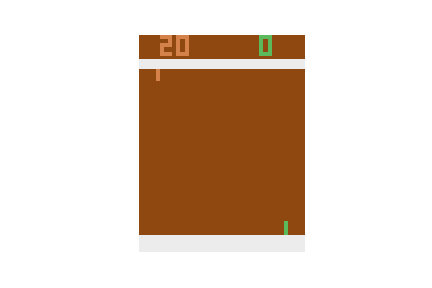
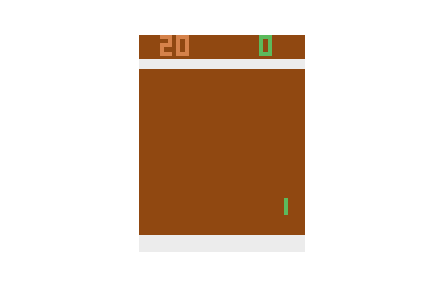
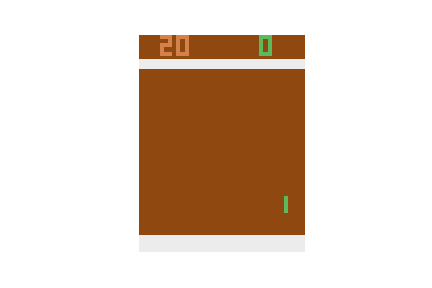
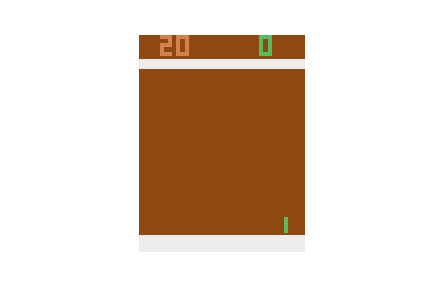
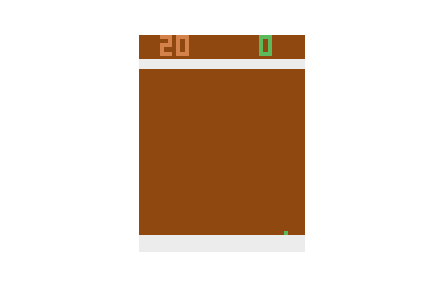
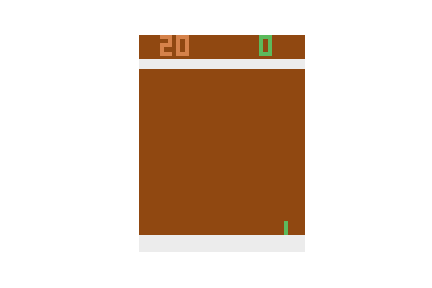
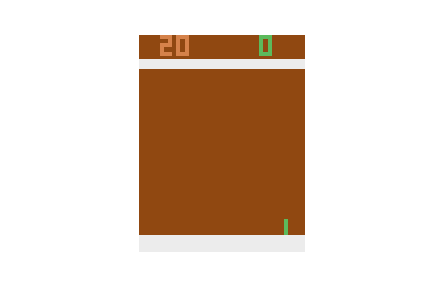
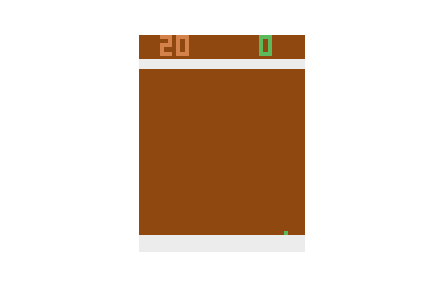
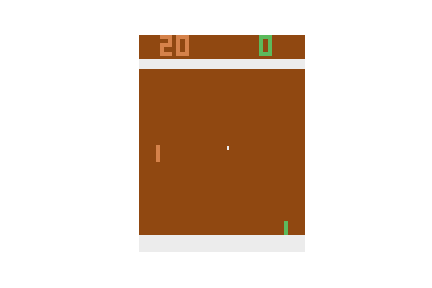
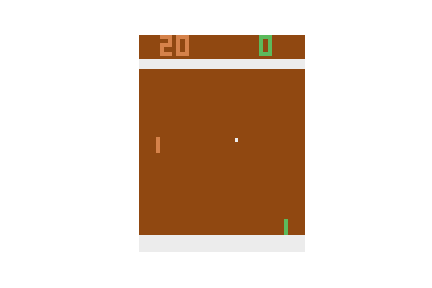
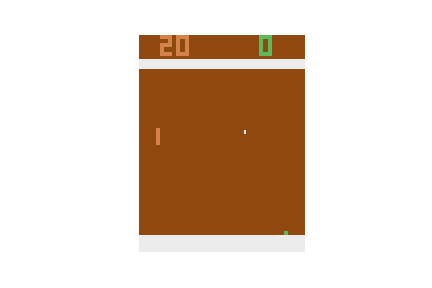
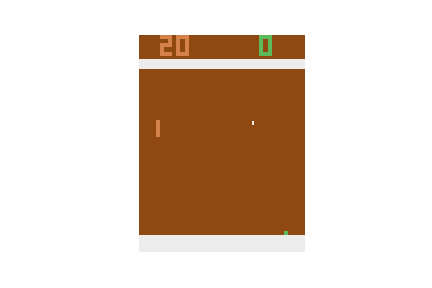
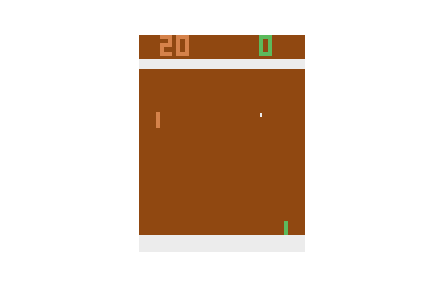
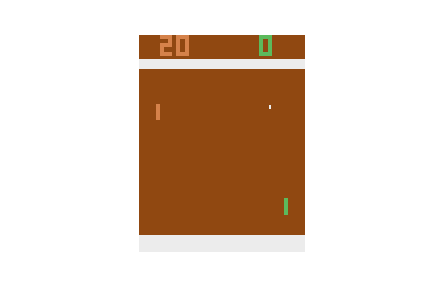
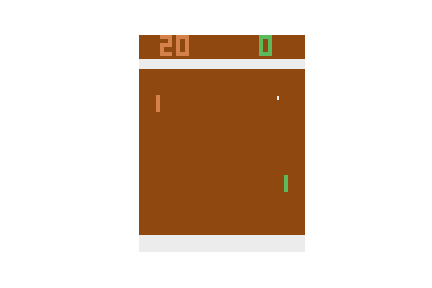
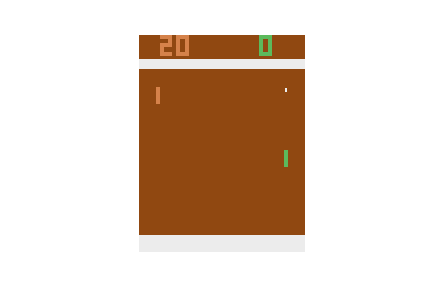
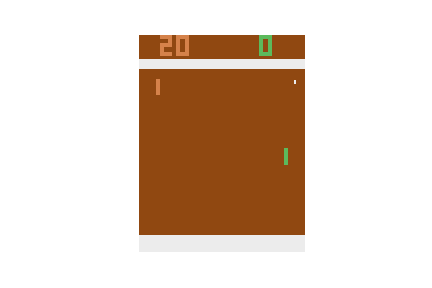
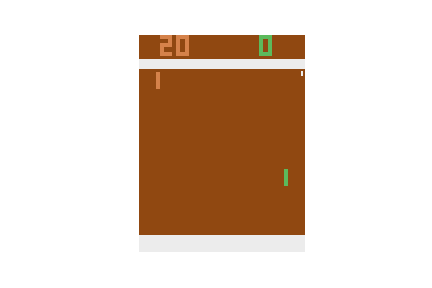

In [17]:
# play game after training!
pong_utils.play(env, policy, time=2000) 

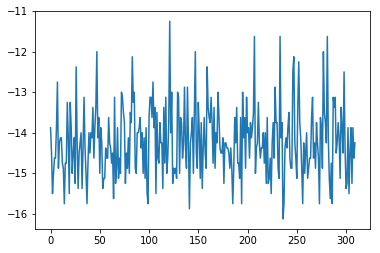

In [16]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

# load your policy if needed
# policy = torch.load('REINFORCE.policy')

# try and test out the solution!
# policy = torch.load('PPO_solution.policy')